In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, auc, confusion_matrix
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import StratifiedGroupKFold
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import OneHotEncoder



# Helpers to read in response data

In [2]:
"""
    _find_ppm_sheet(filname, ppm)

read in excel file and check the sheet names which include the ppm number.
80 ppm is always the first sheet in data, so only called when ppm != 80
"""

def _find_ppm_sheet(filename, ppm):
    xlfl = pd.ExcelFile(filename)
    sheet_names = xlfl.sheet_names
    target_sheet = sheet_names[0]

    return target_sheet

"""
    _find_header_row(filename, search_terms=['Time', 's'])

read in excel file and check first ten rows for search terms.
return the first row in which a search term appears.
if not found, return None.
"""
def _find_header_row(filename, ppm_sheet=0, search_terms=['Time', 's']):
    for i in range(10):  # Check first 10 rows
        try:
            df = pd.read_excel(filename, sheet_name=ppm_sheet, header=i, nrows=1)
            for search_term in search_terms:
                if search_term in df.columns:
                    return i
        except:
            pass
    return None  # If header not found

def retrieve_batch(folder, MOF, gas, ppm):
    if folder == "mixtures": # order is different
        path = Path.cwd().joinpath(folder, gas, f"{ppm}ppm", MOF).rglob("*.xlsx")
    else:
        path = Path.cwd().joinpath(folder, gas, MOF, f"{ppm}ppm").rglob("*.xlsx")

    # folders contain multiple excel files, so extract relevant
    files = [file for file in path]
    df = pd.read_excel("batch_info.xlsx", header=1)
    batch = df[df["sensing trace name"] == files[0].name[:-5]]["MOF batch  (simplified)"].values[0]
    return batch


"""
    read_data(cof, gas, carrier, ppm)

read in the sensor response data for a given COF exposed to a
given gas with a given carrier at a given concentration.
returns list of pandas data frames with this data. (may be replicates)
each data frame has two columns: time, DeltaG/G0.

note: this is complicated because there are two formats for a given
cof, gas, carrier, ppm:
(1) multiple replicates in the same file
(2) multiple replicates in separate files
"""
def read_data(MOF, gas, ppm, folder, time_adjust=0):

    ppms = [0.5, 5, 10, 20, 40, 80, "4+36", "5+5", "9+13", "13+27", "18+4", "22+18", "27+31", "31+9","36+22", "40+40"]

    if folder == "mixtures": # order is different
        path = Path.cwd().joinpath(folder, gas, f"{ppm}ppm", MOF).rglob("*.xlsx")
    else:
        path = Path.cwd().joinpath(folder, gas, MOF, f"{ppm}ppm").rglob("*.xlsx")

    # folders contain multiple excel files, so extract relevant
    files = [file for file in path]
    if len(files) > 1:
        raise Exception(f"multiple data in folder {path}")




    # extract data from Excel files in list
    dfs = []
    for filename in files:
        ppm_sheet = None
        if ppm in ppms:
            ppm_sheet = _find_ppm_sheet(filename, ppm)
            # read in file (need to find header row; not consistent)
            header_row = _find_header_row(filename, ppm_sheet)
            df = pd.read_excel(filename, sheet_name=ppm_sheet, header=header_row)

        else:
            raise Exception("PPM not supported.")

        #    only keep a subset of the cols (Time and (perhaps multiple) with muA's)
        ids_cols_keep = df.columns.str.contains('A', na=False) | (df.columns == 's')
        # exposure time begins at 780s, ends 2580s
        start_index = df.index[df['s'] == 780 + time_adjust].tolist()[0]
        end_index = df.index[df['s'] == 2580 + time_adjust].tolist()[0]
        df = df.loc[start_index:end_index, df.columns[ids_cols_keep]]

        # check time is sliced properly
        assert df.iloc[0]["s"] == 780.0 + time_adjust
        assert df.iloc[-1]["s"] == 2580.0 + time_adjust
        # reshift time
        df["s"] = df["s"] - (780.0 + time_adjust)
        

        # drop columns with missing values
        df = df.dropna(axis='columns')

        df.reset_index(drop=True, inplace=True)

        # separate replicates into differente dataframes and append to dfs
        for i in df.columns:
            if 'A' in i and not np.all(df[i] == 0):
                data_rep = df[['s', i]]
                G0 = df[i].iloc[0]
                # replace muA column with -deltaG/G0 calculation: -ΔG/G0 = -(muA - G0)/G0 * 100
                data_rep.loc[:, i] = 100 * (-(data_rep.loc[:, i] - G0) / G0)
                data_rep = data_rep.rename(columns={i: "-ΔG/G0"})
                dfs.append(data_rep)

    return dfs

In [3]:
retrieve_batch("batch_2", "Cu-HHTP", "SO2", 40)

'Cu-1'

In [5]:
pip install pkg_resources

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pkg_resources (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for pkg_resources


In [1]:
from tsfresh import extract_features

ModuleNotFoundError: No module named 'pkg_resources'

In [641]:
k = read_data("Cu-HHTP", "SO2", 40, "batch_2")[0]

In [ ]:
extracted_features = extract_features(k, column_sort="s")

# Helper function to run linear regression


In [6]:
"""
    linear_regression(df, ids_split)

perform linear regression on df[ids_split]:
ΔG/G0 = m * t + b

# arguments:
* df := dataframe of a single partition of sensor_response data
* ids_split := indices of response data partition

# output: dict of:
* coef := coefficient from linear regression
* r2 := r2 score
* ids_split
"""
def linear_regression(df, ids_split):
    X = df.loc[ids_split, "s"].to_numpy().reshape(-1, 1)
    y = df.loc[ids_split, "-ΔG/G0"].to_numpy()

    reg = LinearRegression().fit(X, y)

    r2 = reg.score(X, y)

    slope = reg.coef_[0]
    intercept = reg.intercept_

    return {'slope': slope, 'r2': r2, 'ids_split': ids_split, 'intercept': intercept}

# Class to extract response features

In [602]:
class SensorResponse:
    def __init__(self, MOF, gas, ppm, folder, replicate_id, time_adjust=0):
        self.MOF = MOF
        self.gas = gas
        self.ppm = ppm
        self.replicate_id = replicate_id
        self.time_adjust = time_adjust
        self.folder = folder

        try:
            self.data = read_data(MOF, gas, ppm, folder, time_adjust=self.time_adjust)[replicate_id]
        except IndexError:
            print(f"Error: replicate_id {replicate_id} does not exist for {gas}  in {MOF} at {ppm} ppm.")

        # store features
        self.slope_info = None
        self.saturation = None
        self.auc = None

    """
    compute_initial_slope(self, partition_size, total_time_window, mse_bound)
    estimate initial slope of data.

      arguments:
          * max_time := indicates the window of time from 0 to max_time to partition data
          * n_partitions := number of partitions
          * r2_bound := bound on acceptable r-squared values from linear regression
    """
    def compute_initial_slope(self, n_partitions=15, max_time=750.0, r2_bound=0):
        early_df = self.data[self.data["s"] < max_time]

        # partition data indices
        ids_splits = np.array_split(early_df.index, n_partitions)

        # create list of regression on each partition of data which satisfy the mean_squared error bound
        regression_data = [linear_regression(early_df, ids_split) for ids_split in ids_splits]
        # filter according to r2
        regression_data = list(filter(lambda res: res['r2'] > r2_bound, regression_data))

        if len(regression_data) == 0:
            raise Exception("Data has no initial slopes that satisfy r2 bound.")

        # find index of max absolute value of linear regression coefficients
        id_initial_slope = np.argmax([np.abs(rd['slope']) for rd in regression_data])

        # return regression_data which contains the initial slope
        self.slope_info = regression_data[id_initial_slope]
        return self.slope_info

    def compute_saturation(self, n_partitions=50):
        ids_splits = np.array_split(self.data.index, n_partitions)
       
        # get mean over partitions
        means = [np.mean(self.data.iloc[ids_split]['-ΔG/G0']) for ids_split in ids_splits]
        id_max_magnitude = np.argmax(np.abs(means))

        self.saturation = means[id_max_magnitude]
        return self.saturation

    def compute_features(self, n_partitions_saturation=100, n_partitions_slope=15, r2_bound_slope=0):
        self.compute_saturation(n_partitions=n_partitions_saturation)
        self.compute_initial_slope(n_partitions=n_partitions_slope, r2_bound=r2_bound_slope)
        self.compute_area_under_response_curve()

    # compute area under curve for each GBx DeltaG/G0 using sklearn auc
    def compute_area_under_response_curve(self):
        self.auc = auc(self.data["s"], self.data['-ΔG/G0'])
        return self.auc
    
    def mean_response(self, partition=6):
        interval = np.max(self.data.s) // partition
        mean_response = []
        for i in range(partition):
            part_data = self.data[(self.data.s >= i * interval) & (self.data.s <= i * interval + interval)]
            mean_response.append(np.mean(part_data['-ΔG/G0']))
        self.mean_1, self.mean_2, self.mean_3, self.mean_4, self.mean_5, self.mean_6 = mean_response   
        return 

        

    def viz(self, save=True): # viz the data along with the response features or function u fit to it.
        if self.slope_info == None or self.saturation == None:
            raise Exception("Compute features first.")

        fig, ax = plt.subplots()

        plt.xlabel("time [s]")
        plt.ylabel(r"$\Delta G/G_0$")

        # plot raw response data
        plt.scatter(self.data['s'], self.data['-ΔG/G0'])

        ###
        #   viz features
        ###
        # saturation
        plt.axhline(self.saturation, linestyle='-', color="gray")

        # slope
        t_start = self.data.loc[self.slope_info["ids_split"][0], 's']
        t_end = self.data.loc[self.slope_info["ids_split"][-1], 's']
        plt.plot(
            [t_start, t_end],
            self.slope_info["slope"] * np.array([t_start, t_end]) + self.slope_info["intercept"],
            color='orange'
        )

        all_info = "{}_{}_{}_{}ppm_{}".format(self.folder, self.MOF, self.gas, self.ppm, self.replicate_id)
        plt.title(all_info)

        if save:
            plt.savefig("responses/featurized_{}.png".format(all_info), format="png")
        plt.show()


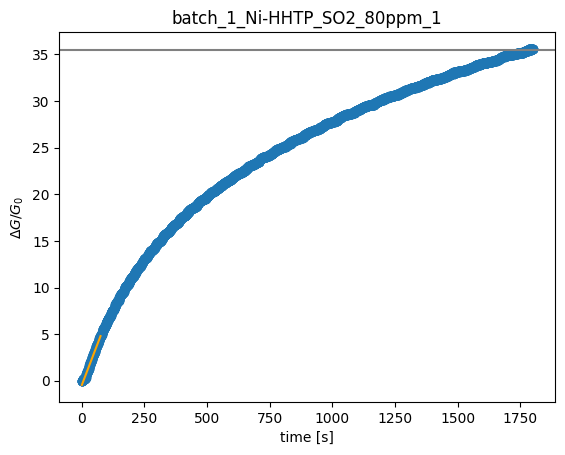

In [603]:
# Test the SensorResponse class initial_slope function
sensor_response = SensorResponse("Ni-HHTP", "SO2", 80, "batch_1", 1)
sensor_response.compute_features(n_partitions_slope=10)
# sensor_response.compute_initial_slope(r2_bound=0.95)
sensor_response.viz(save=True)
sensor_response.mean_response()

In [604]:
# Read data from existing data in csv or loop through raw data?
read_data_from_file = False

In [605]:
folders = ["batch_2", "mixtures"]
gases = ['H2S', "SO2", "H2S_SO2"]
MOFs = ["Cu-HHTP", "Ni-HHTP", "Zn-HHTP"]
features = ['auc', 'slope', 'saturation']
ppms = [0.5, 5, 10, 20, 40, 80, "4+36", "5+5", "9+13", "13+27", "18+4", "22+18", "27+31", "31+9","36+22", "40+40"]

# Loop through raw data to compute all sensor responses

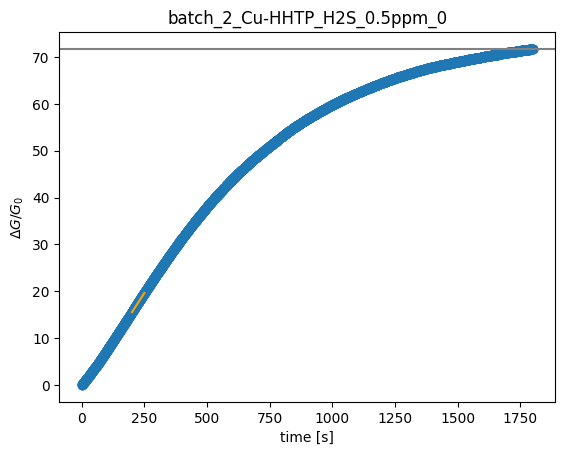

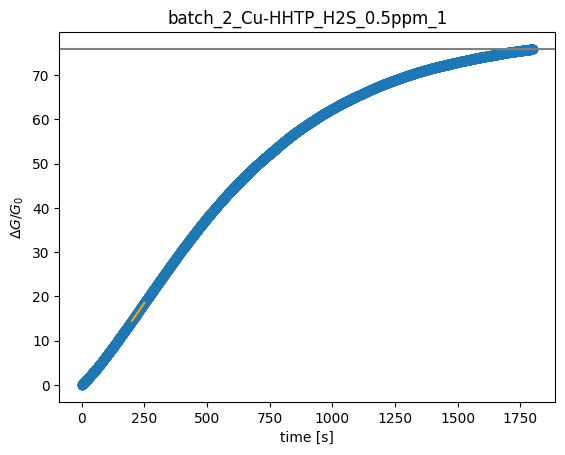

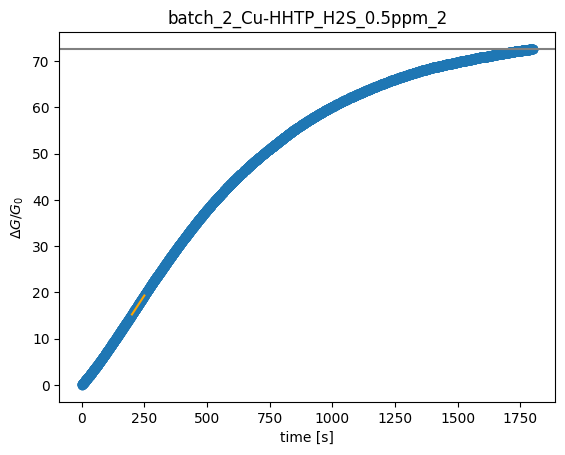

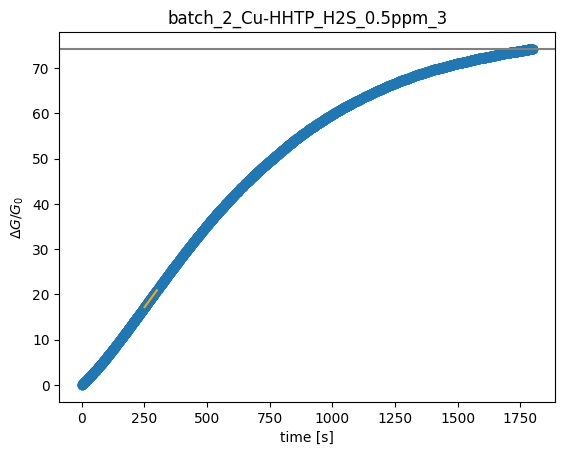

Error: replicate_id 4 does not exist for H2S  in Cu-HHTP at 0.5 ppm.
Error: replicate_id 5 does not exist for H2S  in Cu-HHTP at 0.5 ppm.
Error: replicate_id 6 does not exist for H2S  in Cu-HHTP at 0.5 ppm.
Error: replicate_id 7 does not exist for H2S  in Cu-HHTP at 0.5 ppm.


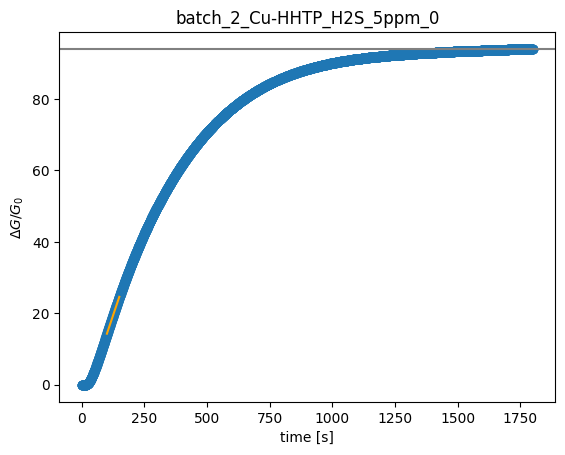

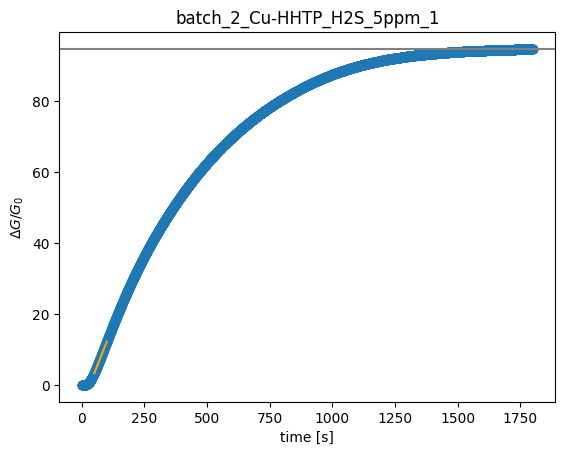

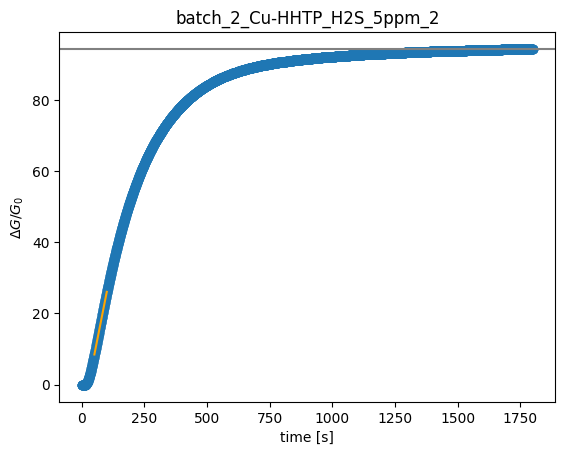

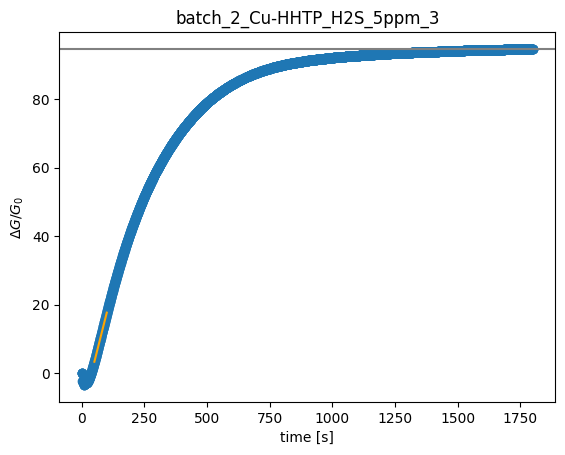

Error: replicate_id 4 does not exist for H2S  in Cu-HHTP at 5 ppm.
Error: replicate_id 5 does not exist for H2S  in Cu-HHTP at 5 ppm.
Error: replicate_id 6 does not exist for H2S  in Cu-HHTP at 5 ppm.
Error: replicate_id 7 does not exist for H2S  in Cu-HHTP at 5 ppm.


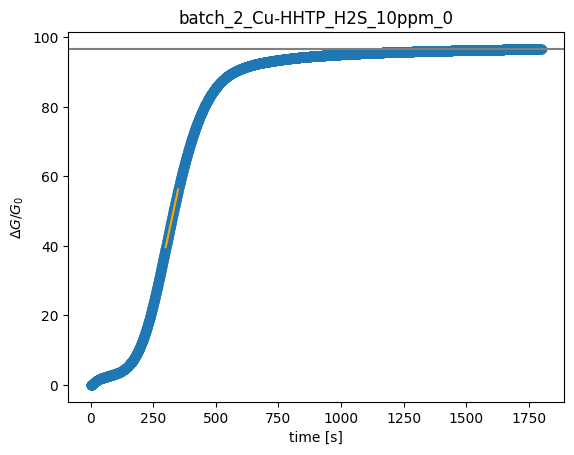

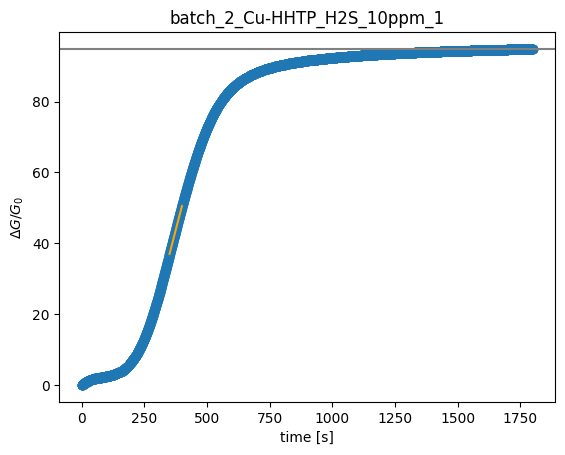

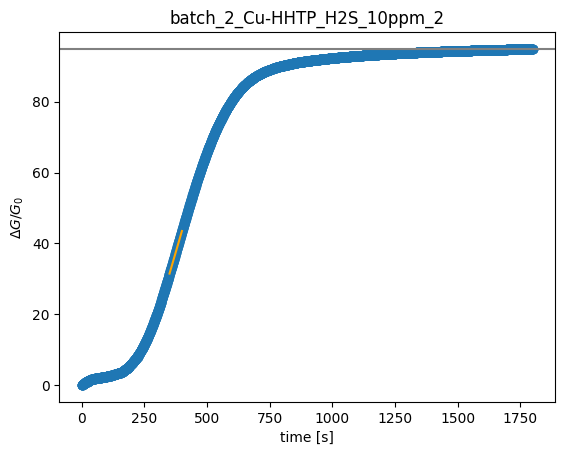

Error: replicate_id 3 does not exist for H2S  in Cu-HHTP at 10 ppm.
Error: replicate_id 4 does not exist for H2S  in Cu-HHTP at 10 ppm.
Error: replicate_id 5 does not exist for H2S  in Cu-HHTP at 10 ppm.
Error: replicate_id 6 does not exist for H2S  in Cu-HHTP at 10 ppm.
Error: replicate_id 7 does not exist for H2S  in Cu-HHTP at 10 ppm.


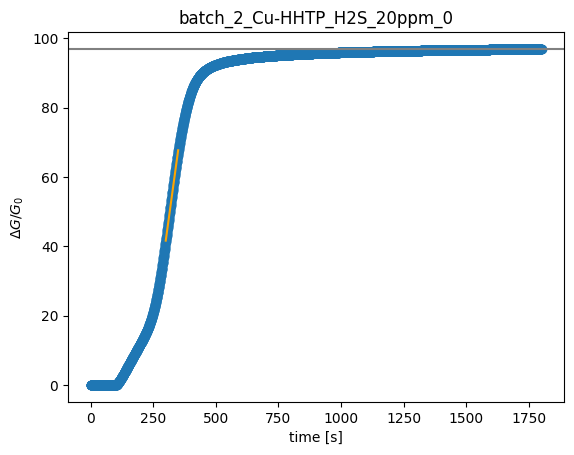

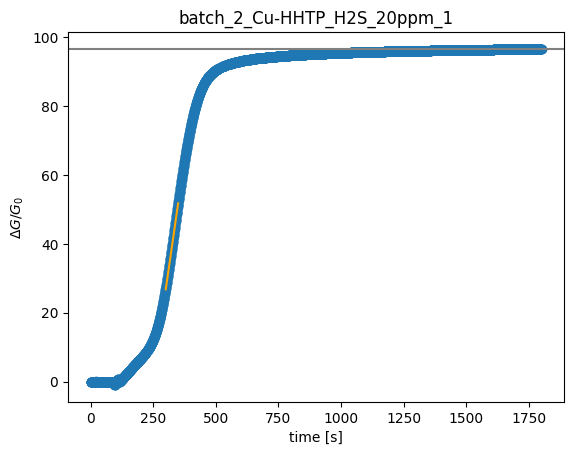

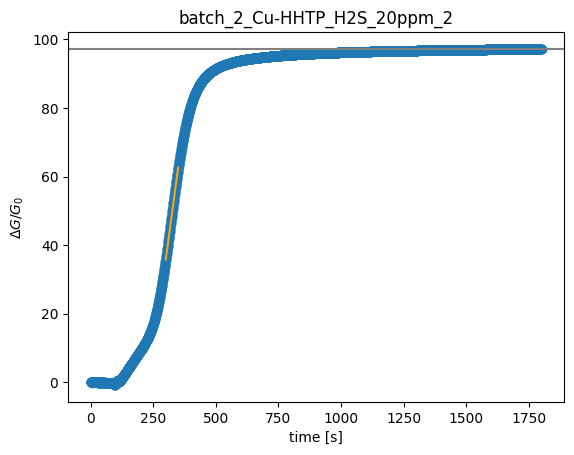

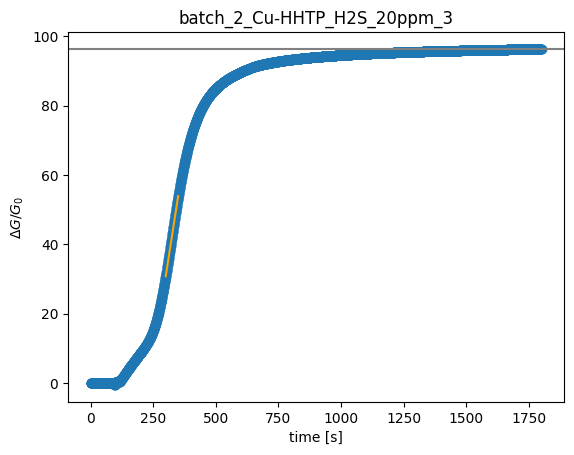

Error: replicate_id 4 does not exist for H2S  in Cu-HHTP at 20 ppm.
Error: replicate_id 5 does not exist for H2S  in Cu-HHTP at 20 ppm.
Error: replicate_id 6 does not exist for H2S  in Cu-HHTP at 20 ppm.
Error: replicate_id 7 does not exist for H2S  in Cu-HHTP at 20 ppm.


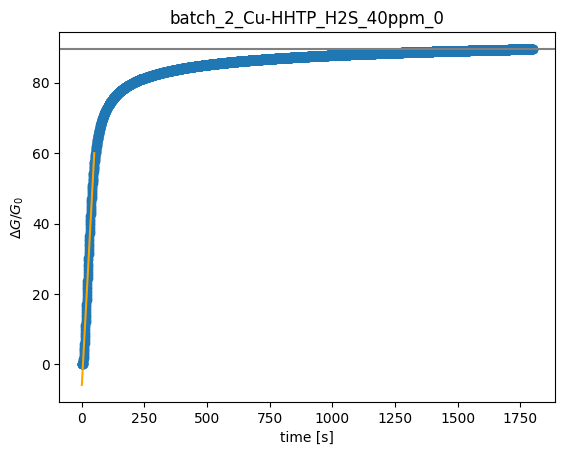

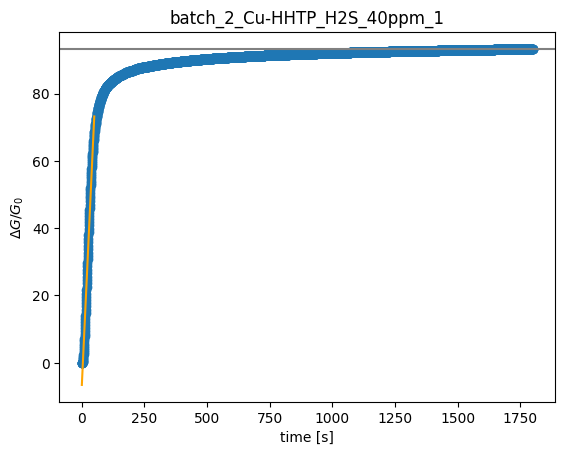

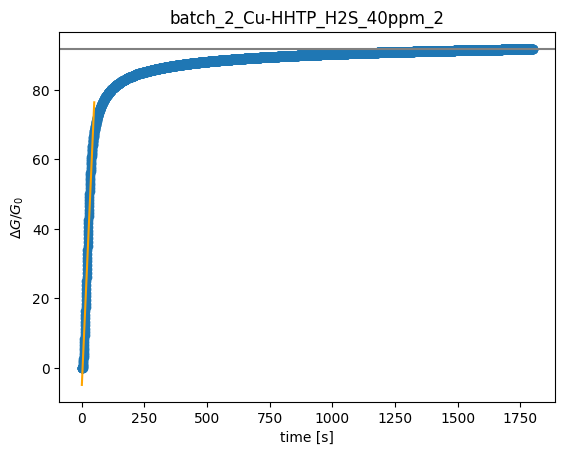

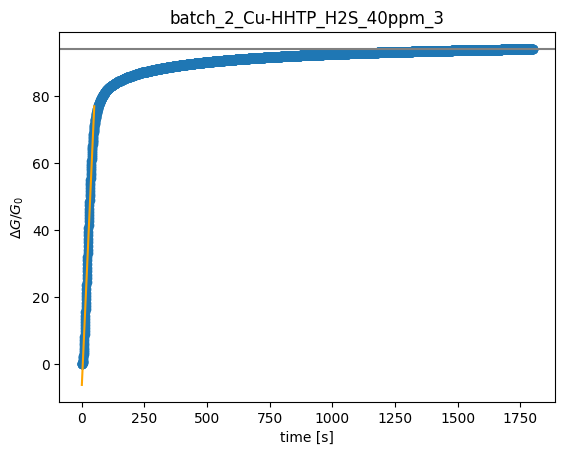

Error: replicate_id 4 does not exist for H2S  in Cu-HHTP at 40 ppm.
Error: replicate_id 5 does not exist for H2S  in Cu-HHTP at 40 ppm.
Error: replicate_id 6 does not exist for H2S  in Cu-HHTP at 40 ppm.
Error: replicate_id 7 does not exist for H2S  in Cu-HHTP at 40 ppm.


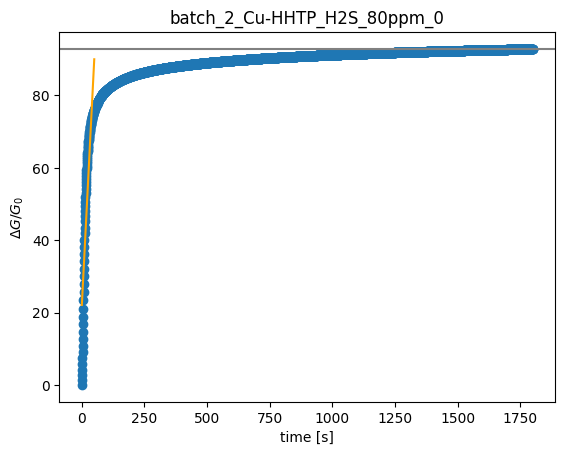

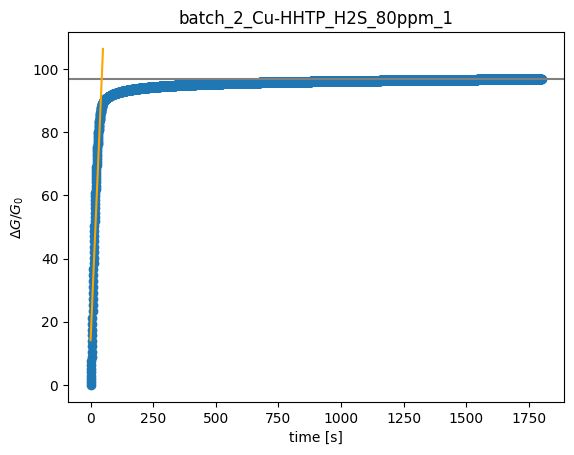

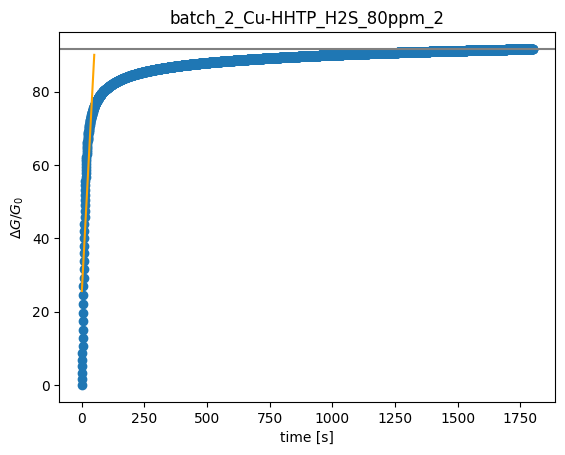

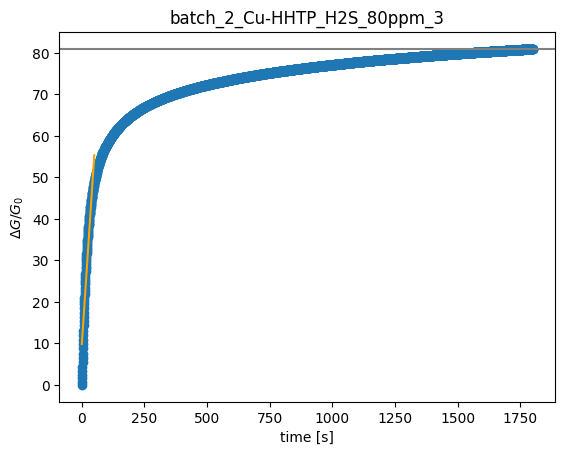

Error: replicate_id 4 does not exist for H2S  in Cu-HHTP at 80 ppm.
Error: replicate_id 5 does not exist for H2S  in Cu-HHTP at 80 ppm.
Error: replicate_id 6 does not exist for H2S  in Cu-HHTP at 80 ppm.
Error: replicate_id 7 does not exist for H2S  in Cu-HHTP at 80 ppm.
Error: replicate_id 0 does not exist for H2S  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 1 does not exist for H2S  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 2 does not exist for H2S  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 3 does not exist for H2S  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 4 does not exist for H2S  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 5 does not exist for H2S  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 6 does not exist for H2S  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 7 does not exist for H2S  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 0 does not exist for H2S  in Cu-HHTP at 5+5 ppm.
Error: replicate_id 1 does not exist for H2S  in Cu-HHTP at 5+5 ppm.
Error: replicate_id 2 does not

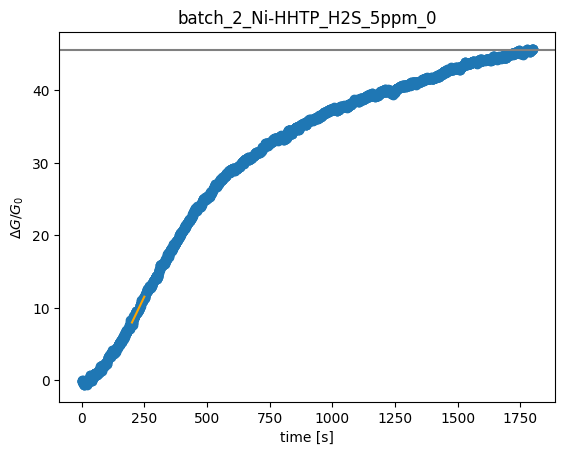

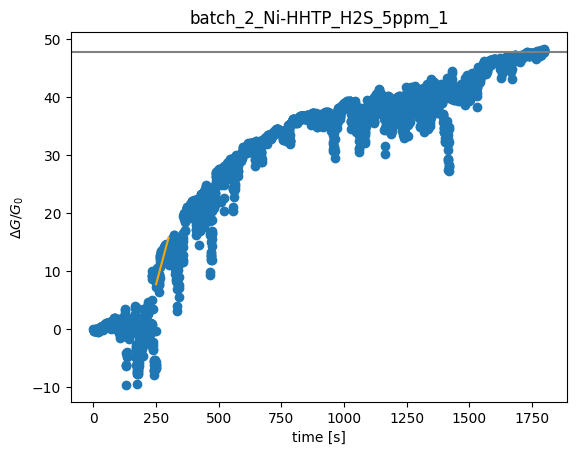

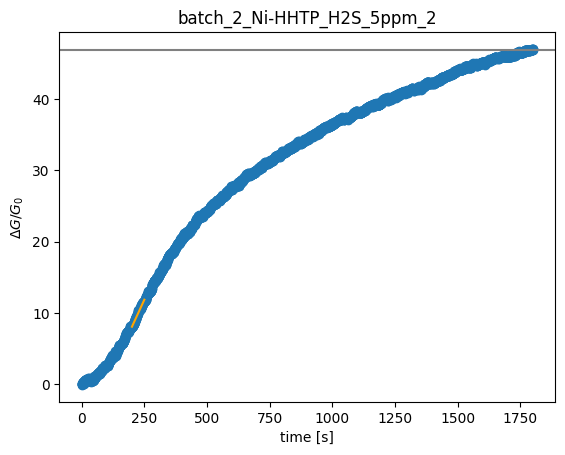

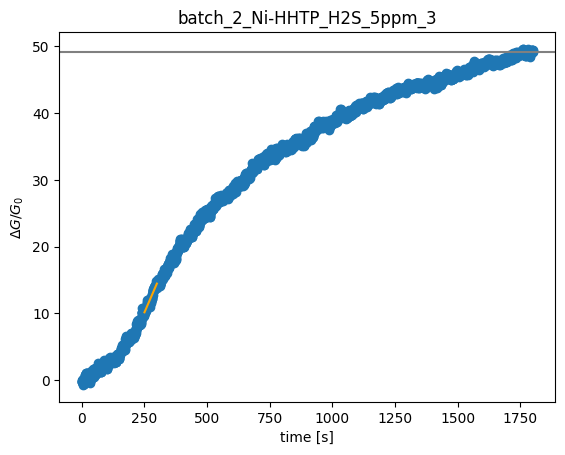

Error: replicate_id 4 does not exist for H2S  in Ni-HHTP at 5 ppm.
Error: replicate_id 5 does not exist for H2S  in Ni-HHTP at 5 ppm.
Error: replicate_id 6 does not exist for H2S  in Ni-HHTP at 5 ppm.
Error: replicate_id 7 does not exist for H2S  in Ni-HHTP at 5 ppm.


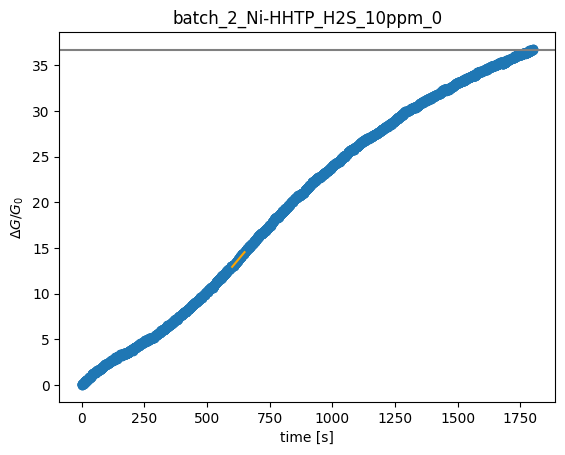

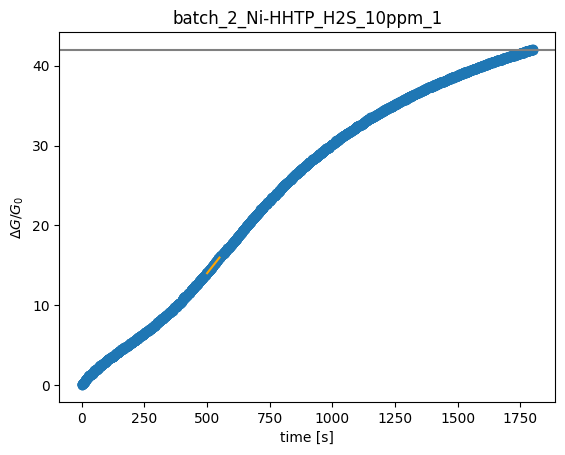

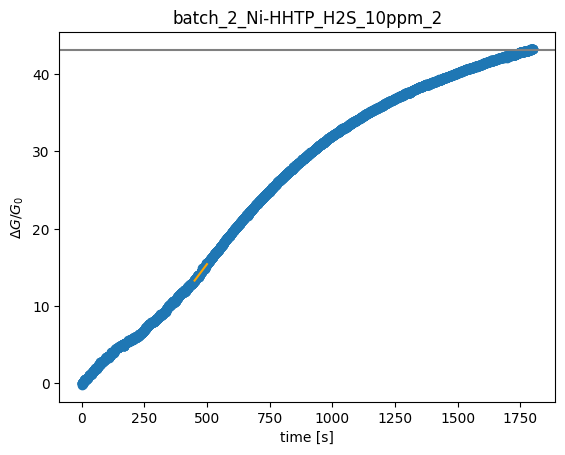

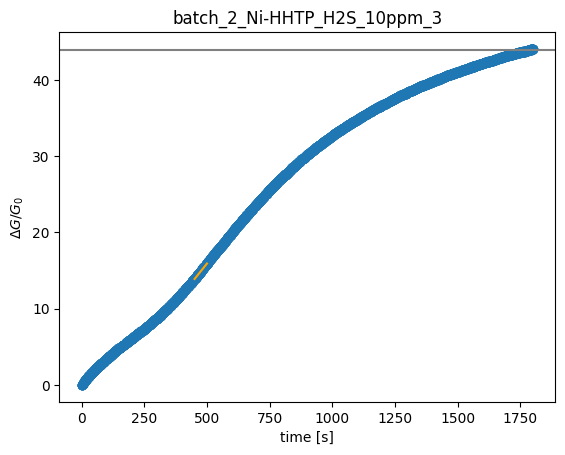

Error: replicate_id 4 does not exist for H2S  in Ni-HHTP at 10 ppm.
Error: replicate_id 5 does not exist for H2S  in Ni-HHTP at 10 ppm.
Error: replicate_id 6 does not exist for H2S  in Ni-HHTP at 10 ppm.
Error: replicate_id 7 does not exist for H2S  in Ni-HHTP at 10 ppm.


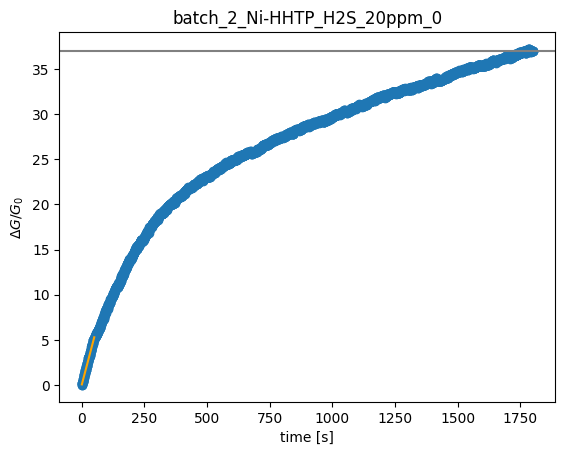

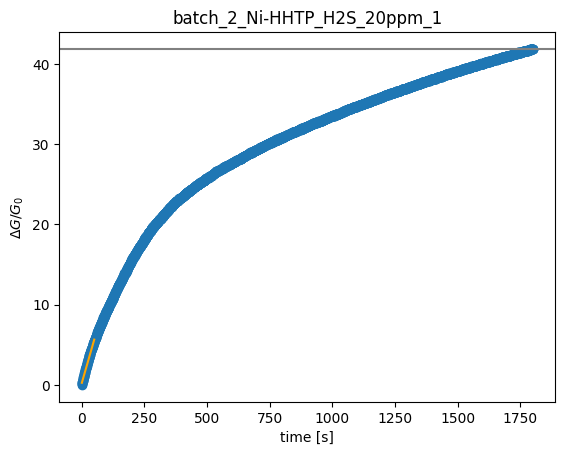

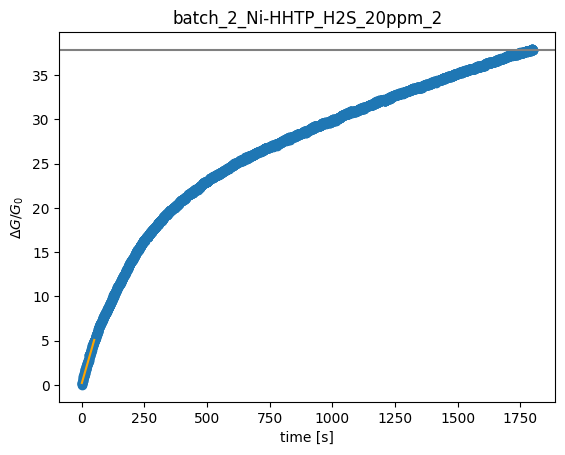

Error: replicate_id 3 does not exist for H2S  in Ni-HHTP at 20 ppm.
Error: replicate_id 4 does not exist for H2S  in Ni-HHTP at 20 ppm.
Error: replicate_id 5 does not exist for H2S  in Ni-HHTP at 20 ppm.
Error: replicate_id 6 does not exist for H2S  in Ni-HHTP at 20 ppm.
Error: replicate_id 7 does not exist for H2S  in Ni-HHTP at 20 ppm.


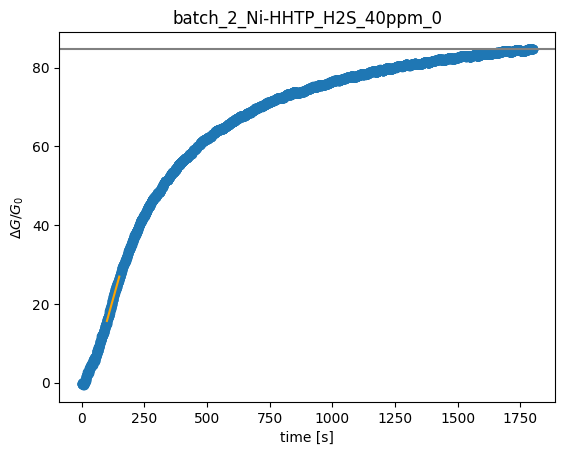

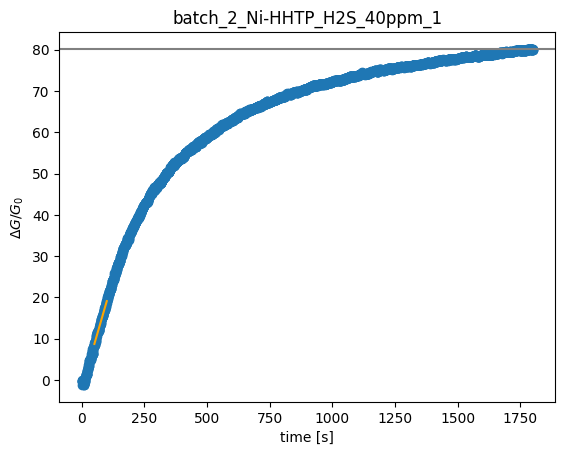

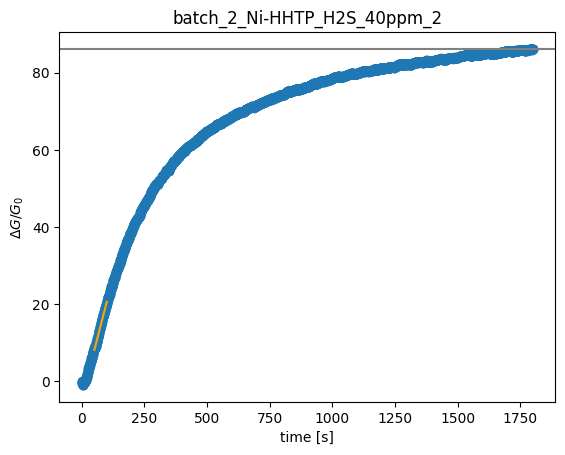

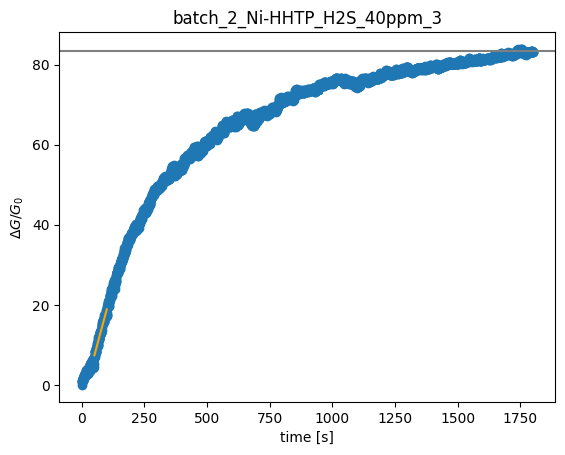

Error: replicate_id 4 does not exist for H2S  in Ni-HHTP at 40 ppm.
Error: replicate_id 5 does not exist for H2S  in Ni-HHTP at 40 ppm.
Error: replicate_id 6 does not exist for H2S  in Ni-HHTP at 40 ppm.
Error: replicate_id 7 does not exist for H2S  in Ni-HHTP at 40 ppm.


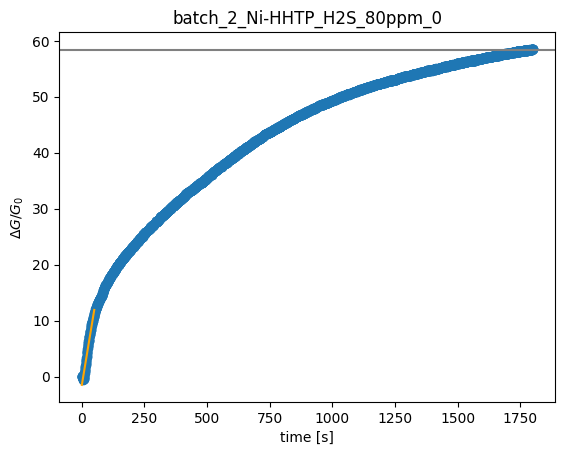

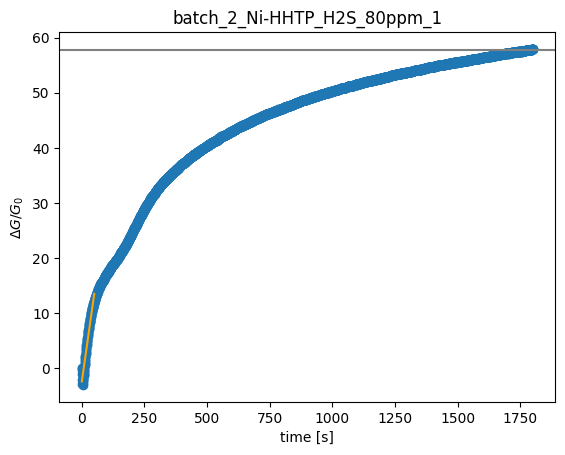

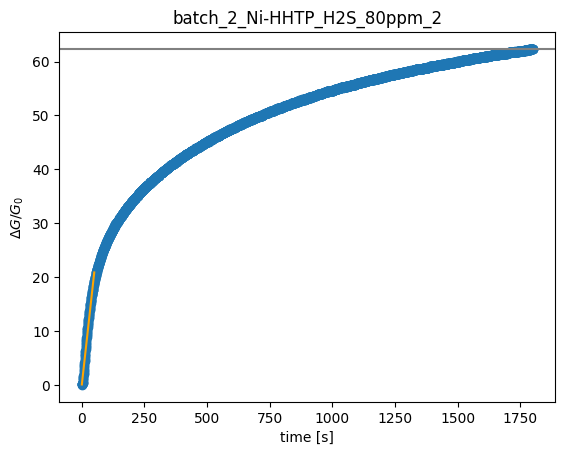

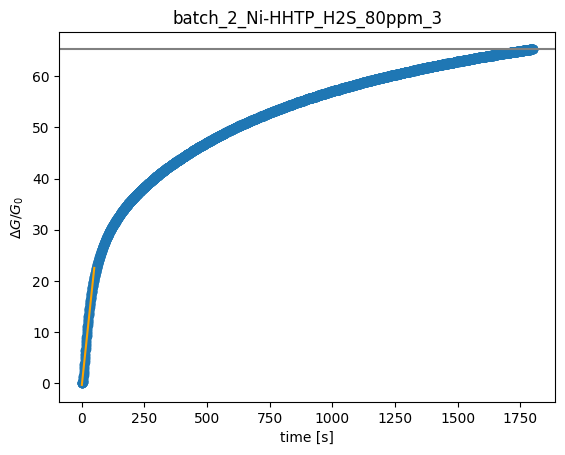

Error: replicate_id 4 does not exist for H2S  in Ni-HHTP at 80 ppm.
Error: replicate_id 5 does not exist for H2S  in Ni-HHTP at 80 ppm.
Error: replicate_id 6 does not exist for H2S  in Ni-HHTP at 80 ppm.
Error: replicate_id 7 does not exist for H2S  in Ni-HHTP at 80 ppm.
Error: replicate_id 0 does not exist for H2S  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 1 does not exist for H2S  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 2 does not exist for H2S  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 3 does not exist for H2S  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 4 does not exist for H2S  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 5 does not exist for H2S  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 6 does not exist for H2S  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 7 does not exist for H2S  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 0 does not exist for H2S  in Ni-HHTP at 5+5 ppm.
Error: replicate_id 1 does not exist for H2S  in Ni-HHTP at 5+5 ppm.
Error: replicate_id 2 does not

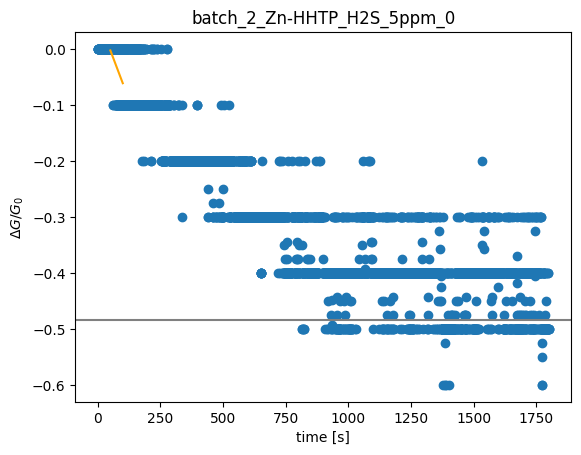

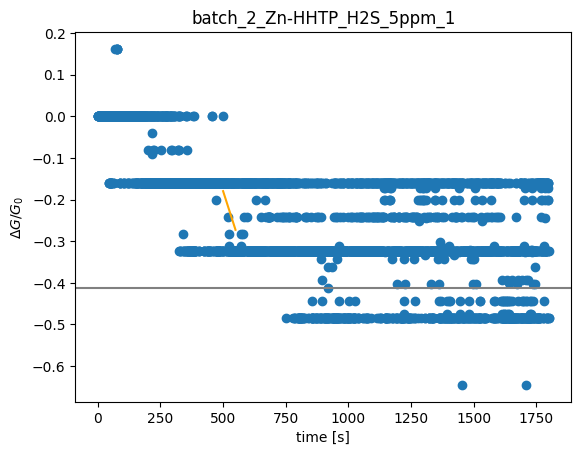

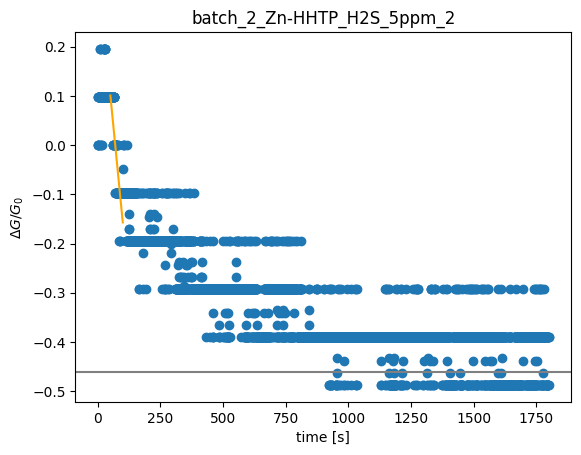

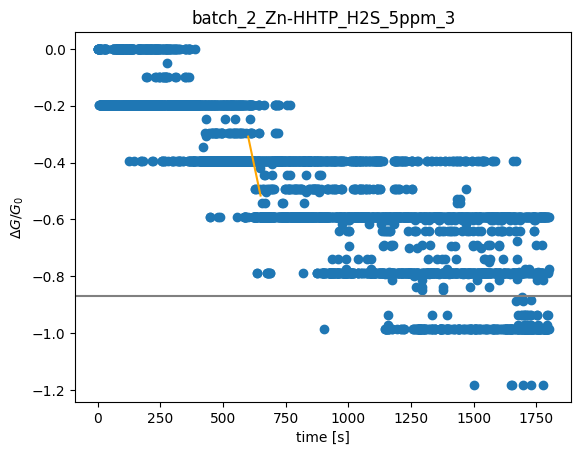

Error: replicate_id 4 does not exist for H2S  in Zn-HHTP at 5 ppm.
Error: replicate_id 5 does not exist for H2S  in Zn-HHTP at 5 ppm.
Error: replicate_id 6 does not exist for H2S  in Zn-HHTP at 5 ppm.
Error: replicate_id 7 does not exist for H2S  in Zn-HHTP at 5 ppm.


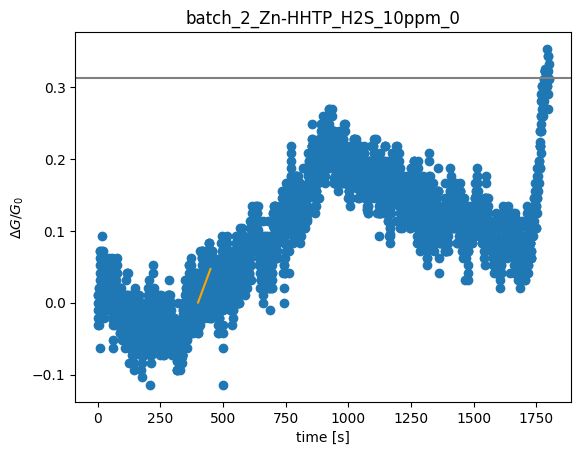

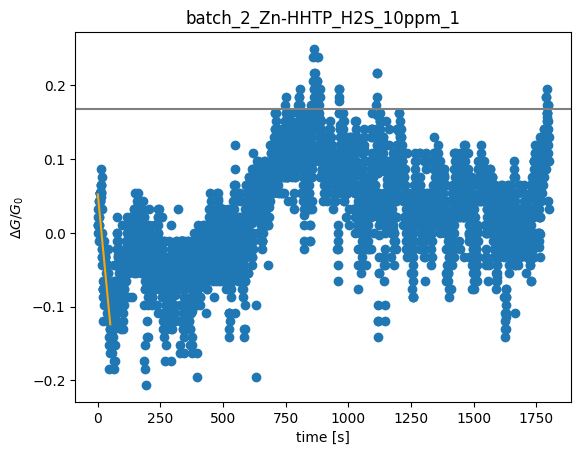

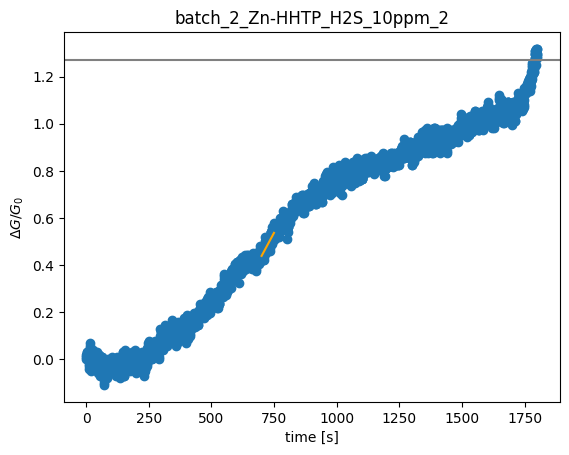

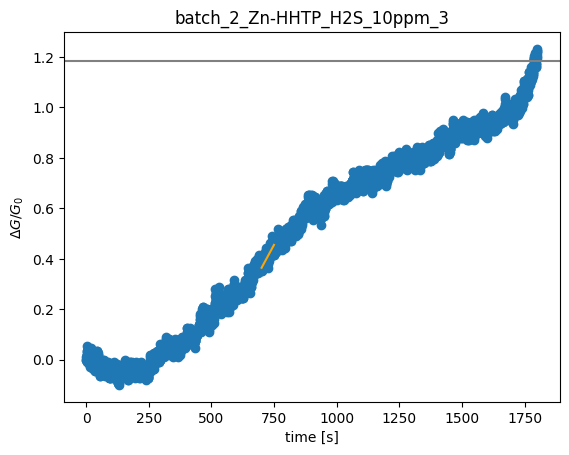

Error: replicate_id 4 does not exist for H2S  in Zn-HHTP at 10 ppm.
Error: replicate_id 5 does not exist for H2S  in Zn-HHTP at 10 ppm.
Error: replicate_id 6 does not exist for H2S  in Zn-HHTP at 10 ppm.
Error: replicate_id 7 does not exist for H2S  in Zn-HHTP at 10 ppm.


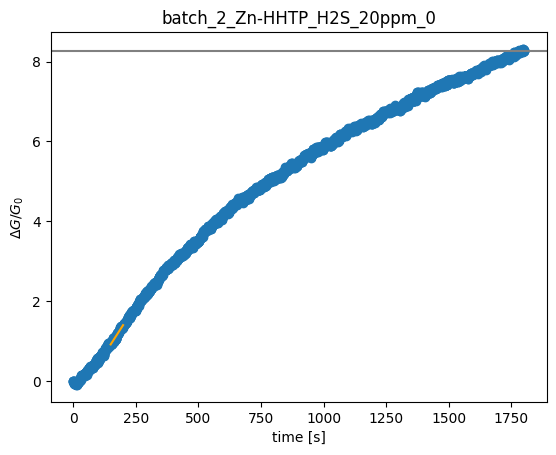

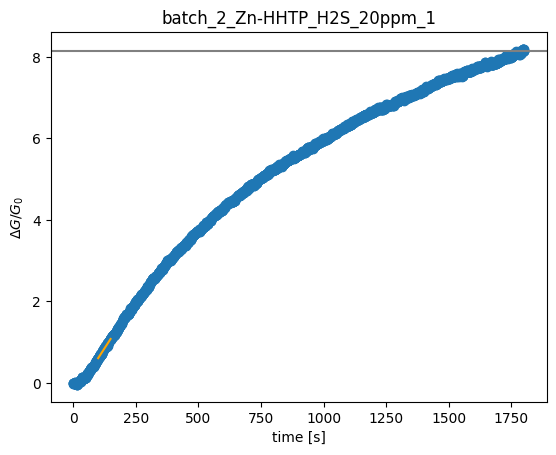

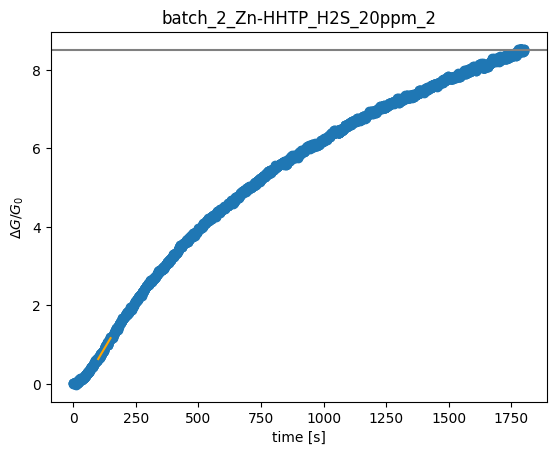

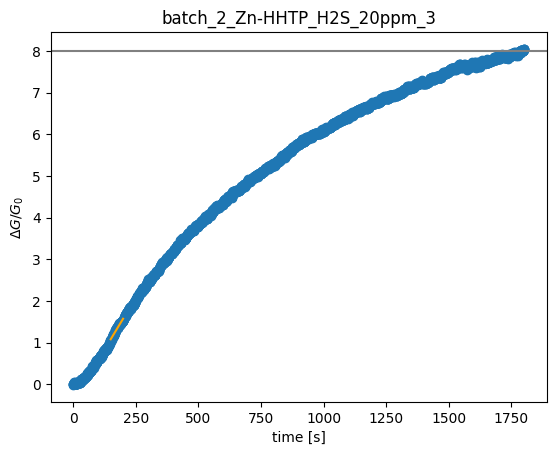

Error: replicate_id 4 does not exist for H2S  in Zn-HHTP at 20 ppm.
Error: replicate_id 5 does not exist for H2S  in Zn-HHTP at 20 ppm.
Error: replicate_id 6 does not exist for H2S  in Zn-HHTP at 20 ppm.
Error: replicate_id 7 does not exist for H2S  in Zn-HHTP at 20 ppm.


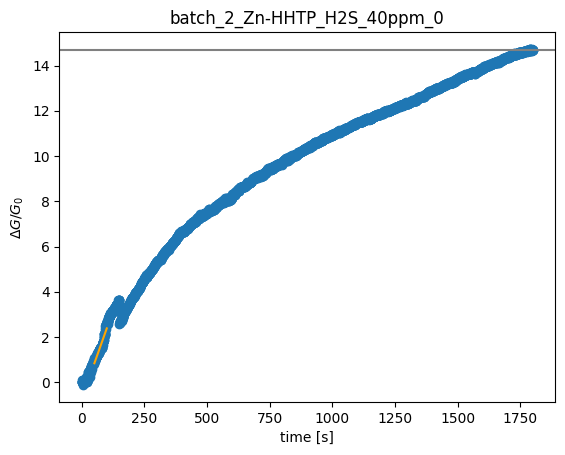

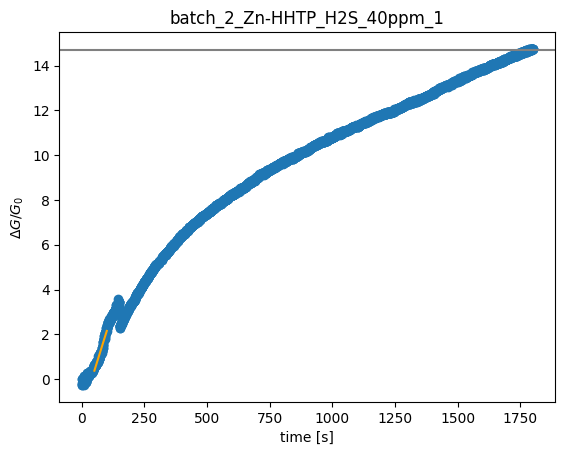

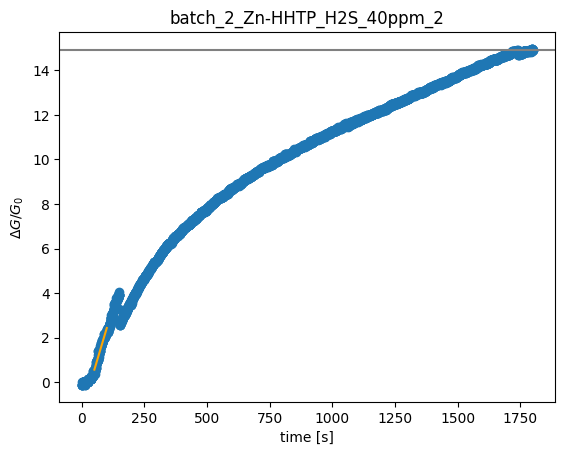

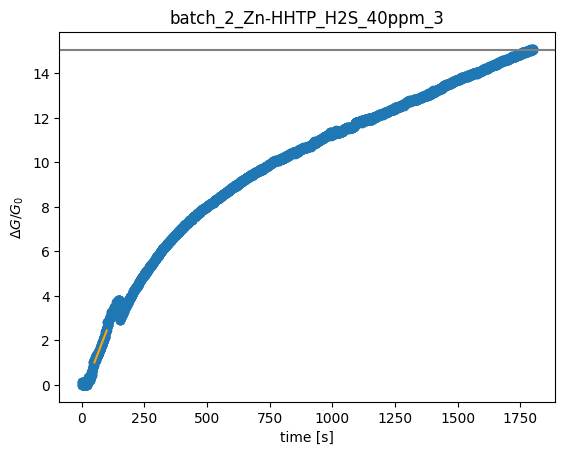

Error: replicate_id 4 does not exist for H2S  in Zn-HHTP at 40 ppm.
Error: replicate_id 5 does not exist for H2S  in Zn-HHTP at 40 ppm.
Error: replicate_id 6 does not exist for H2S  in Zn-HHTP at 40 ppm.
Error: replicate_id 7 does not exist for H2S  in Zn-HHTP at 40 ppm.


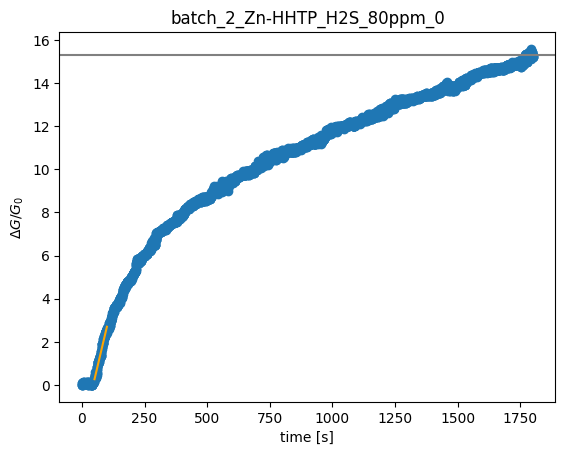

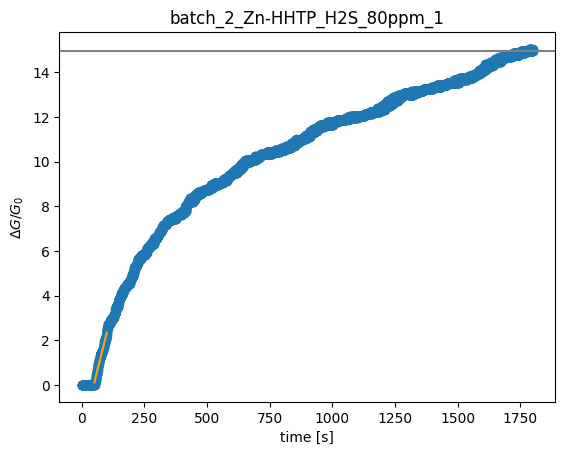

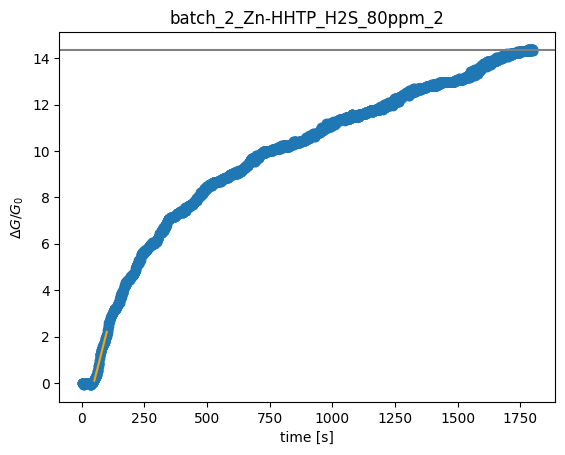

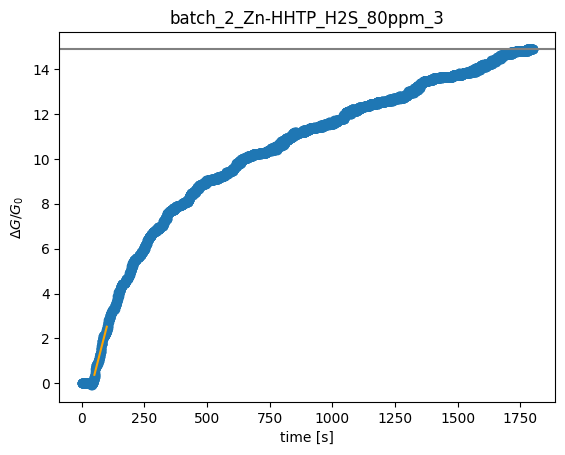

Error: replicate_id 4 does not exist for H2S  in Zn-HHTP at 80 ppm.
Error: replicate_id 5 does not exist for H2S  in Zn-HHTP at 80 ppm.
Error: replicate_id 6 does not exist for H2S  in Zn-HHTP at 80 ppm.
Error: replicate_id 7 does not exist for H2S  in Zn-HHTP at 80 ppm.
Error: replicate_id 0 does not exist for H2S  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 1 does not exist for H2S  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 2 does not exist for H2S  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 3 does not exist for H2S  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 4 does not exist for H2S  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 5 does not exist for H2S  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 6 does not exist for H2S  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 7 does not exist for H2S  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 0 does not exist for H2S  in Zn-HHTP at 5+5 ppm.
Error: replicate_id 1 does not exist for H2S  in Zn-HHTP at 5+5 ppm.
Error: replicate_id 2 does not

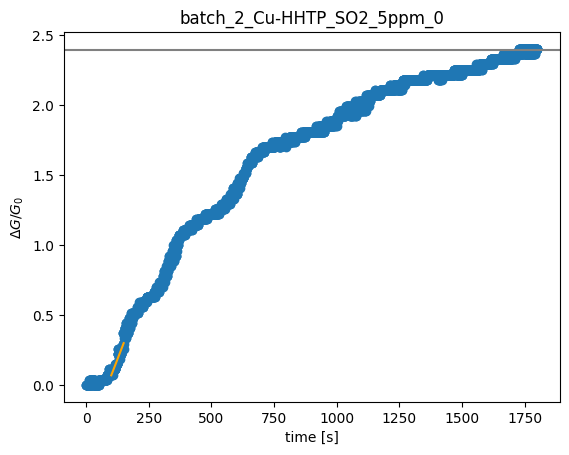

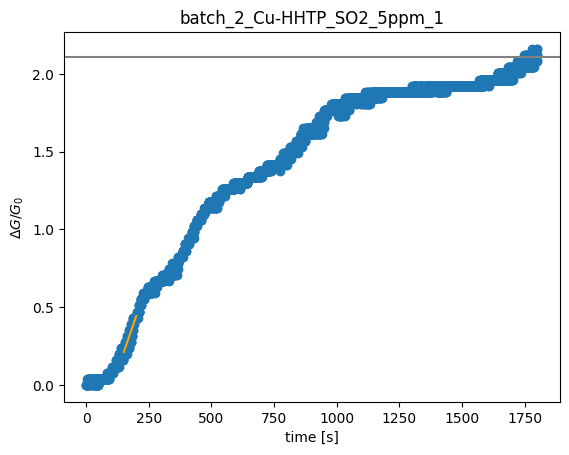

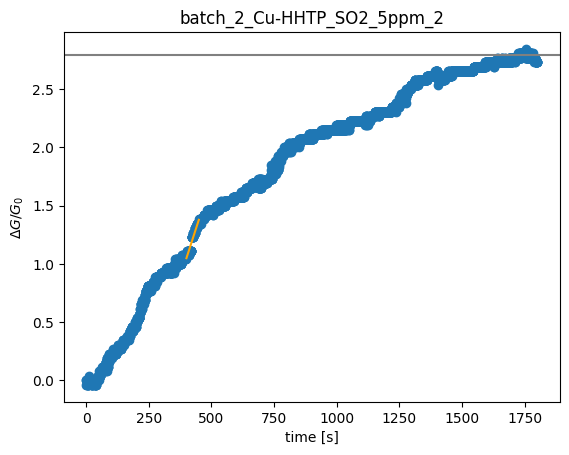

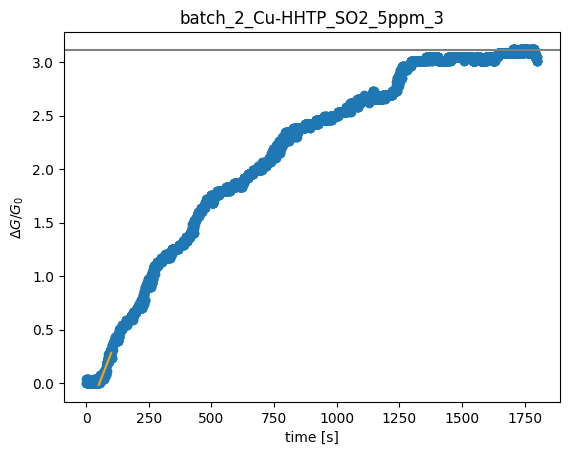

Error: replicate_id 4 does not exist for SO2  in Cu-HHTP at 5 ppm.
Error: replicate_id 5 does not exist for SO2  in Cu-HHTP at 5 ppm.
Error: replicate_id 6 does not exist for SO2  in Cu-HHTP at 5 ppm.
Error: replicate_id 7 does not exist for SO2  in Cu-HHTP at 5 ppm.


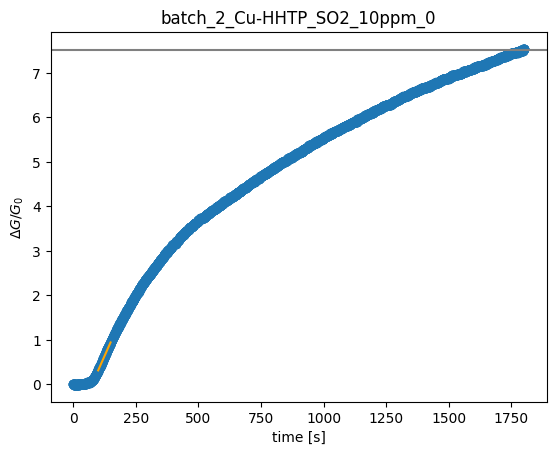

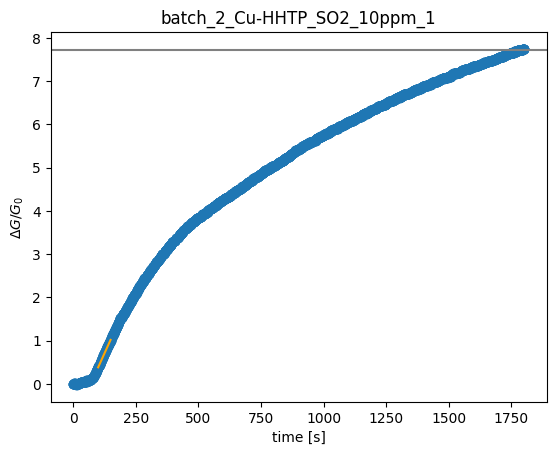

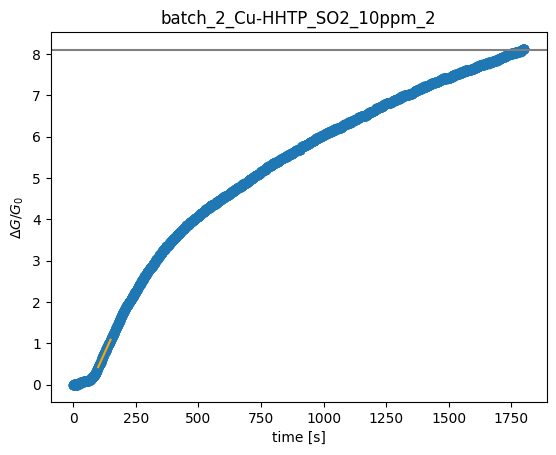

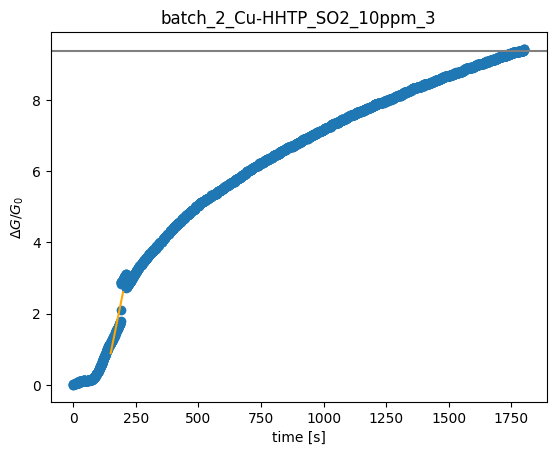

Error: replicate_id 4 does not exist for SO2  in Cu-HHTP at 10 ppm.
Error: replicate_id 5 does not exist for SO2  in Cu-HHTP at 10 ppm.
Error: replicate_id 6 does not exist for SO2  in Cu-HHTP at 10 ppm.
Error: replicate_id 7 does not exist for SO2  in Cu-HHTP at 10 ppm.


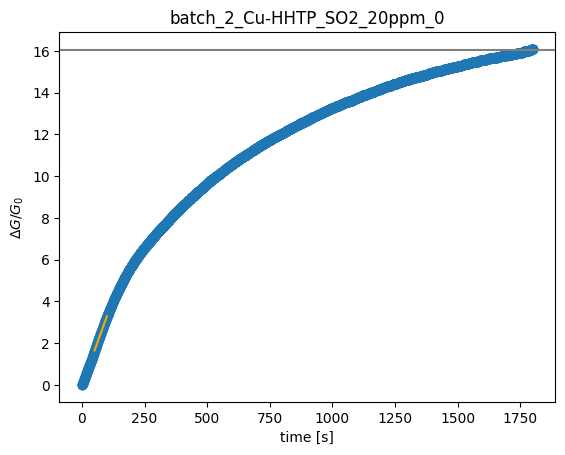

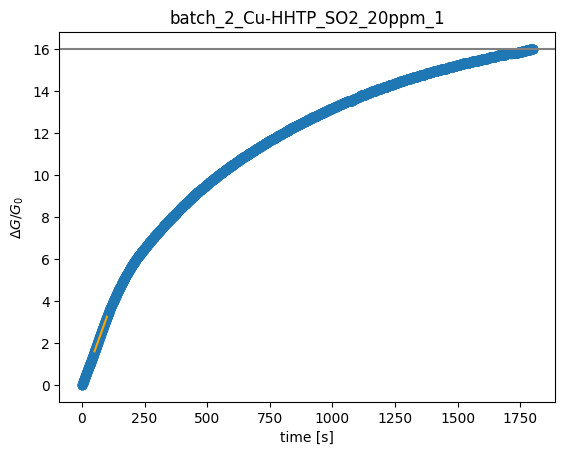

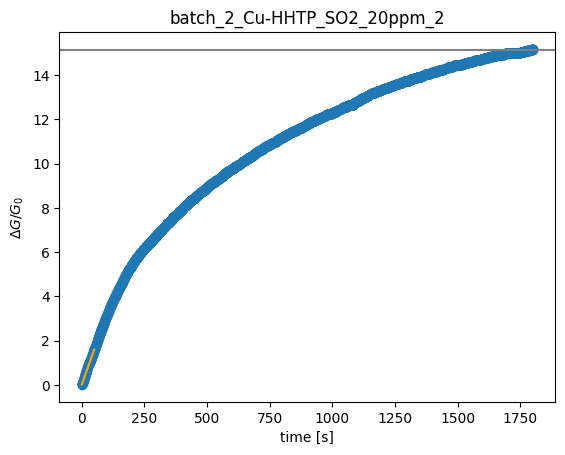

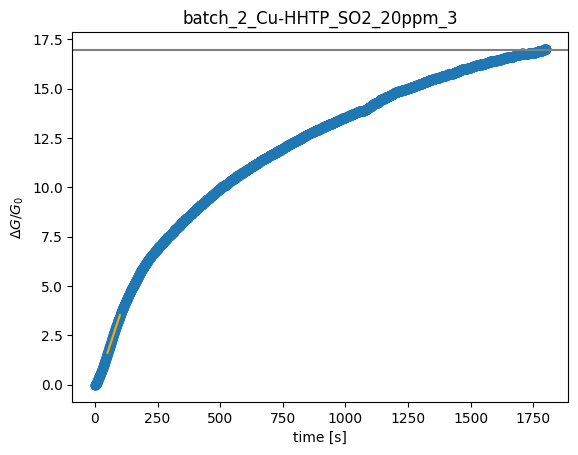

Error: replicate_id 4 does not exist for SO2  in Cu-HHTP at 20 ppm.
Error: replicate_id 5 does not exist for SO2  in Cu-HHTP at 20 ppm.
Error: replicate_id 6 does not exist for SO2  in Cu-HHTP at 20 ppm.
Error: replicate_id 7 does not exist for SO2  in Cu-HHTP at 20 ppm.


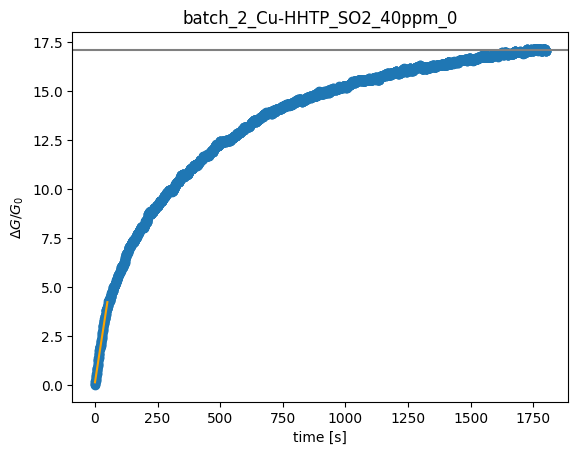

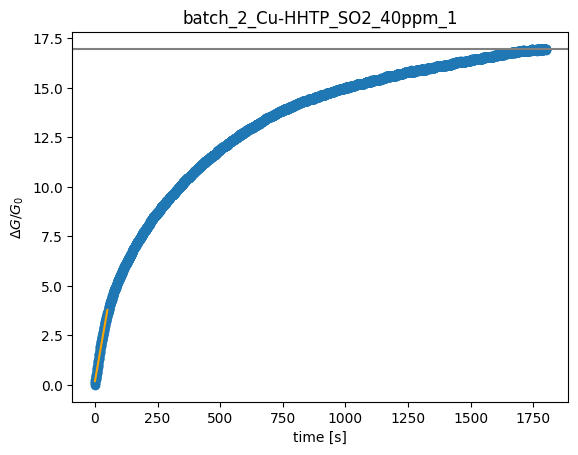

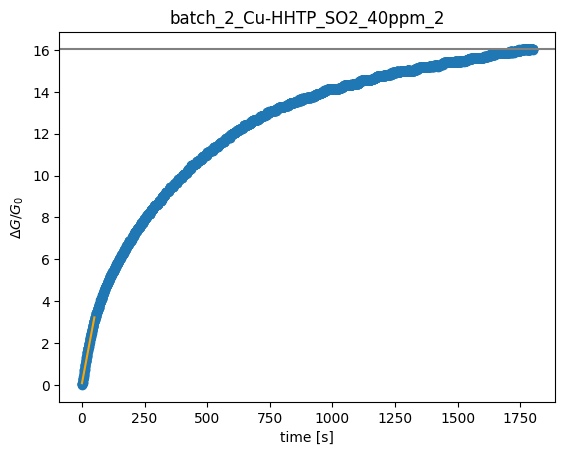

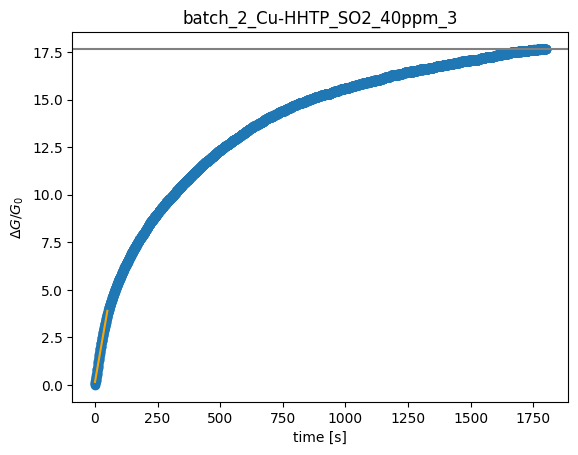

Error: replicate_id 4 does not exist for SO2  in Cu-HHTP at 40 ppm.
Error: replicate_id 5 does not exist for SO2  in Cu-HHTP at 40 ppm.
Error: replicate_id 6 does not exist for SO2  in Cu-HHTP at 40 ppm.
Error: replicate_id 7 does not exist for SO2  in Cu-HHTP at 40 ppm.


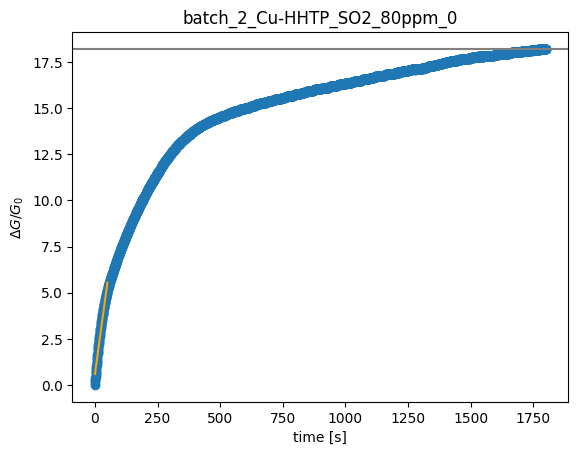

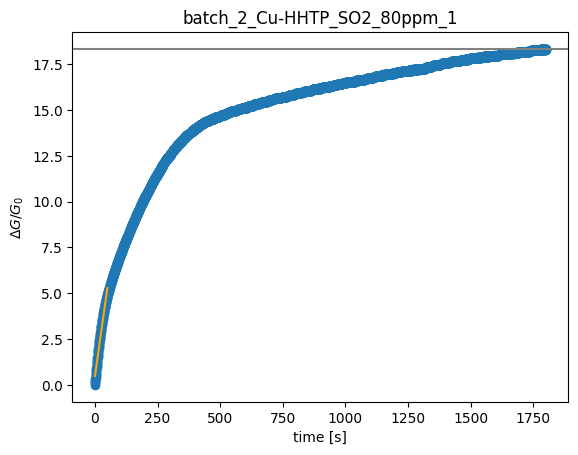

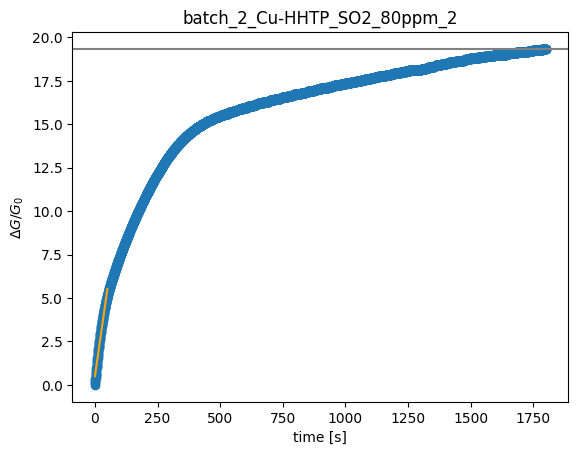

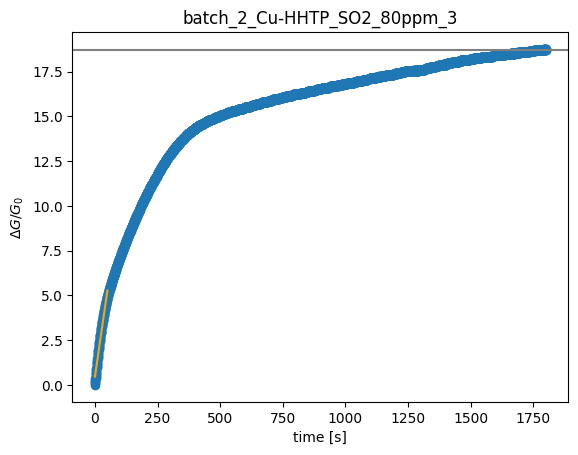

Error: replicate_id 4 does not exist for SO2  in Cu-HHTP at 80 ppm.
Error: replicate_id 5 does not exist for SO2  in Cu-HHTP at 80 ppm.
Error: replicate_id 6 does not exist for SO2  in Cu-HHTP at 80 ppm.
Error: replicate_id 7 does not exist for SO2  in Cu-HHTP at 80 ppm.
Error: replicate_id 0 does not exist for SO2  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 1 does not exist for SO2  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 2 does not exist for SO2  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 3 does not exist for SO2  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 4 does not exist for SO2  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 5 does not exist for SO2  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 6 does not exist for SO2  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 7 does not exist for SO2  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 0 does not exist for SO2  in Cu-HHTP at 5+5 ppm.
Error: replicate_id 1 does not exist for SO2  in Cu-HHTP at 5+5 ppm.
Error: replicate_id 2 does not

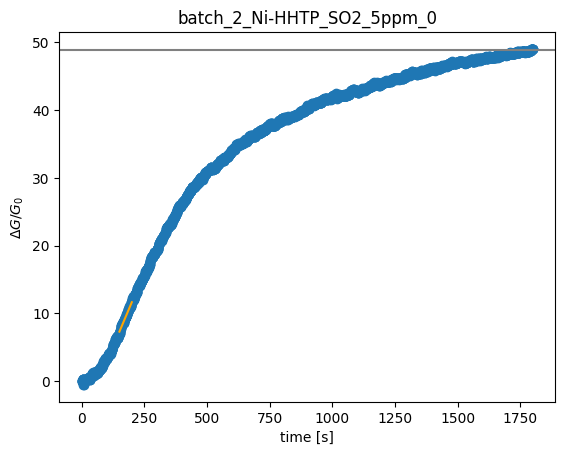

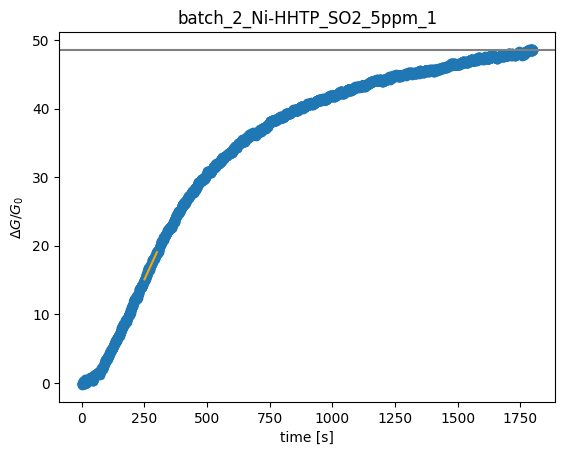

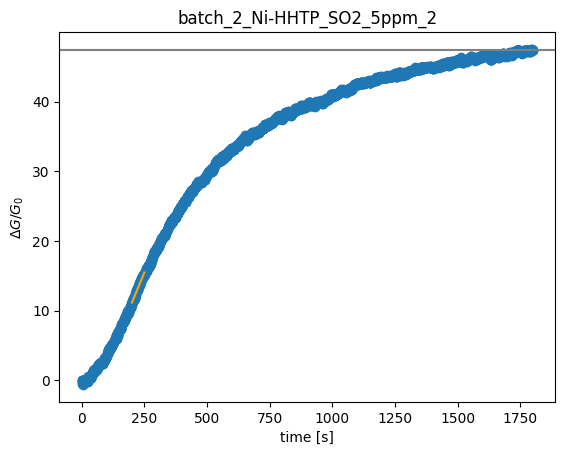

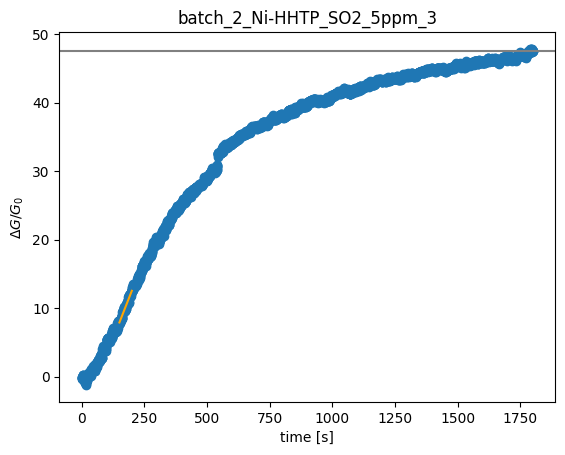

Error: replicate_id 4 does not exist for SO2  in Ni-HHTP at 5 ppm.
Error: replicate_id 5 does not exist for SO2  in Ni-HHTP at 5 ppm.
Error: replicate_id 6 does not exist for SO2  in Ni-HHTP at 5 ppm.
Error: replicate_id 7 does not exist for SO2  in Ni-HHTP at 5 ppm.


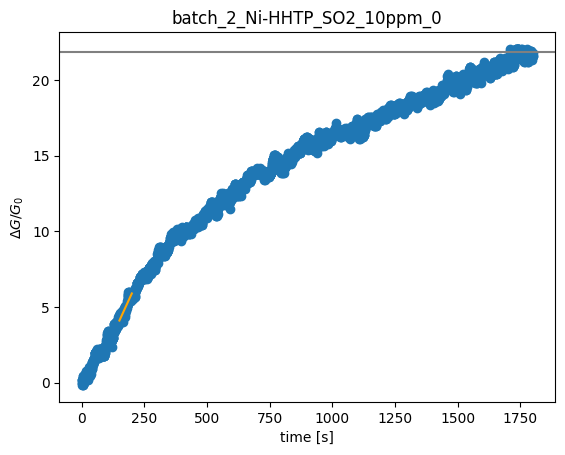

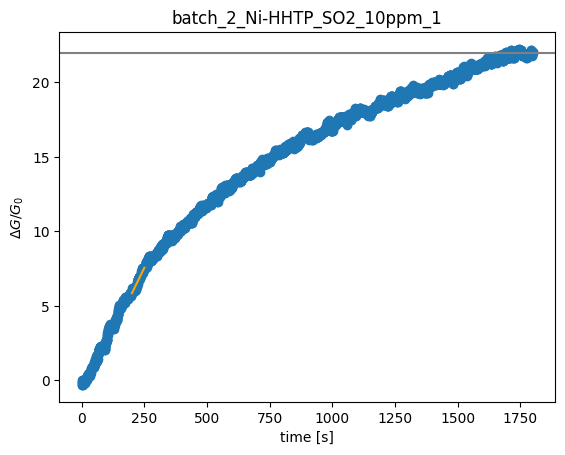

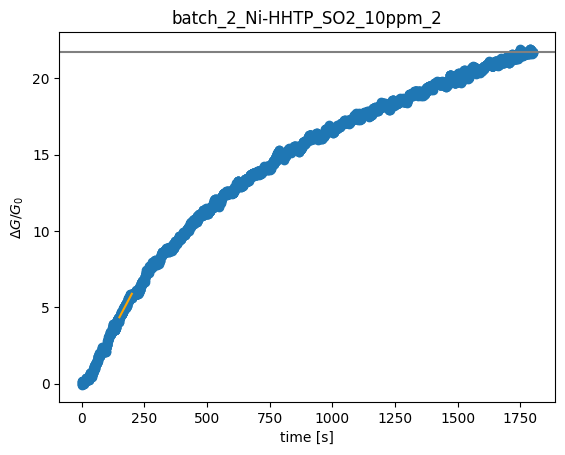

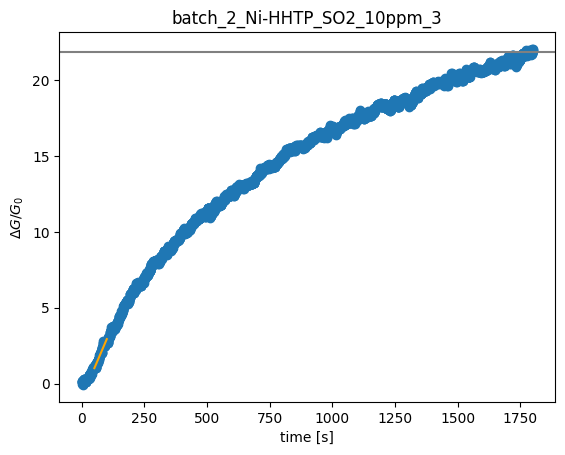

Error: replicate_id 4 does not exist for SO2  in Ni-HHTP at 10 ppm.
Error: replicate_id 5 does not exist for SO2  in Ni-HHTP at 10 ppm.
Error: replicate_id 6 does not exist for SO2  in Ni-HHTP at 10 ppm.
Error: replicate_id 7 does not exist for SO2  in Ni-HHTP at 10 ppm.


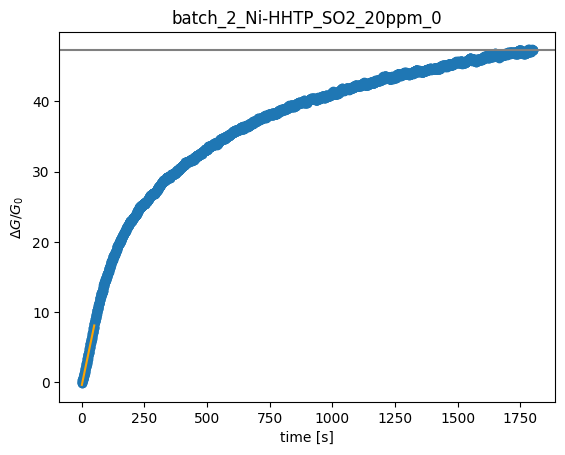

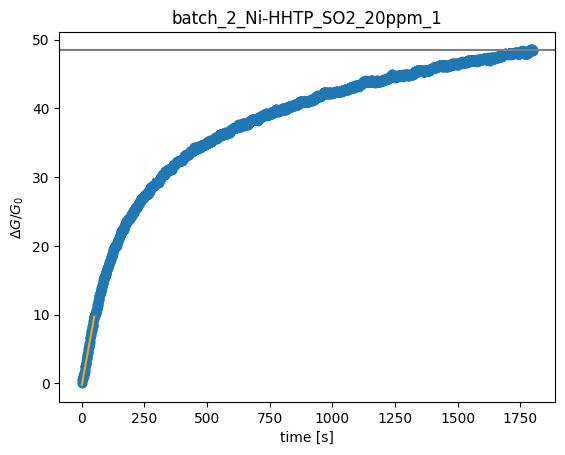

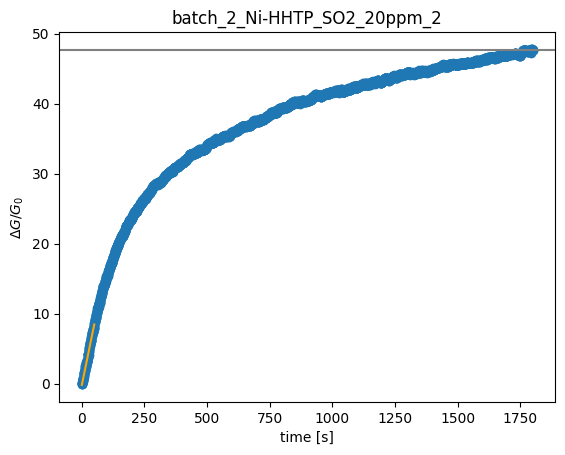

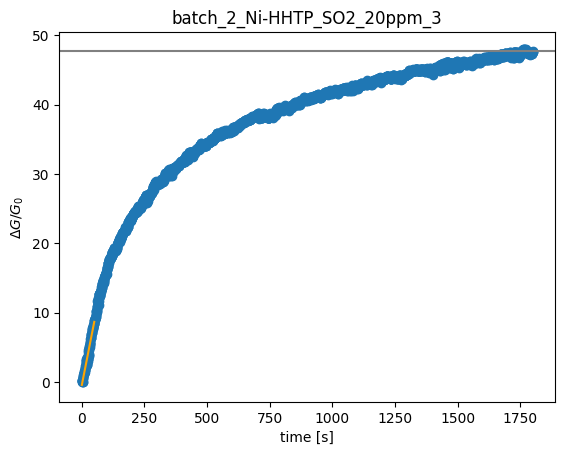

Error: replicate_id 4 does not exist for SO2  in Ni-HHTP at 20 ppm.
Error: replicate_id 5 does not exist for SO2  in Ni-HHTP at 20 ppm.
Error: replicate_id 6 does not exist for SO2  in Ni-HHTP at 20 ppm.
Error: replicate_id 7 does not exist for SO2  in Ni-HHTP at 20 ppm.


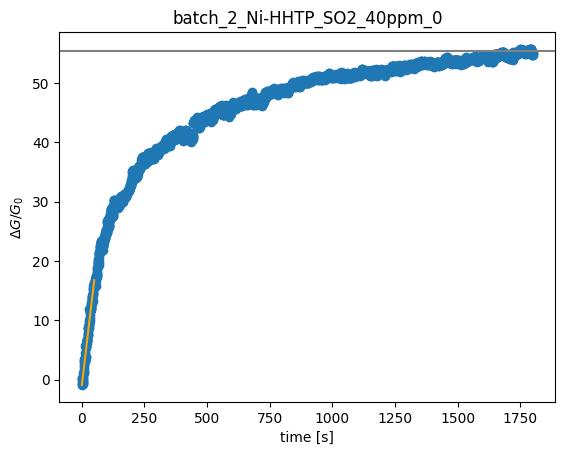

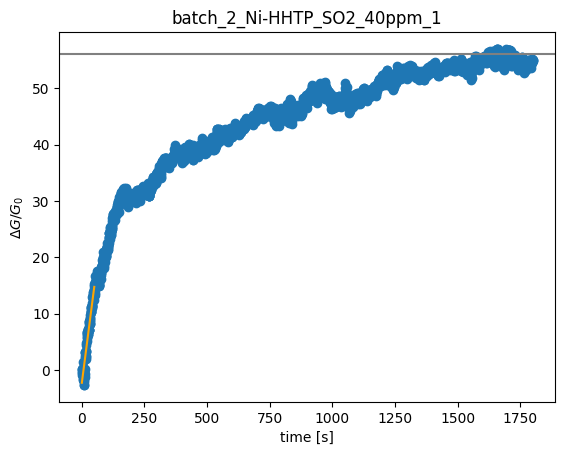

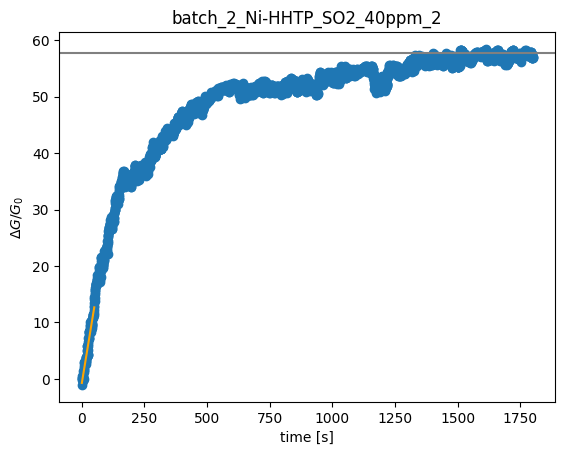

Error: replicate_id 3 does not exist for SO2  in Ni-HHTP at 40 ppm.
Error: replicate_id 4 does not exist for SO2  in Ni-HHTP at 40 ppm.
Error: replicate_id 5 does not exist for SO2  in Ni-HHTP at 40 ppm.
Error: replicate_id 6 does not exist for SO2  in Ni-HHTP at 40 ppm.
Error: replicate_id 7 does not exist for SO2  in Ni-HHTP at 40 ppm.


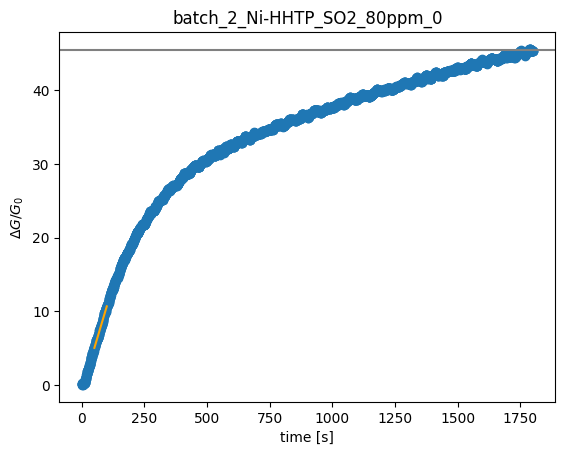

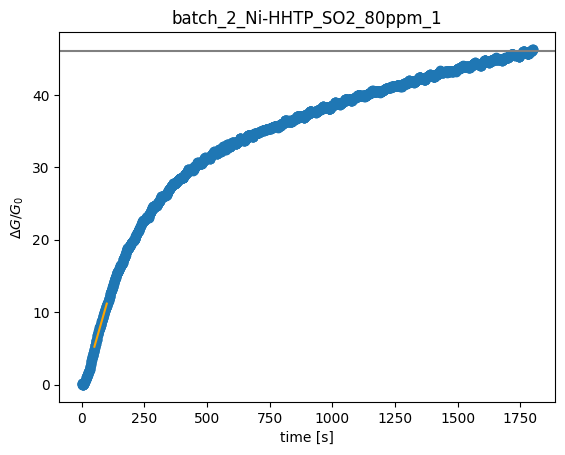

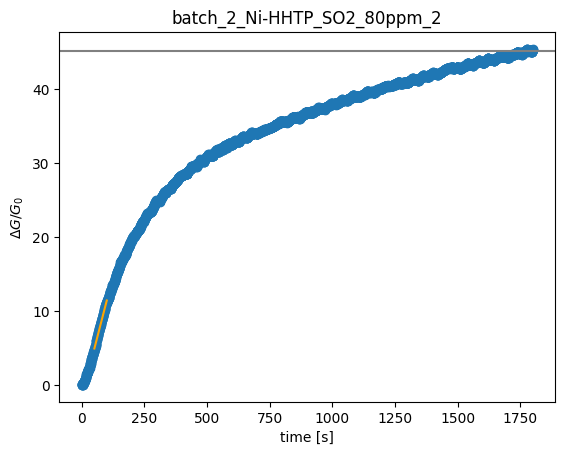

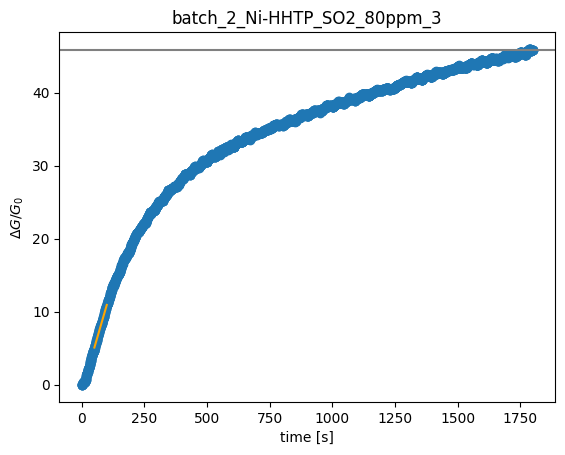

Error: replicate_id 4 does not exist for SO2  in Ni-HHTP at 80 ppm.
Error: replicate_id 5 does not exist for SO2  in Ni-HHTP at 80 ppm.
Error: replicate_id 6 does not exist for SO2  in Ni-HHTP at 80 ppm.
Error: replicate_id 7 does not exist for SO2  in Ni-HHTP at 80 ppm.
Error: replicate_id 0 does not exist for SO2  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 1 does not exist for SO2  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 2 does not exist for SO2  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 3 does not exist for SO2  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 4 does not exist for SO2  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 5 does not exist for SO2  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 6 does not exist for SO2  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 7 does not exist for SO2  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 0 does not exist for SO2  in Ni-HHTP at 5+5 ppm.
Error: replicate_id 1 does not exist for SO2  in Ni-HHTP at 5+5 ppm.
Error: replicate_id 2 does not

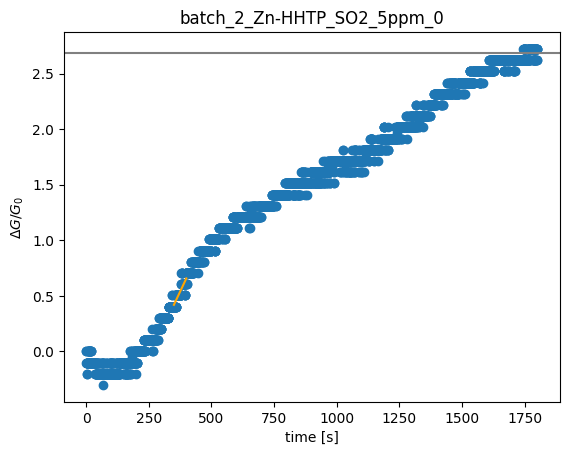

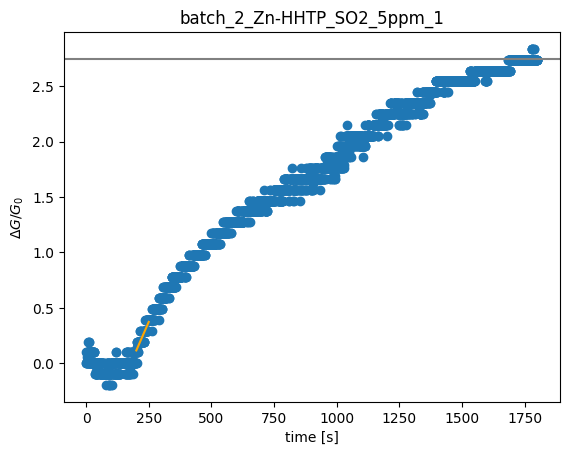

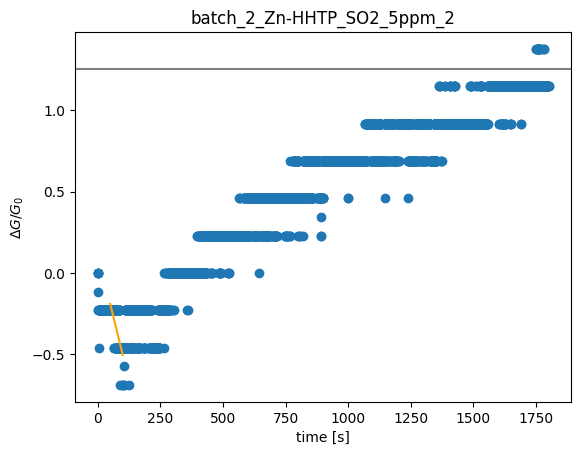

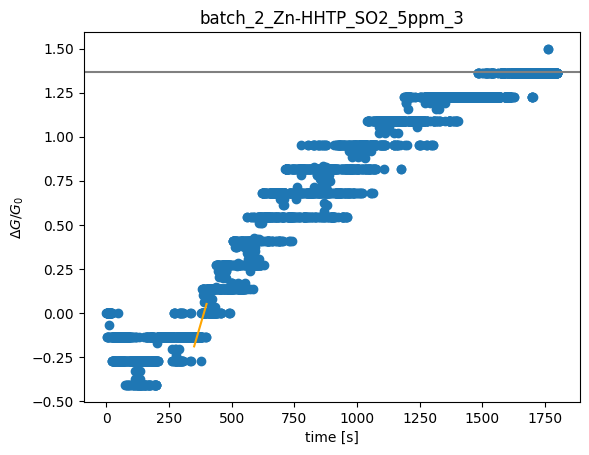

Error: replicate_id 4 does not exist for SO2  in Zn-HHTP at 5 ppm.
Error: replicate_id 5 does not exist for SO2  in Zn-HHTP at 5 ppm.
Error: replicate_id 6 does not exist for SO2  in Zn-HHTP at 5 ppm.
Error: replicate_id 7 does not exist for SO2  in Zn-HHTP at 5 ppm.


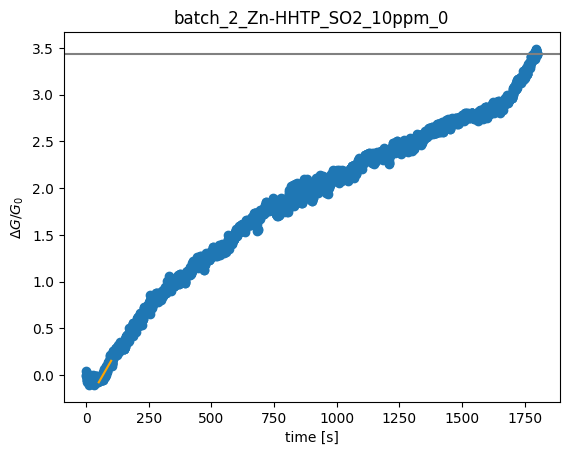

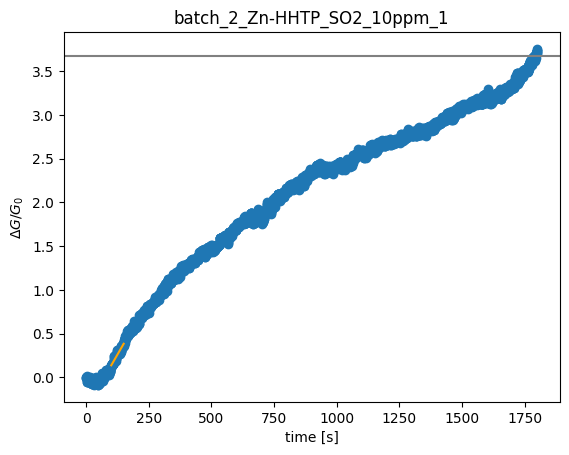

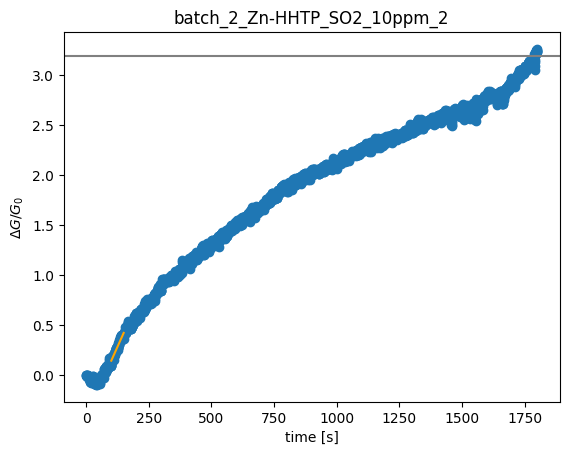

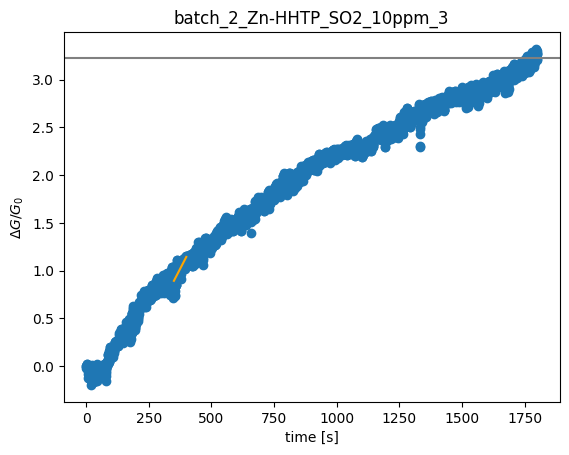

Error: replicate_id 4 does not exist for SO2  in Zn-HHTP at 10 ppm.
Error: replicate_id 5 does not exist for SO2  in Zn-HHTP at 10 ppm.
Error: replicate_id 6 does not exist for SO2  in Zn-HHTP at 10 ppm.
Error: replicate_id 7 does not exist for SO2  in Zn-HHTP at 10 ppm.


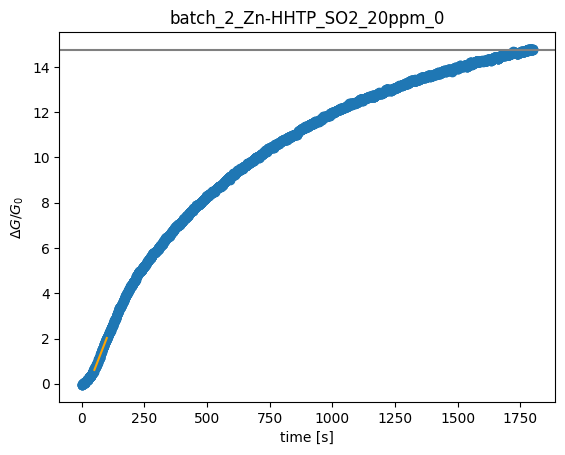

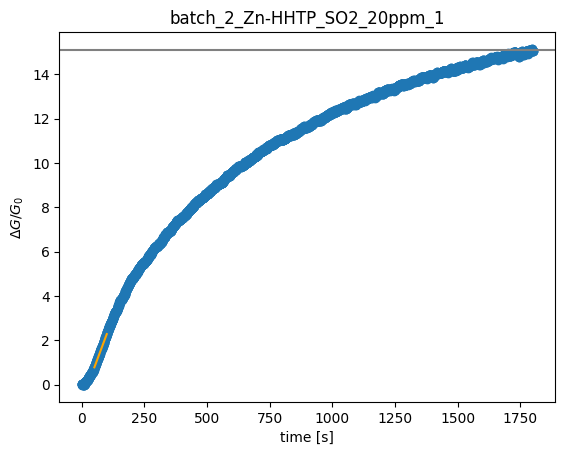

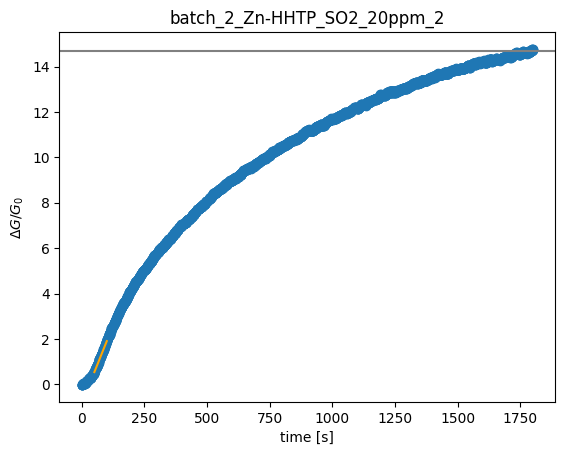

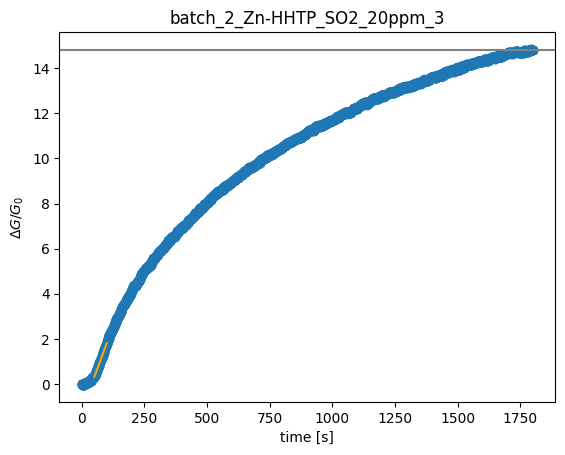

Error: replicate_id 4 does not exist for SO2  in Zn-HHTP at 20 ppm.
Error: replicate_id 5 does not exist for SO2  in Zn-HHTP at 20 ppm.
Error: replicate_id 6 does not exist for SO2  in Zn-HHTP at 20 ppm.
Error: replicate_id 7 does not exist for SO2  in Zn-HHTP at 20 ppm.


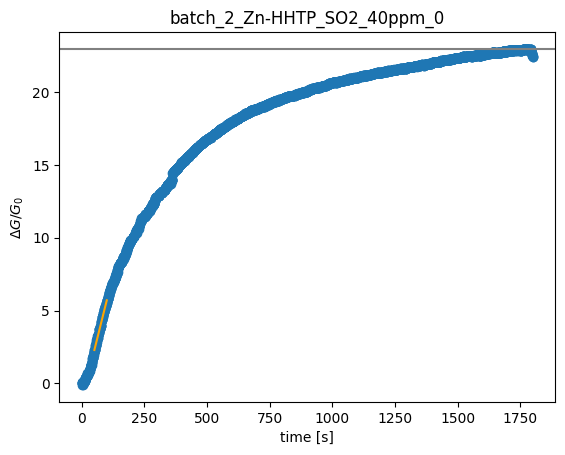

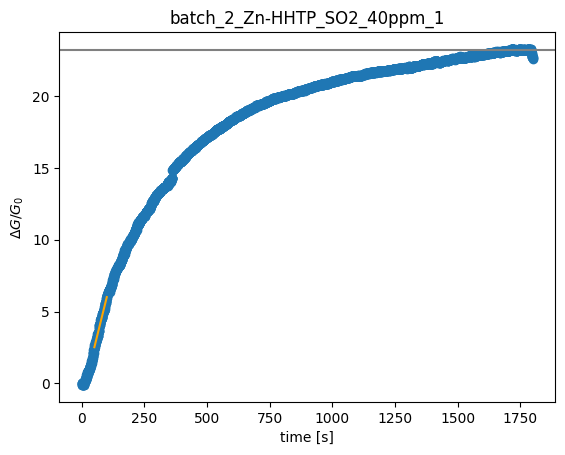

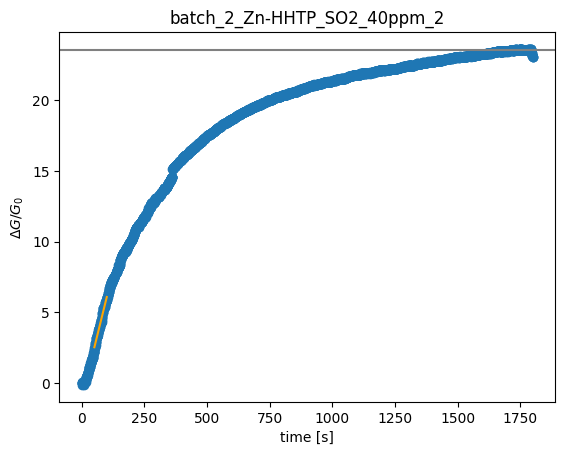

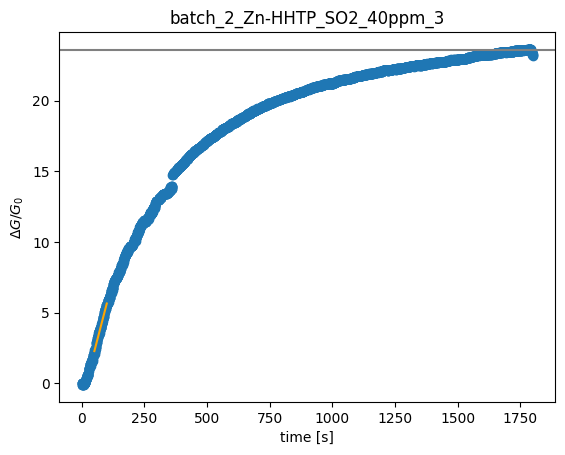

Error: replicate_id 4 does not exist for SO2  in Zn-HHTP at 40 ppm.
Error: replicate_id 5 does not exist for SO2  in Zn-HHTP at 40 ppm.
Error: replicate_id 6 does not exist for SO2  in Zn-HHTP at 40 ppm.
Error: replicate_id 7 does not exist for SO2  in Zn-HHTP at 40 ppm.


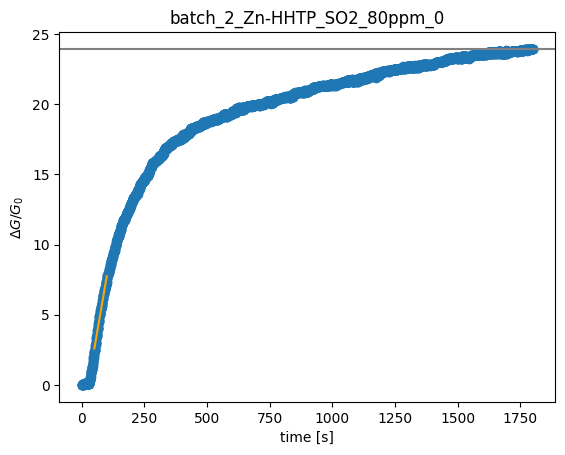

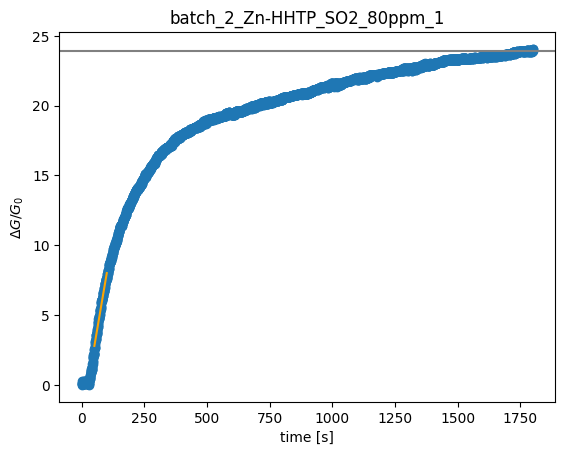

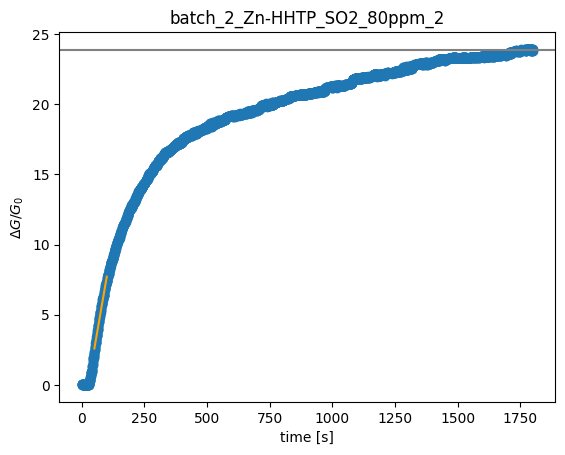

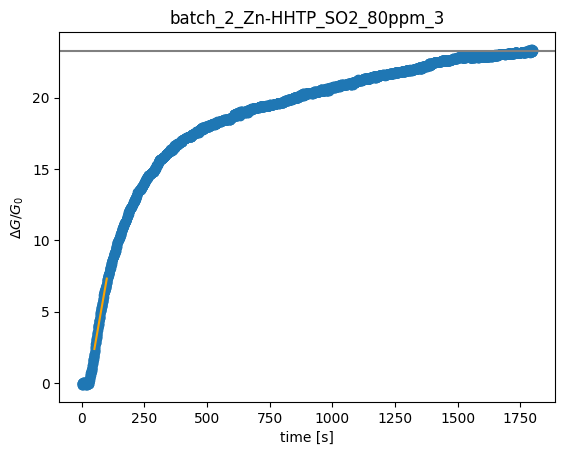

Error: replicate_id 4 does not exist for SO2  in Zn-HHTP at 80 ppm.
Error: replicate_id 5 does not exist for SO2  in Zn-HHTP at 80 ppm.
Error: replicate_id 6 does not exist for SO2  in Zn-HHTP at 80 ppm.
Error: replicate_id 7 does not exist for SO2  in Zn-HHTP at 80 ppm.
Error: replicate_id 0 does not exist for SO2  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 1 does not exist for SO2  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 2 does not exist for SO2  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 3 does not exist for SO2  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 4 does not exist for SO2  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 5 does not exist for SO2  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 6 does not exist for SO2  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 7 does not exist for SO2  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 0 does not exist for SO2  in Zn-HHTP at 5+5 ppm.
Error: replicate_id 1 does not exist for SO2  in Zn-HHTP at 5+5 ppm.
Error: replicate_id 2 does not

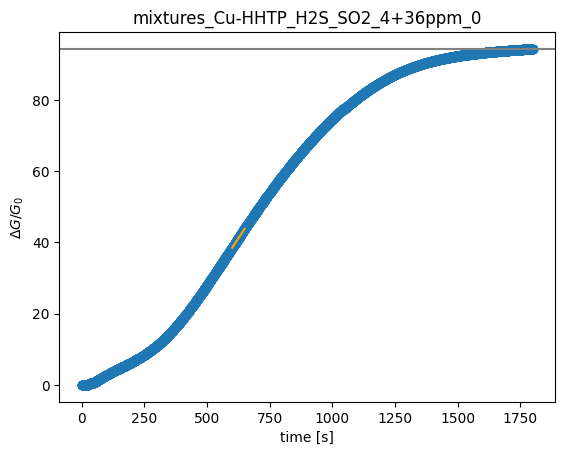

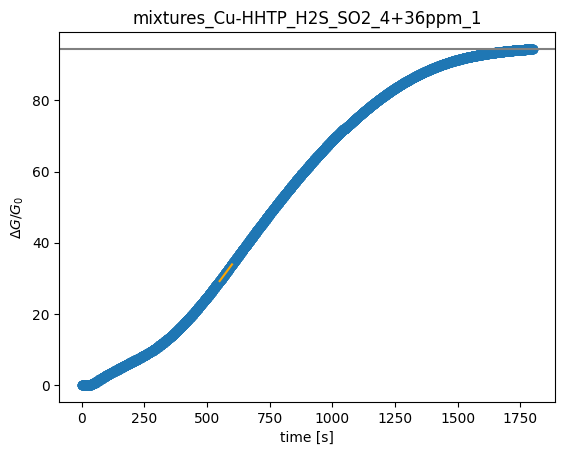

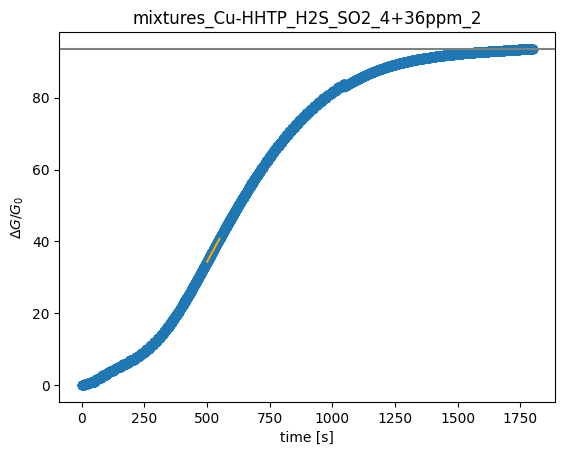

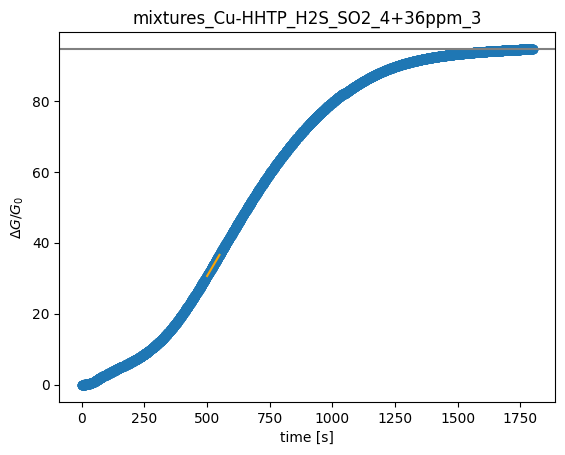

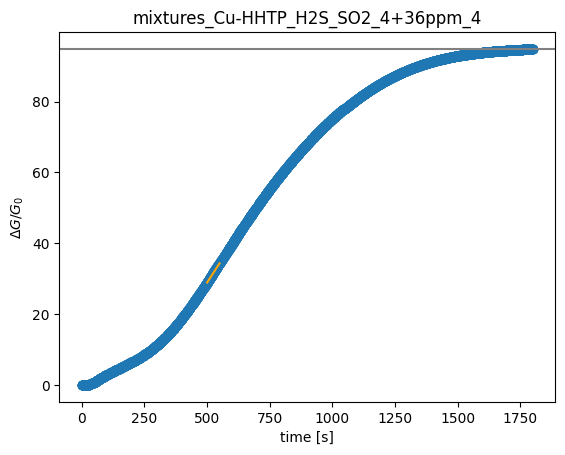

Error: replicate_id 5 does not exist for H2S_SO2  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Cu-HHTP at 4+36 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Cu-HHTP at 4+36 ppm.


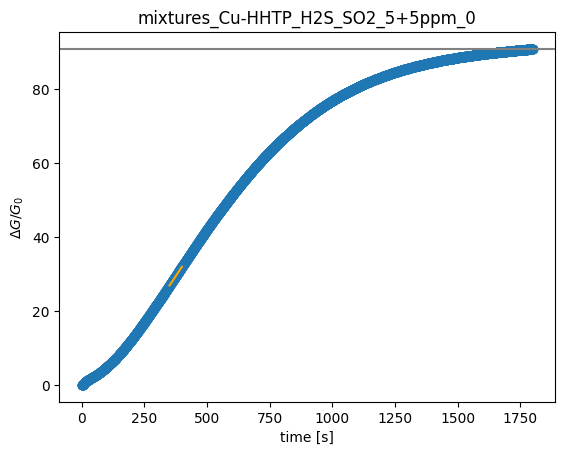

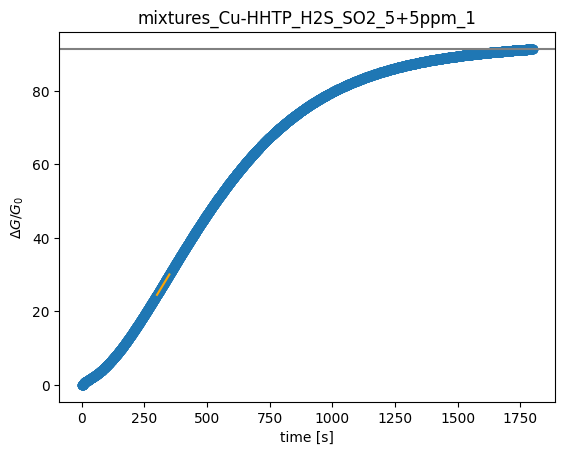

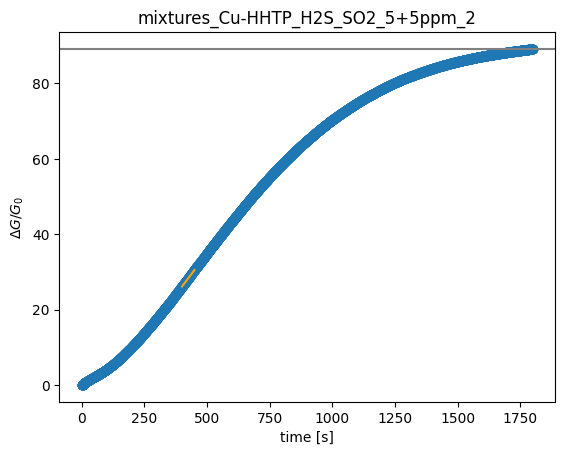

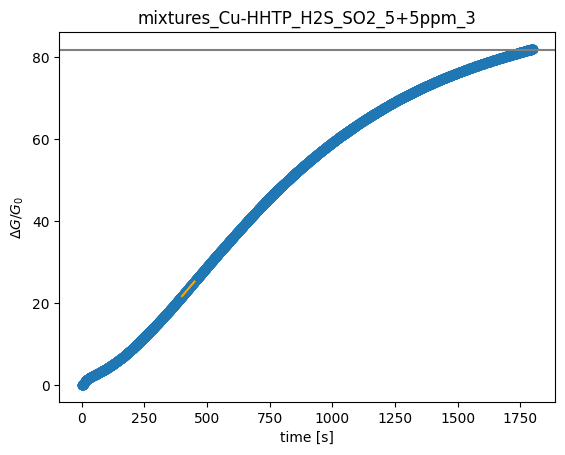

Error: replicate_id 4 does not exist for H2S_SO2  in Cu-HHTP at 5+5 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Cu-HHTP at 5+5 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Cu-HHTP at 5+5 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Cu-HHTP at 5+5 ppm.


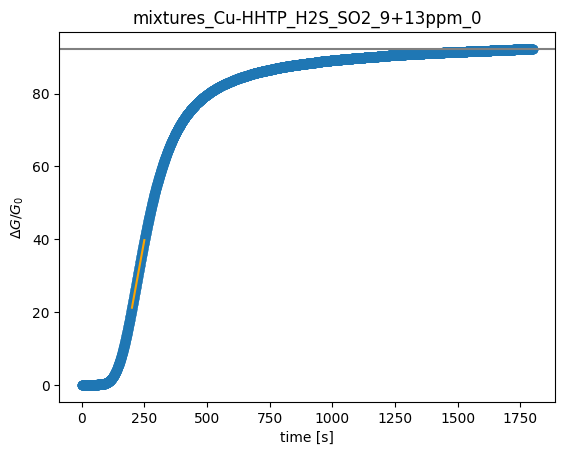

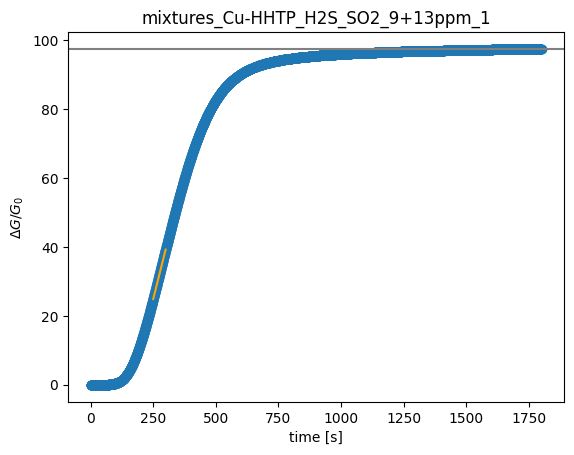

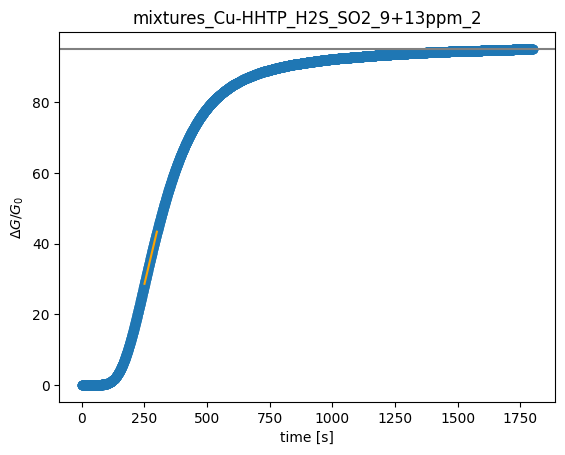

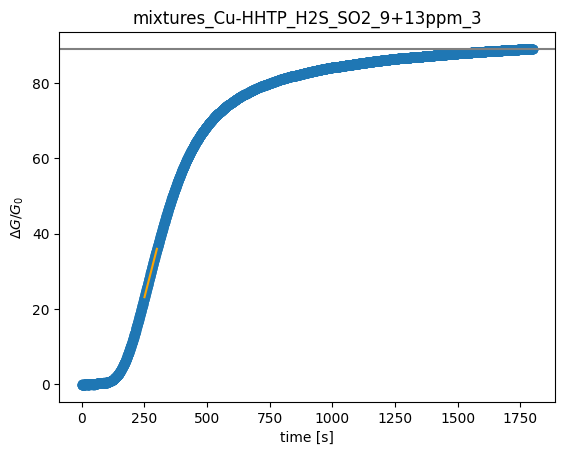

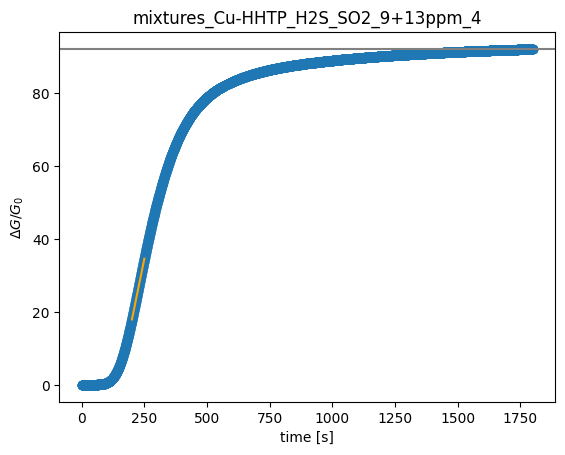

Error: replicate_id 5 does not exist for H2S_SO2  in Cu-HHTP at 9+13 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Cu-HHTP at 9+13 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Cu-HHTP at 9+13 ppm.


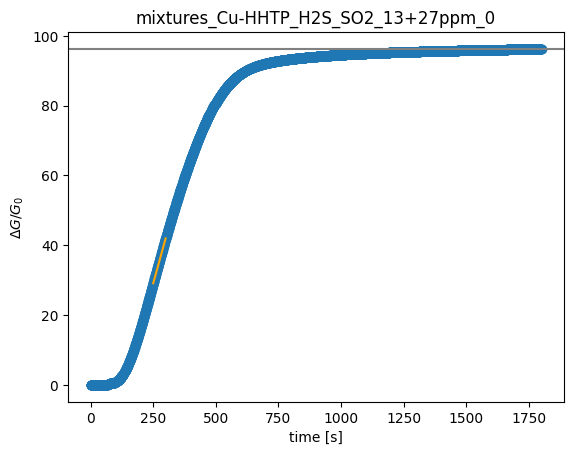

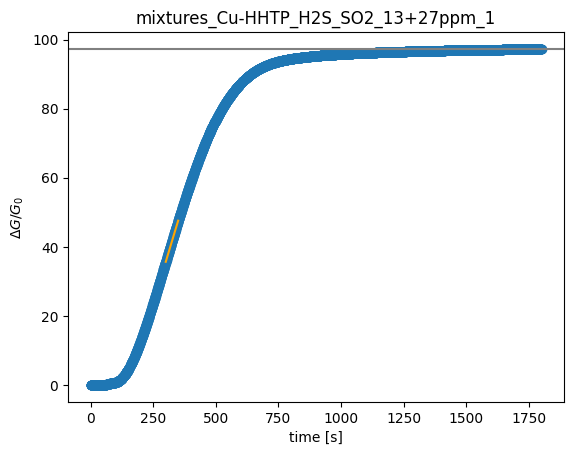

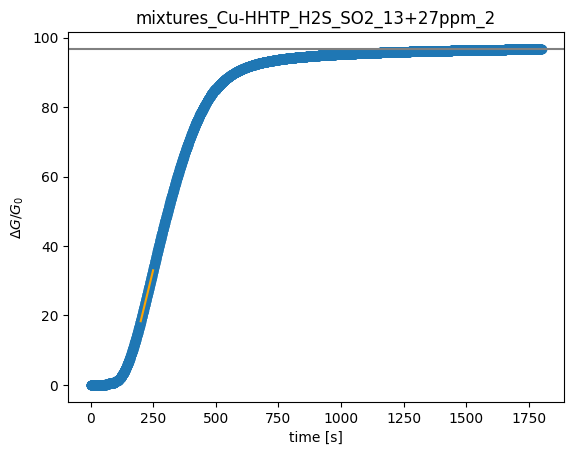

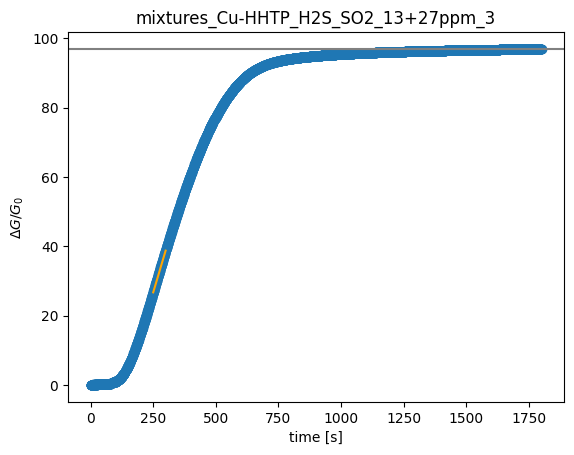

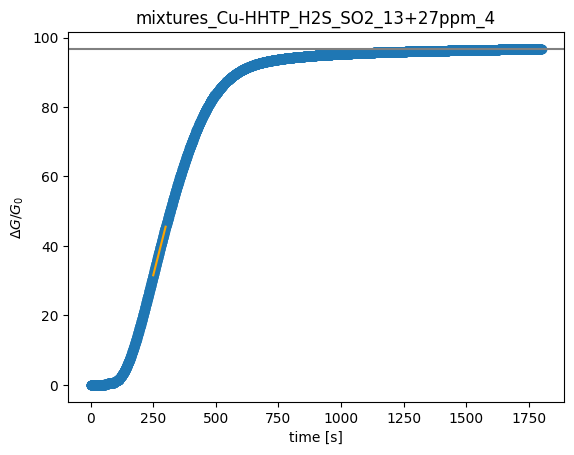

Error: replicate_id 5 does not exist for H2S_SO2  in Cu-HHTP at 13+27 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Cu-HHTP at 13+27 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Cu-HHTP at 13+27 ppm.


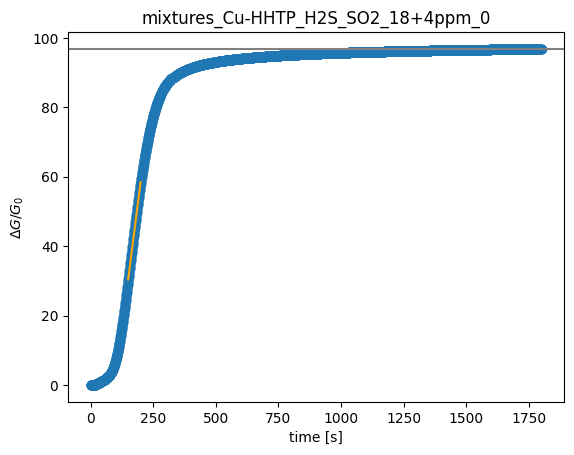

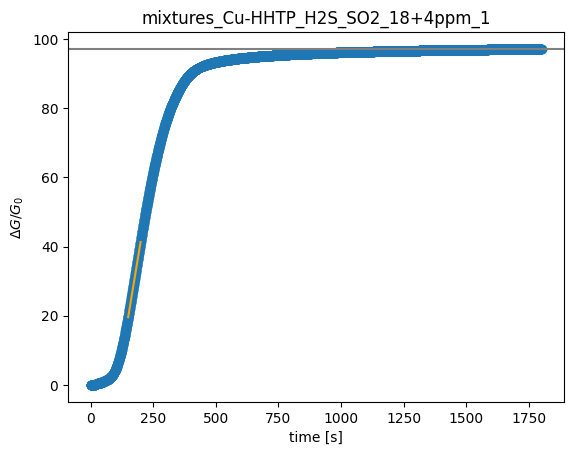

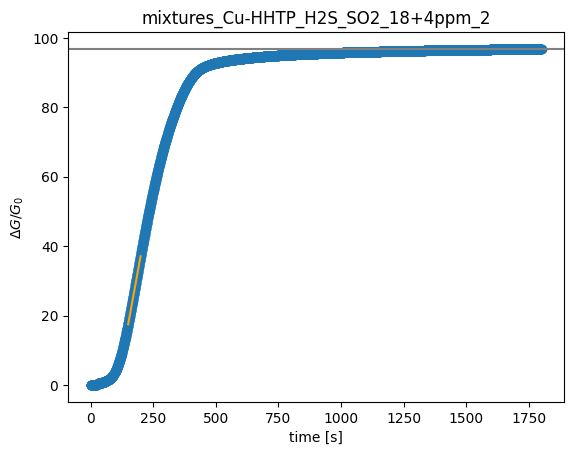

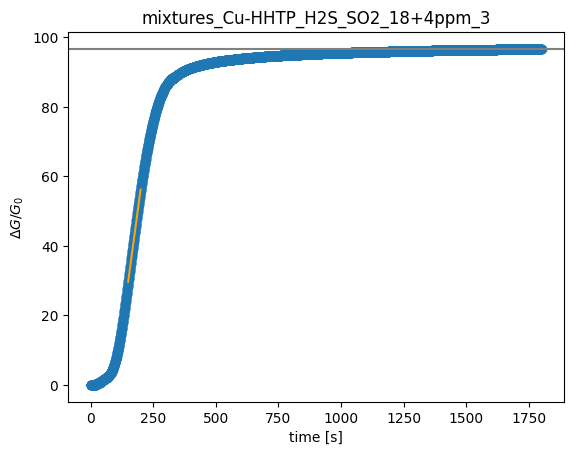

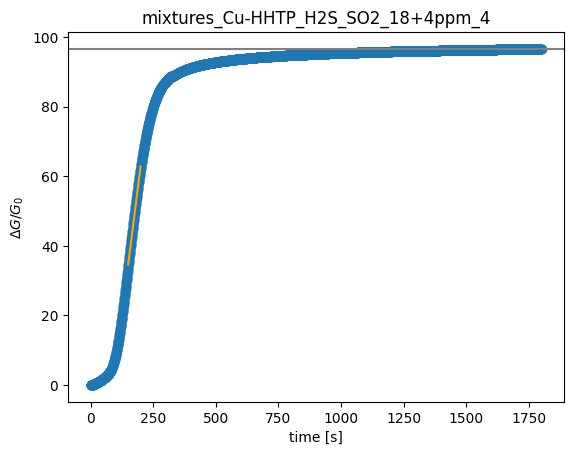

Error: replicate_id 5 does not exist for H2S_SO2  in Cu-HHTP at 18+4 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Cu-HHTP at 18+4 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Cu-HHTP at 18+4 ppm.


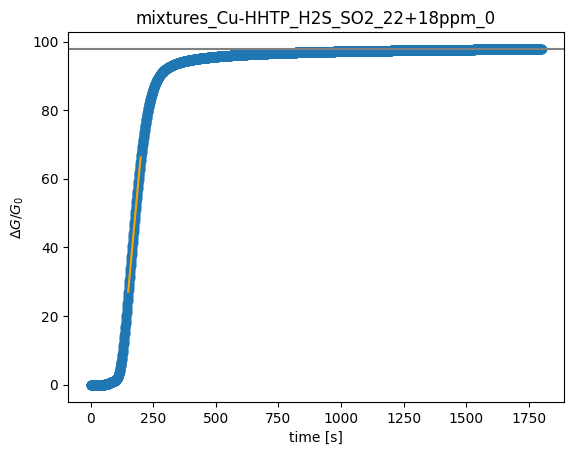

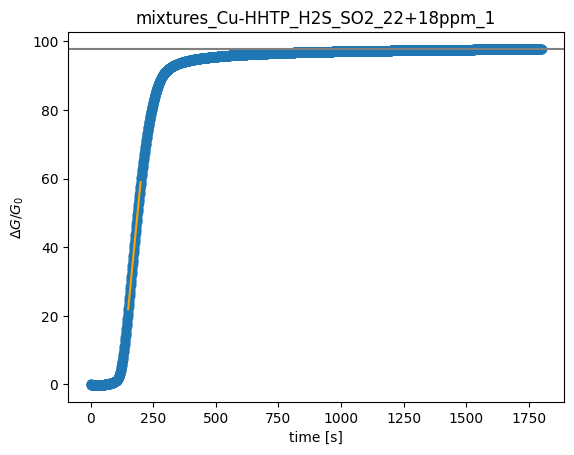

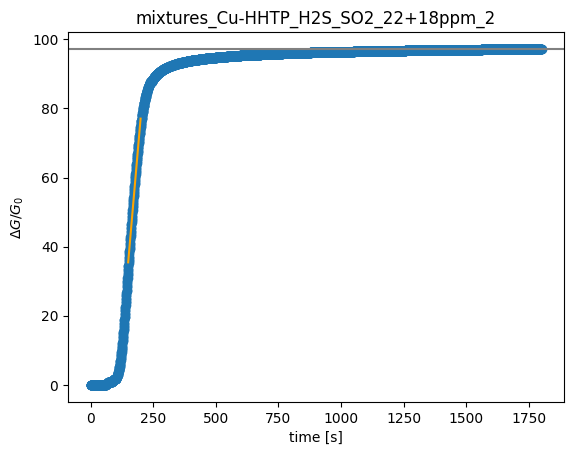

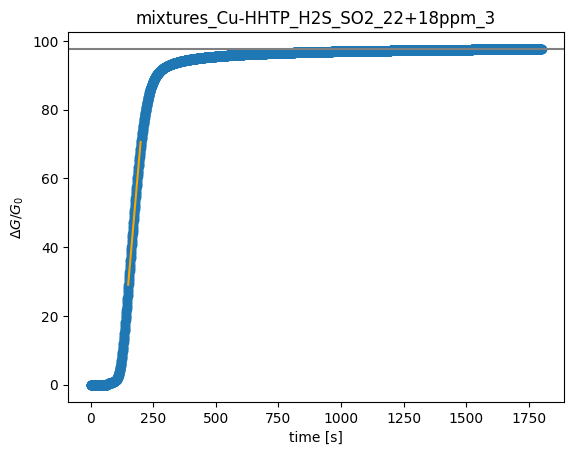

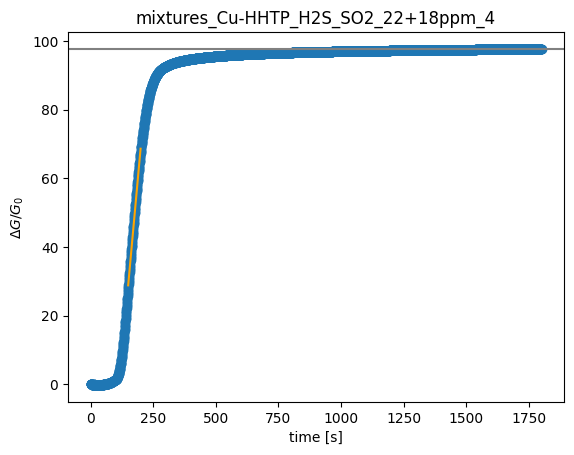

Error: replicate_id 5 does not exist for H2S_SO2  in Cu-HHTP at 22+18 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Cu-HHTP at 22+18 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Cu-HHTP at 22+18 ppm.


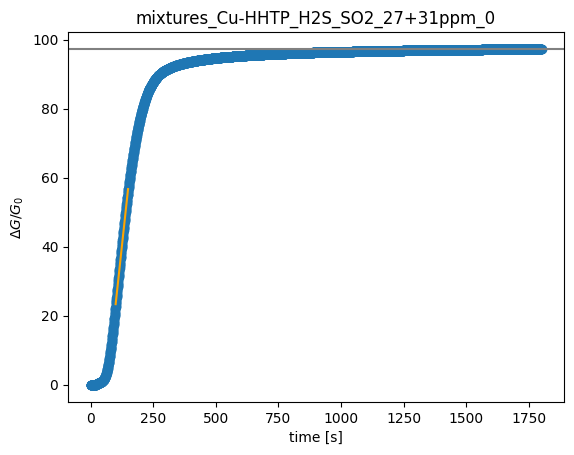

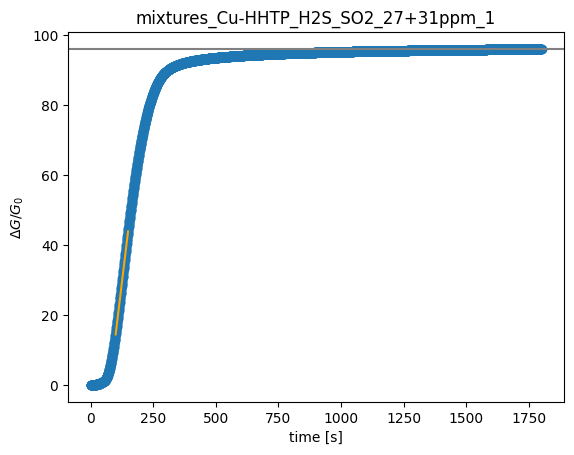

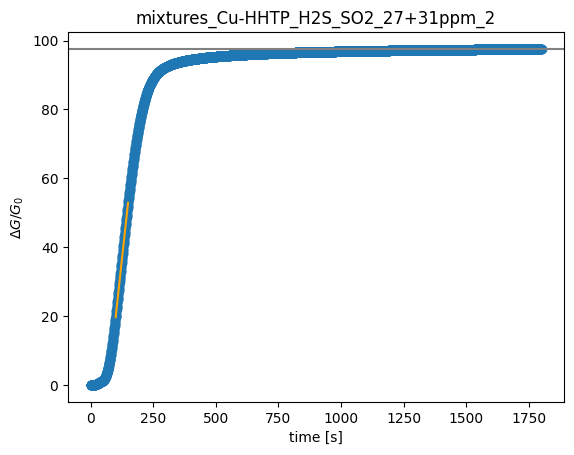

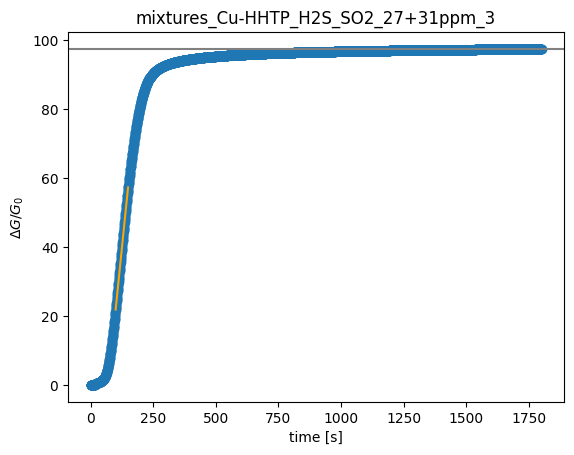

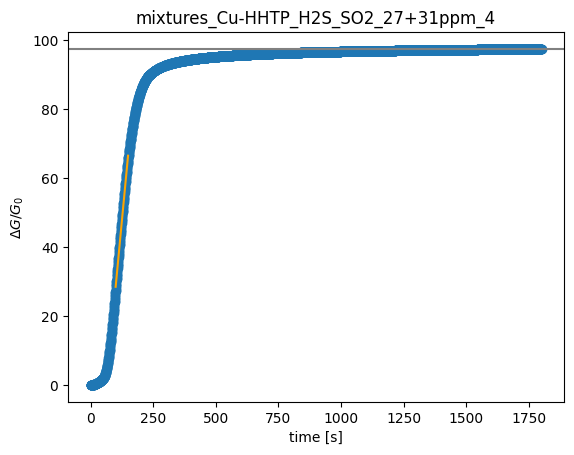

Error: replicate_id 5 does not exist for H2S_SO2  in Cu-HHTP at 27+31 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Cu-HHTP at 27+31 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Cu-HHTP at 27+31 ppm.


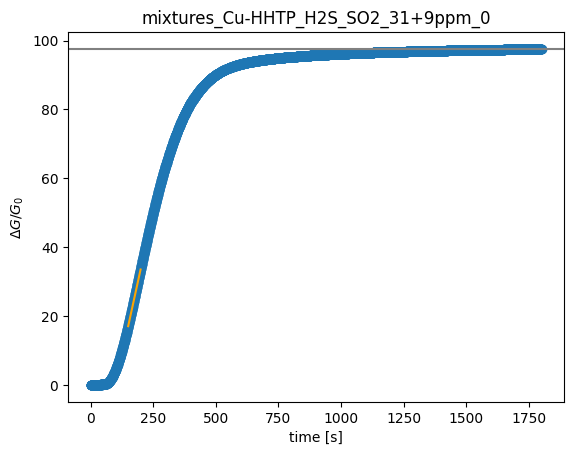

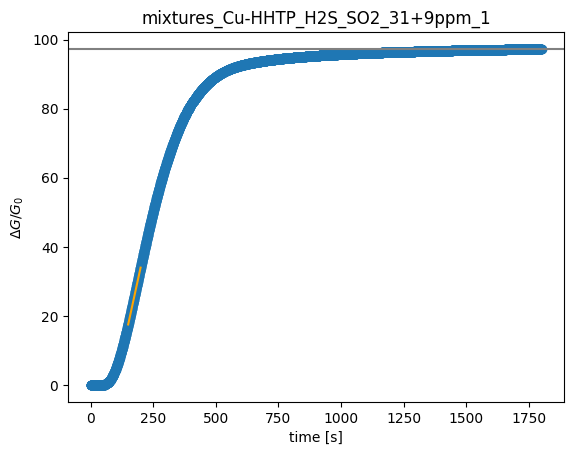

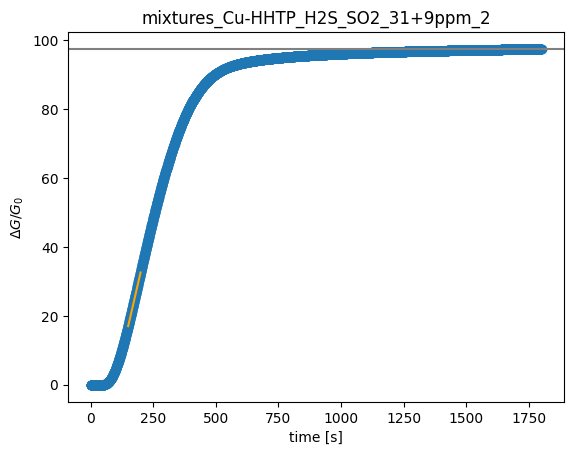

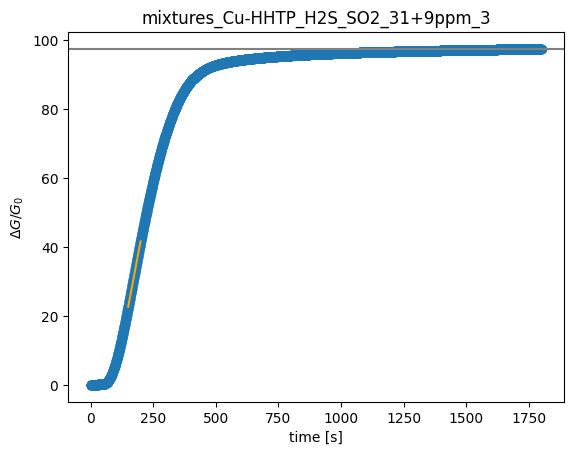

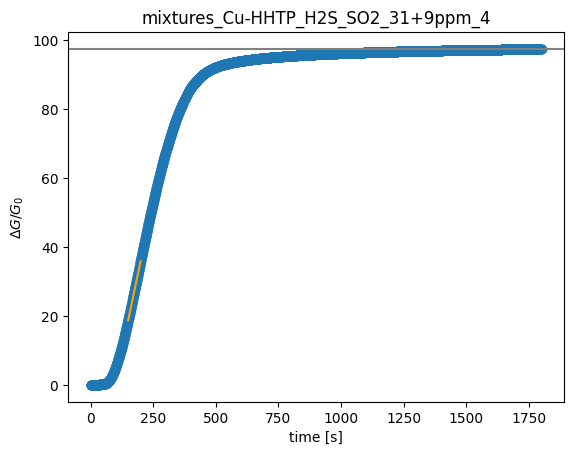

Error: replicate_id 5 does not exist for H2S_SO2  in Cu-HHTP at 31+9 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Cu-HHTP at 31+9 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Cu-HHTP at 31+9 ppm.


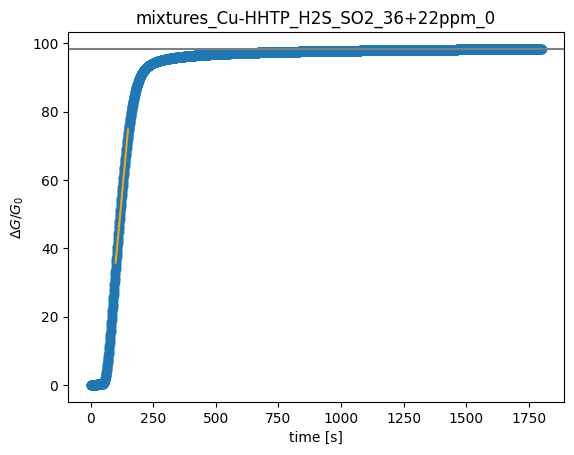

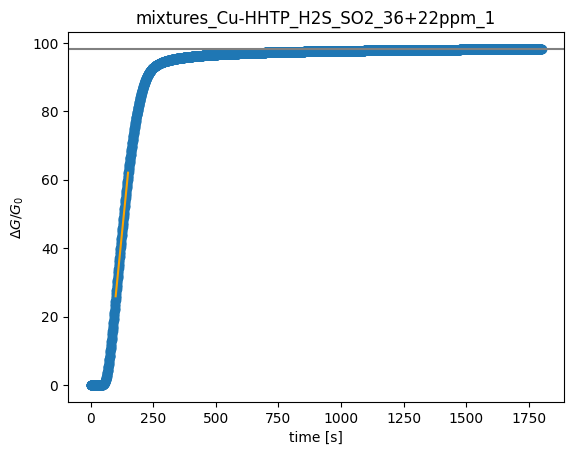

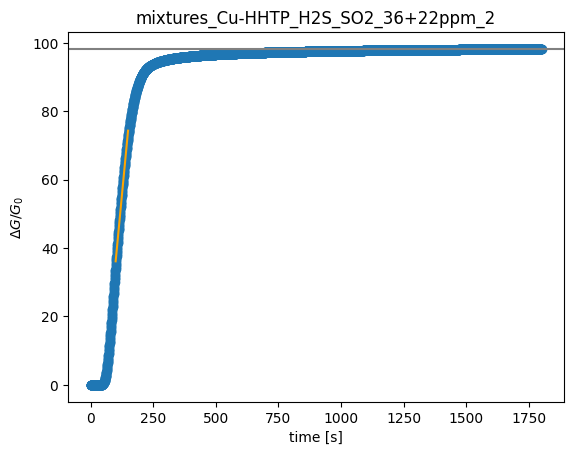

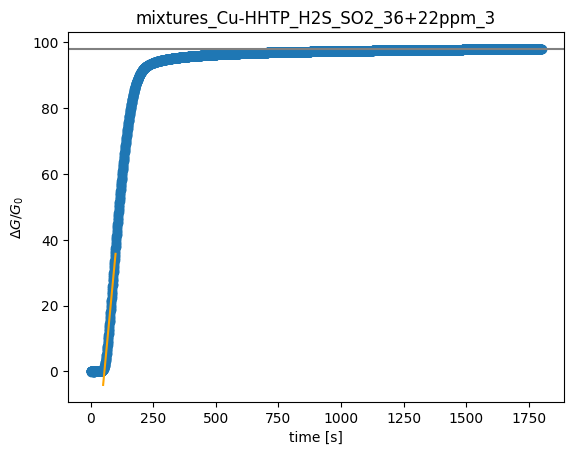

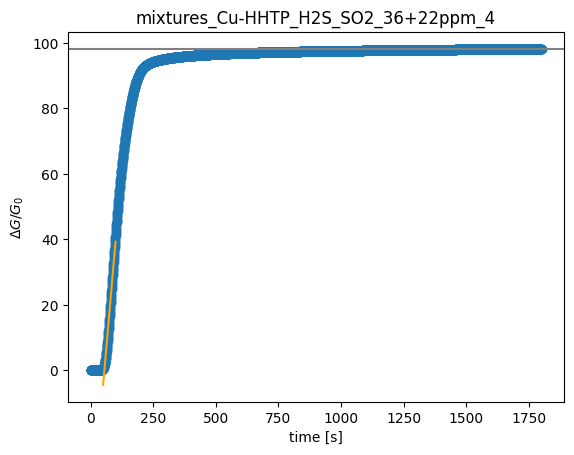

Error: replicate_id 5 does not exist for H2S_SO2  in Cu-HHTP at 36+22 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Cu-HHTP at 36+22 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Cu-HHTP at 36+22 ppm.


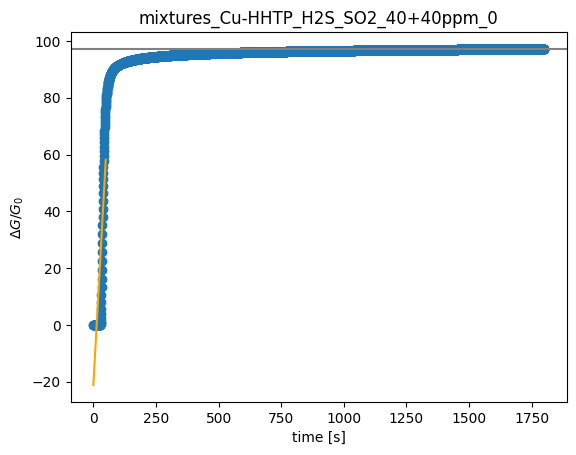

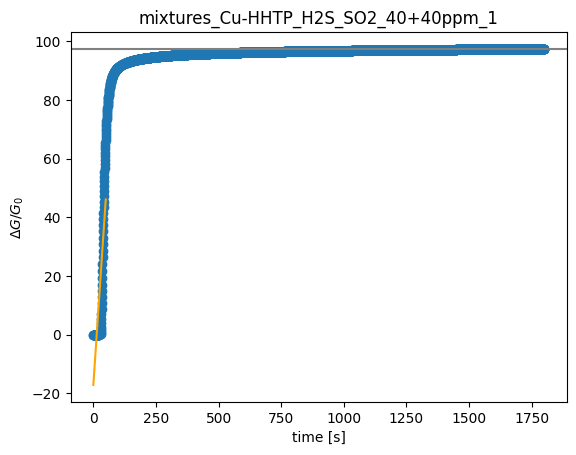

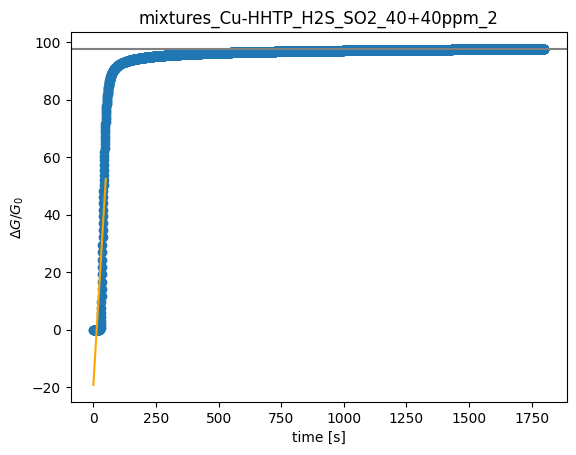

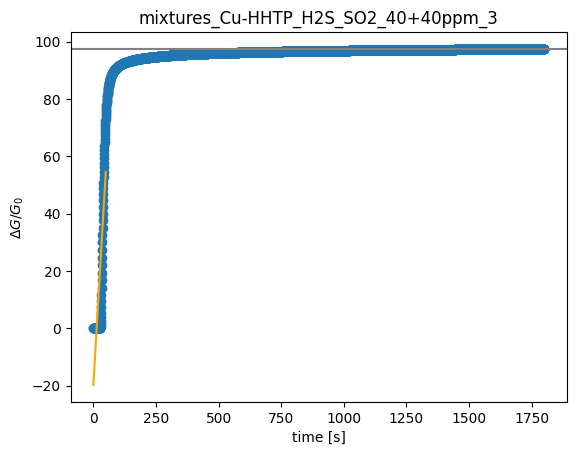

Error: replicate_id 4 does not exist for H2S_SO2  in Cu-HHTP at 40+40 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Cu-HHTP at 40+40 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Cu-HHTP at 40+40 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Cu-HHTP at 40+40 ppm.
Error: replicate_id 0 does not exist for H2S_SO2  in Ni-HHTP at 0.5 ppm.
Error: replicate_id 1 does not exist for H2S_SO2  in Ni-HHTP at 0.5 ppm.
Error: replicate_id 2 does not exist for H2S_SO2  in Ni-HHTP at 0.5 ppm.
Error: replicate_id 3 does not exist for H2S_SO2  in Ni-HHTP at 0.5 ppm.
Error: replicate_id 4 does not exist for H2S_SO2  in Ni-HHTP at 0.5 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Ni-HHTP at 0.5 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Ni-HHTP at 0.5 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Ni-HHTP at 0.5 ppm.
Error: replicate_id 0 does not exist for H2S_SO2  in Ni-HHTP at 5 ppm.
Error: replicate_id 1 does not exist for H2S_

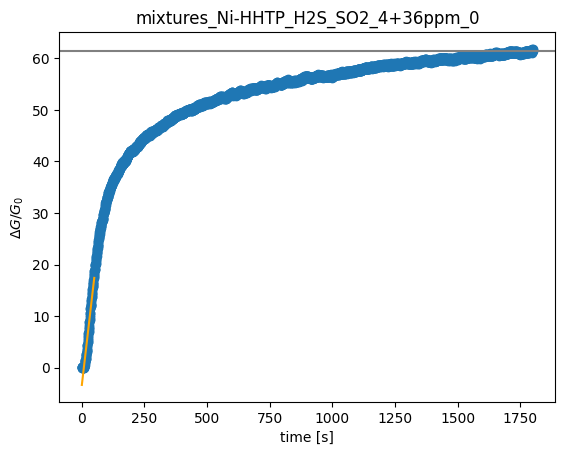

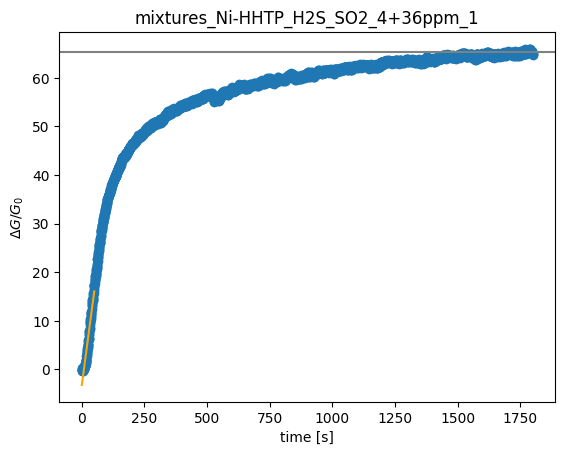

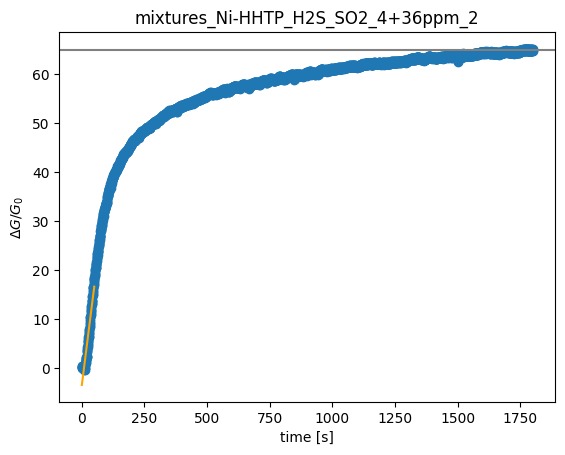

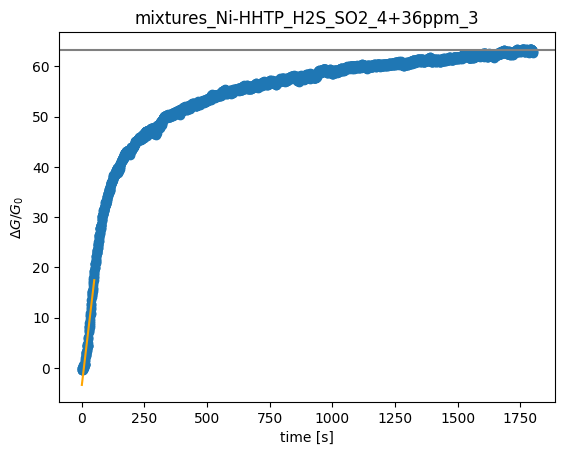

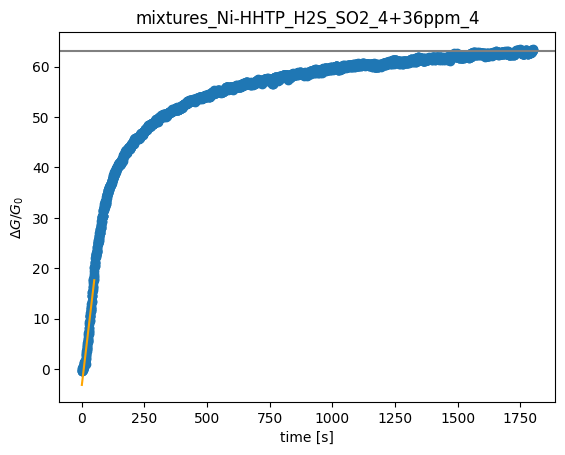

Error: replicate_id 5 does not exist for H2S_SO2  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Ni-HHTP at 4+36 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Ni-HHTP at 4+36 ppm.


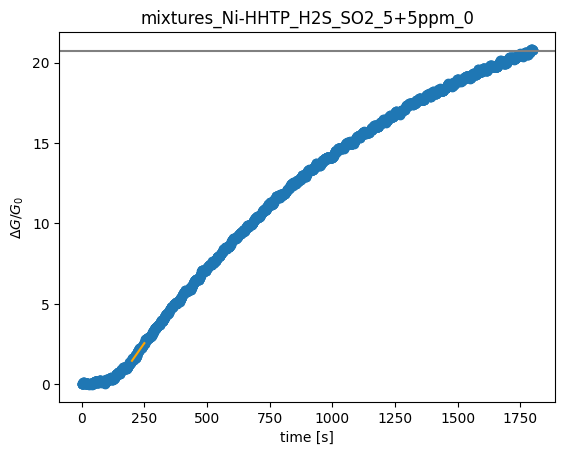

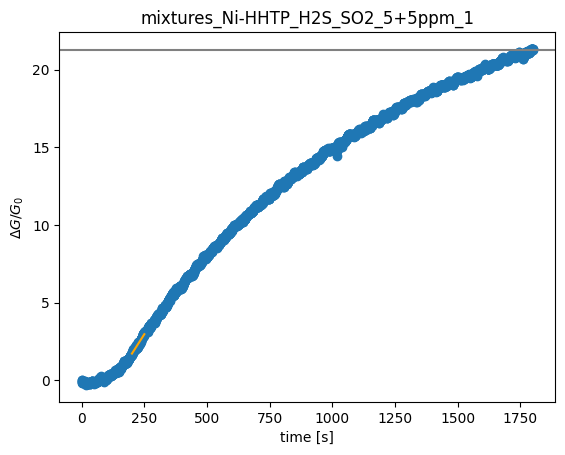

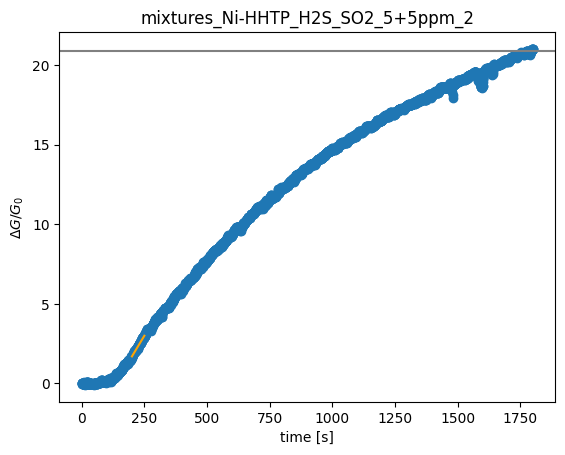

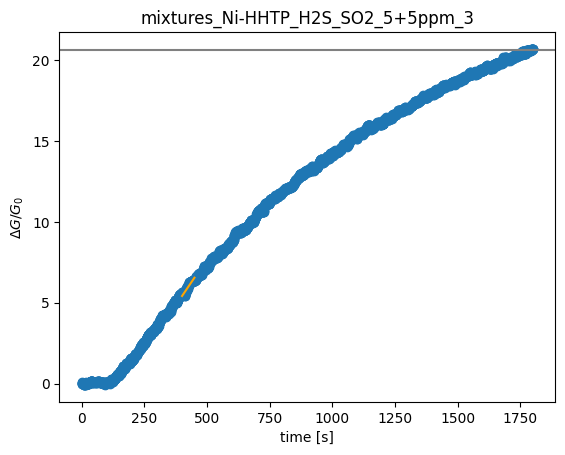

Error: replicate_id 4 does not exist for H2S_SO2  in Ni-HHTP at 5+5 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Ni-HHTP at 5+5 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Ni-HHTP at 5+5 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Ni-HHTP at 5+5 ppm.


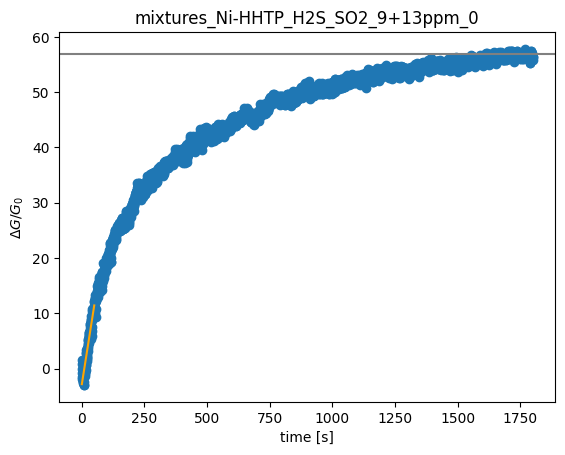

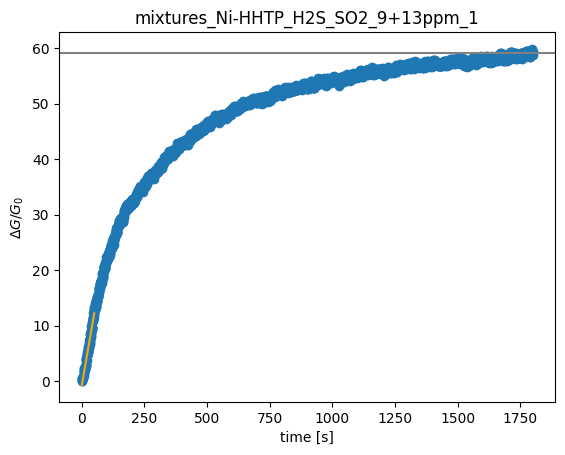

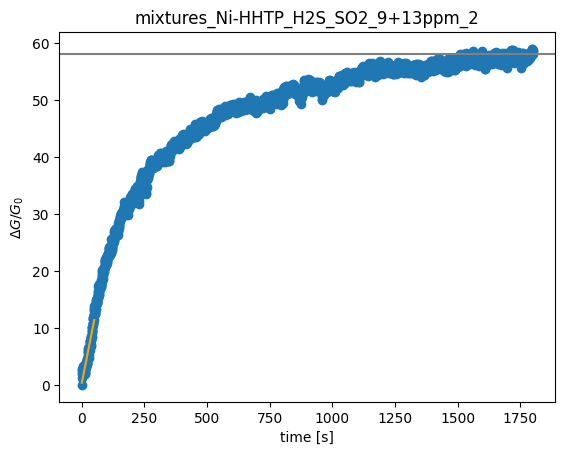

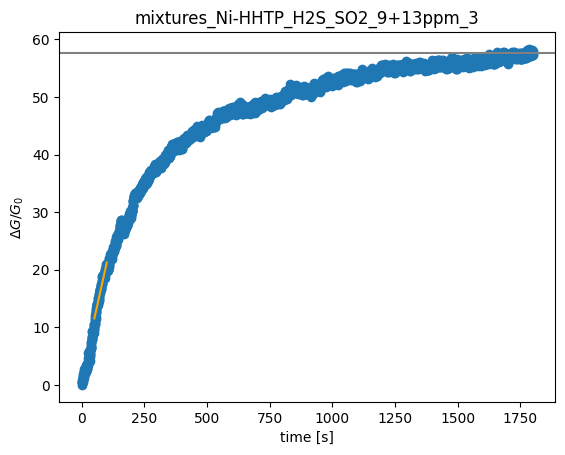

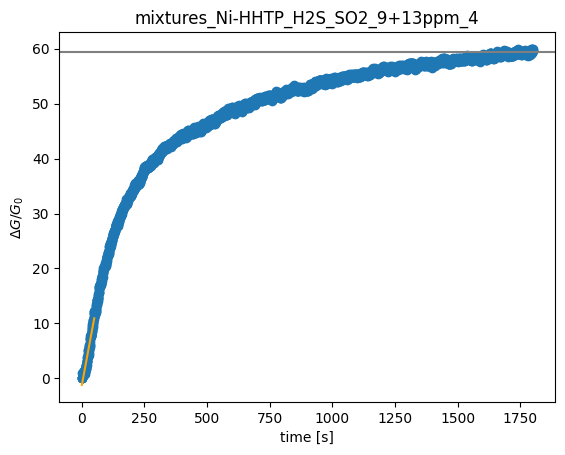

Error: replicate_id 5 does not exist for H2S_SO2  in Ni-HHTP at 9+13 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Ni-HHTP at 9+13 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Ni-HHTP at 9+13 ppm.


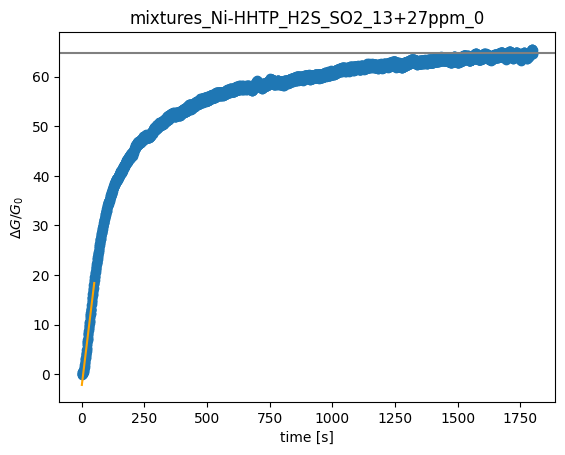

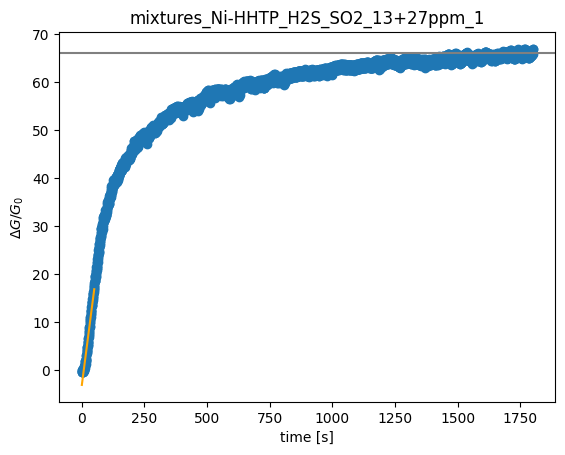

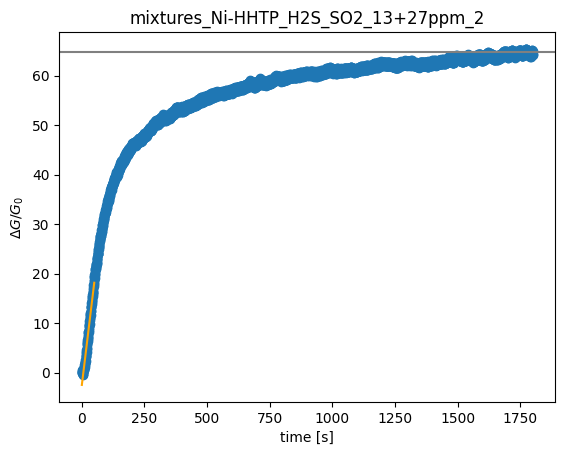

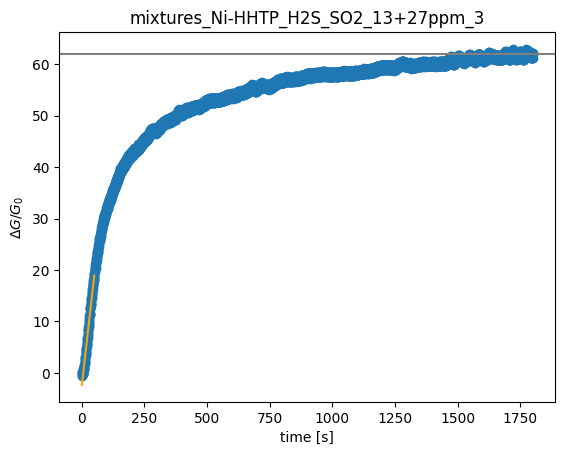

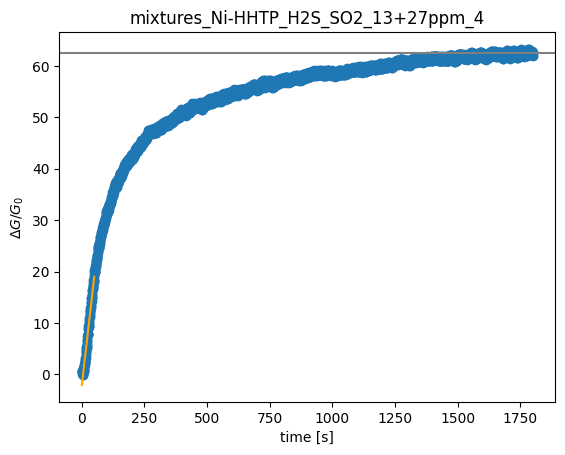

Error: replicate_id 5 does not exist for H2S_SO2  in Ni-HHTP at 13+27 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Ni-HHTP at 13+27 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Ni-HHTP at 13+27 ppm.


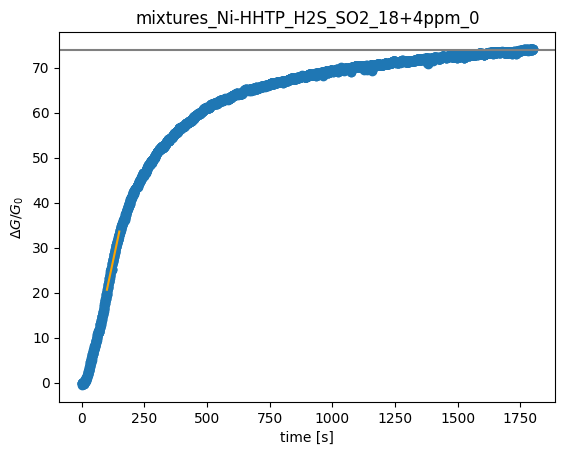

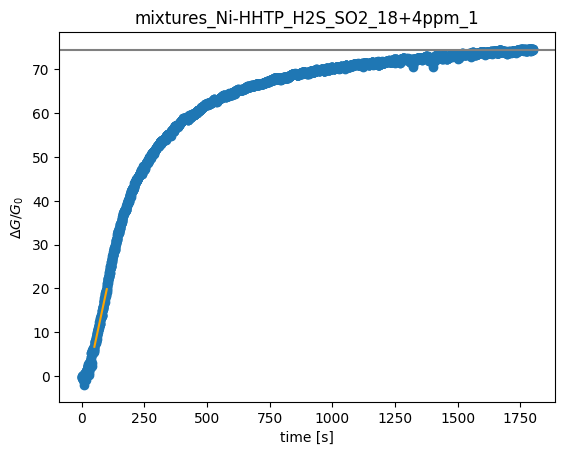

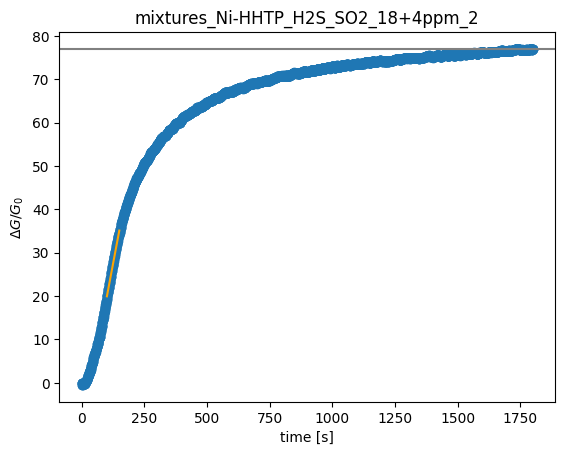

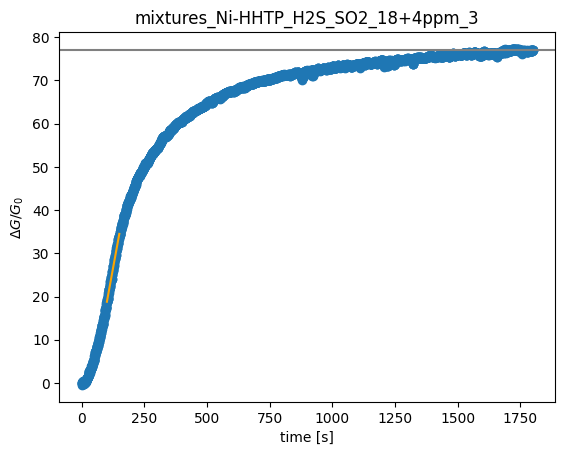

Error: replicate_id 4 does not exist for H2S_SO2  in Ni-HHTP at 18+4 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Ni-HHTP at 18+4 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Ni-HHTP at 18+4 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Ni-HHTP at 18+4 ppm.


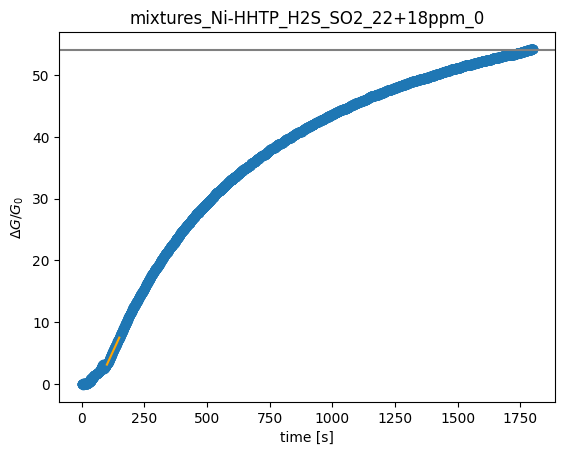

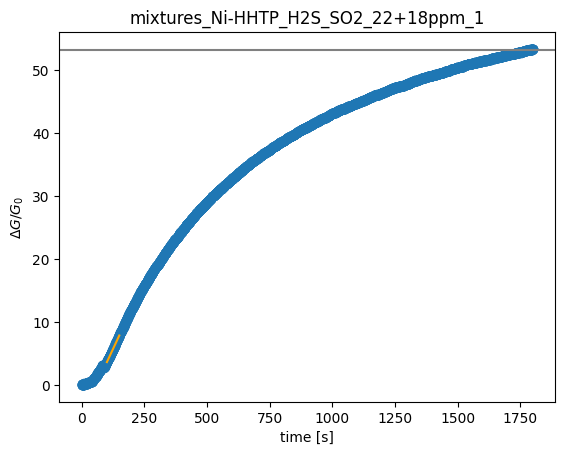

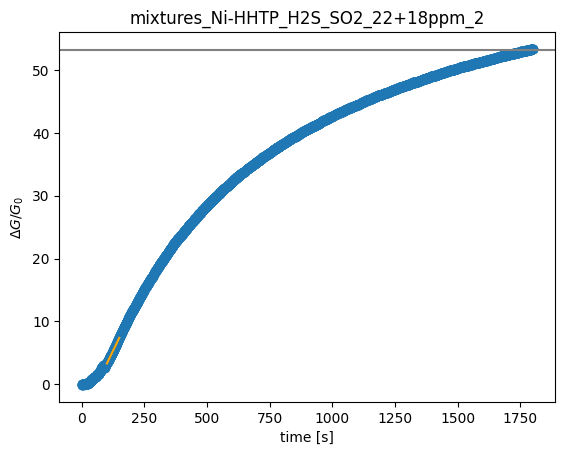

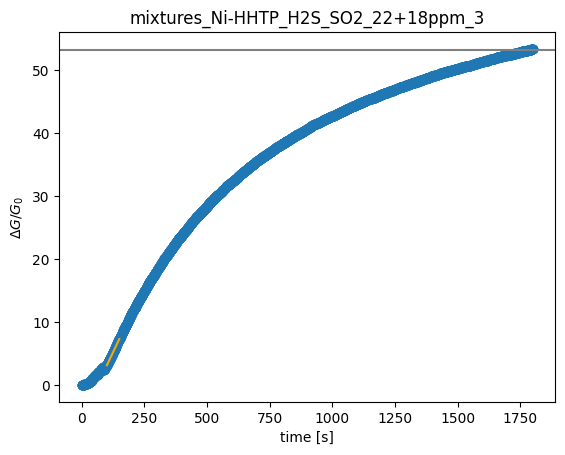

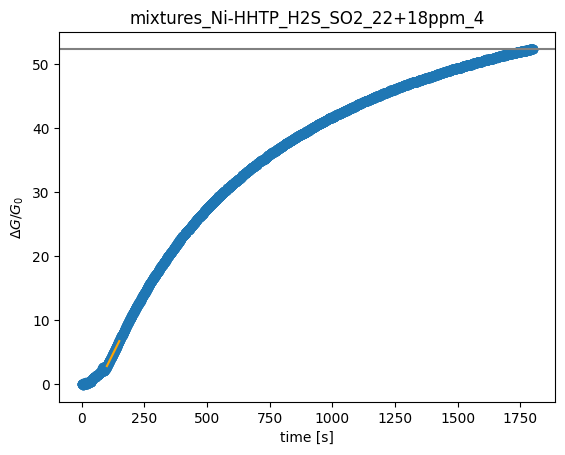

Error: replicate_id 5 does not exist for H2S_SO2  in Ni-HHTP at 22+18 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Ni-HHTP at 22+18 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Ni-HHTP at 22+18 ppm.


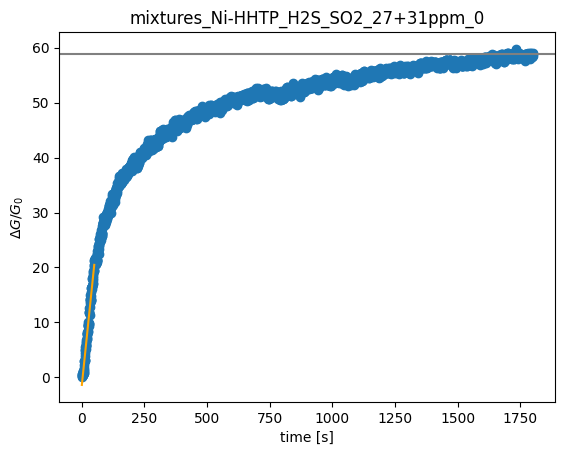

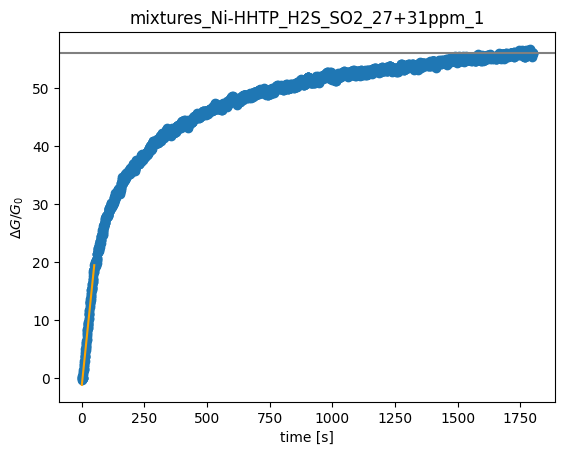

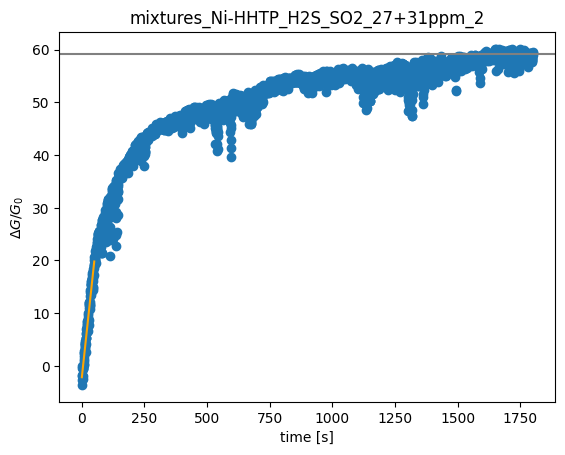

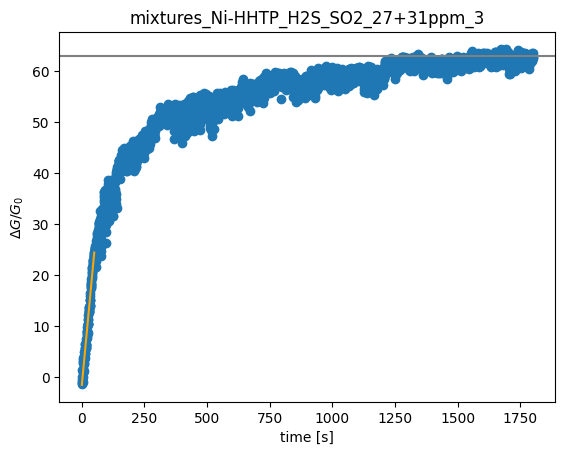

Error: replicate_id 4 does not exist for H2S_SO2  in Ni-HHTP at 27+31 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Ni-HHTP at 27+31 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Ni-HHTP at 27+31 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Ni-HHTP at 27+31 ppm.


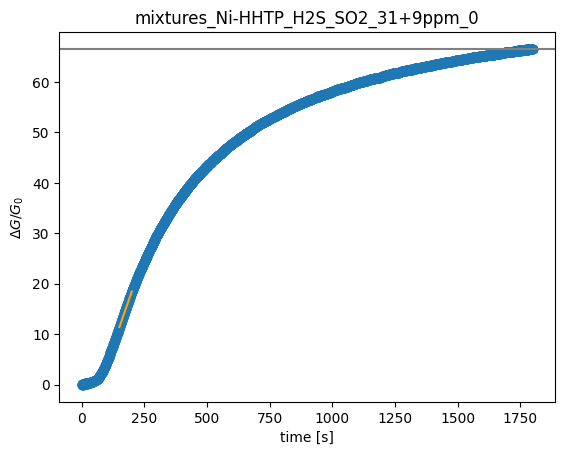

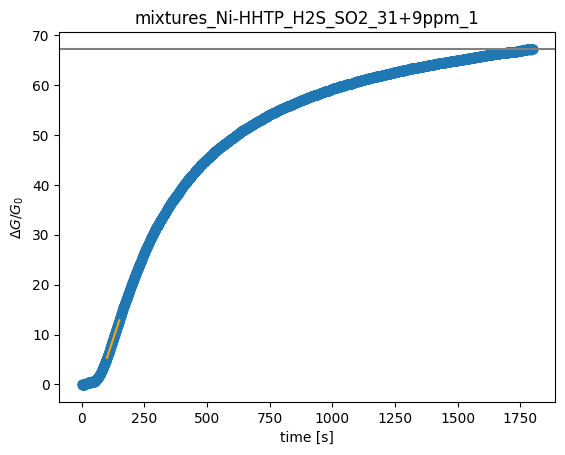

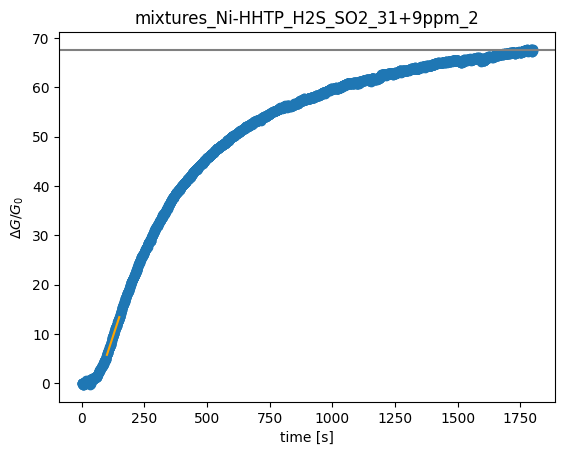

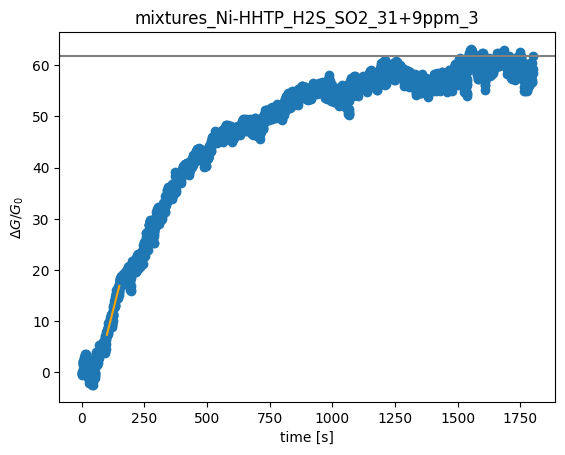

Error: replicate_id 4 does not exist for H2S_SO2  in Ni-HHTP at 31+9 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Ni-HHTP at 31+9 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Ni-HHTP at 31+9 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Ni-HHTP at 31+9 ppm.


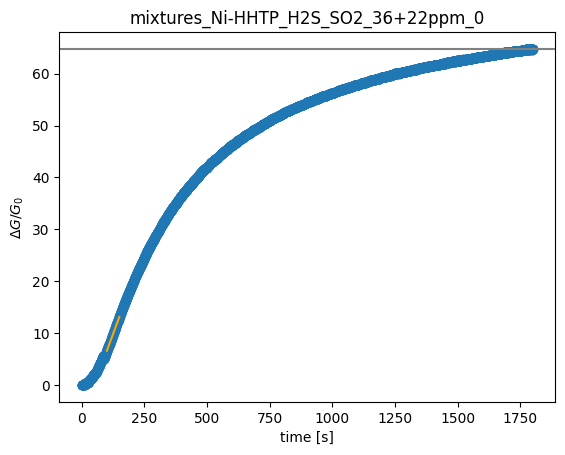

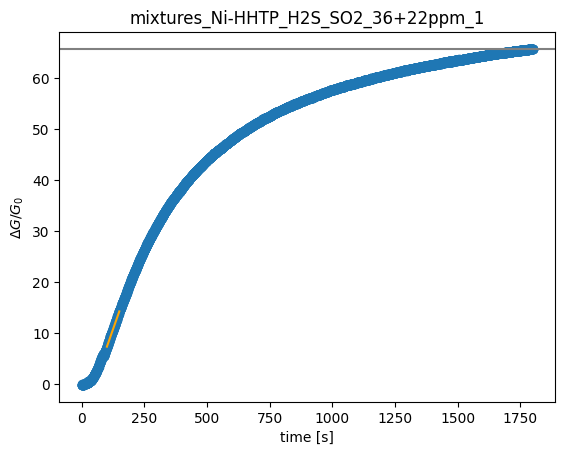

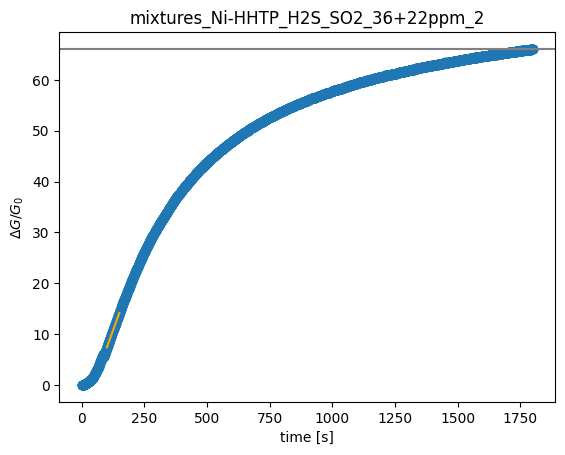

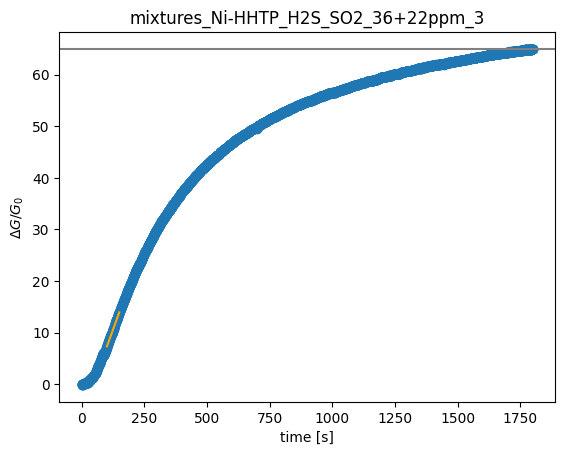

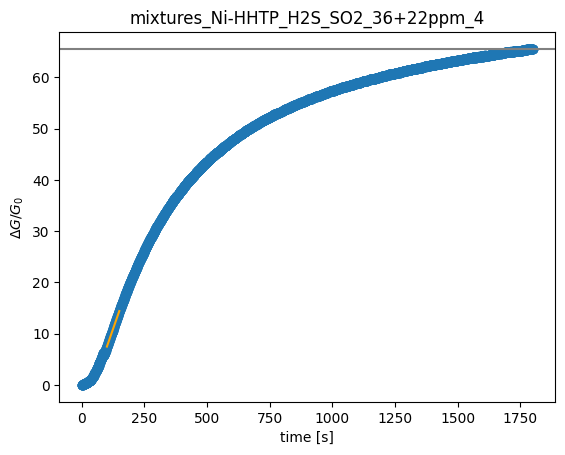

Error: replicate_id 5 does not exist for H2S_SO2  in Ni-HHTP at 36+22 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Ni-HHTP at 36+22 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Ni-HHTP at 36+22 ppm.


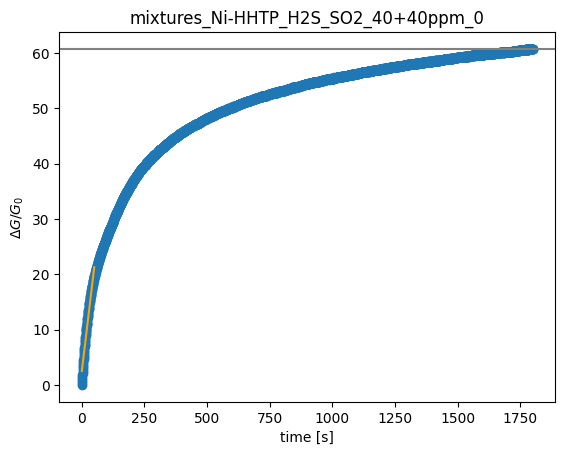

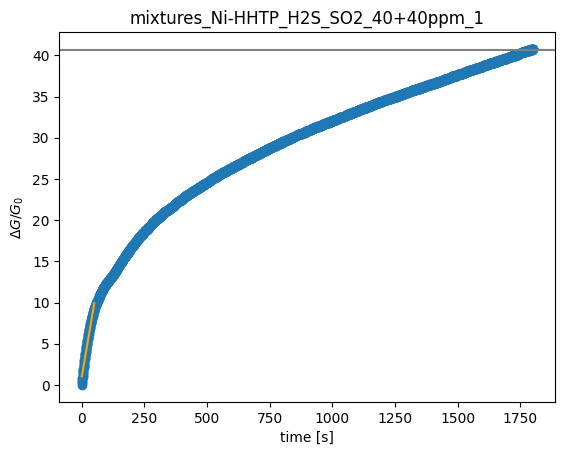

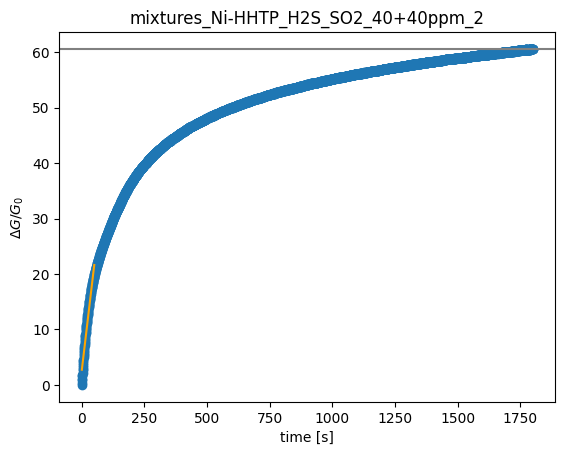

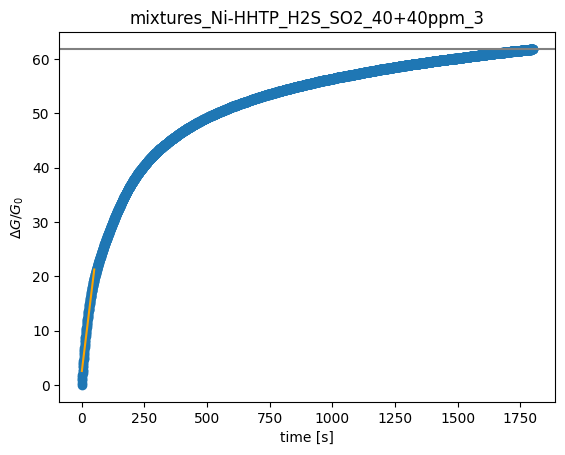

Error: replicate_id 4 does not exist for H2S_SO2  in Ni-HHTP at 40+40 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Ni-HHTP at 40+40 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Ni-HHTP at 40+40 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Ni-HHTP at 40+40 ppm.
Error: replicate_id 0 does not exist for H2S_SO2  in Zn-HHTP at 0.5 ppm.
Error: replicate_id 1 does not exist for H2S_SO2  in Zn-HHTP at 0.5 ppm.
Error: replicate_id 2 does not exist for H2S_SO2  in Zn-HHTP at 0.5 ppm.
Error: replicate_id 3 does not exist for H2S_SO2  in Zn-HHTP at 0.5 ppm.
Error: replicate_id 4 does not exist for H2S_SO2  in Zn-HHTP at 0.5 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Zn-HHTP at 0.5 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Zn-HHTP at 0.5 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Zn-HHTP at 0.5 ppm.
Error: replicate_id 0 does not exist for H2S_SO2  in Zn-HHTP at 5 ppm.
Error: replicate_id 1 does not exist for H2S_

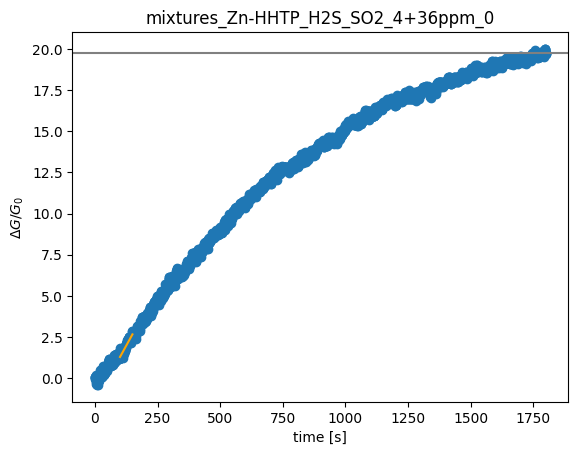

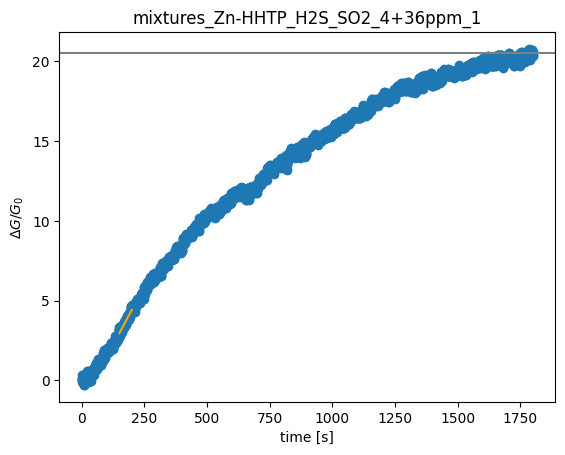

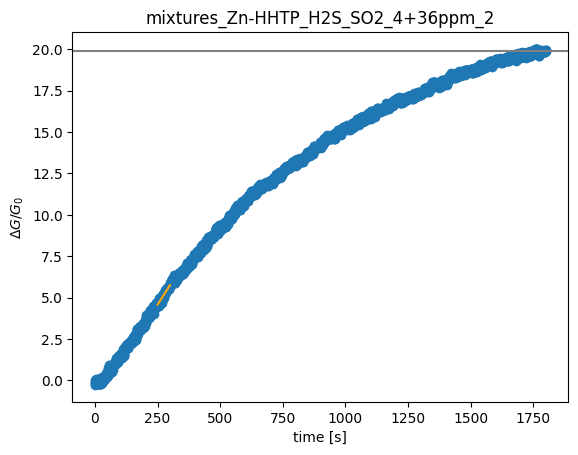

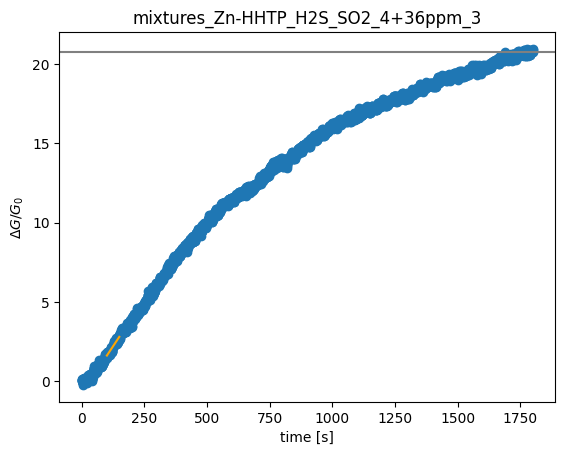

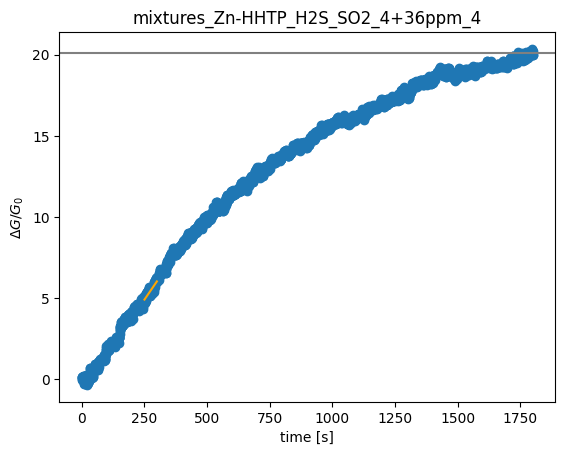

Error: replicate_id 5 does not exist for H2S_SO2  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Zn-HHTP at 4+36 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Zn-HHTP at 4+36 ppm.


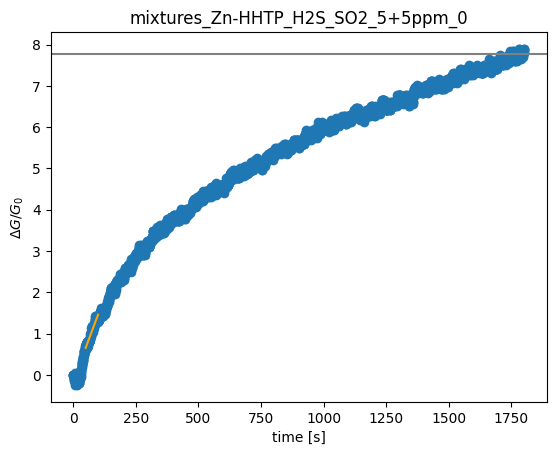

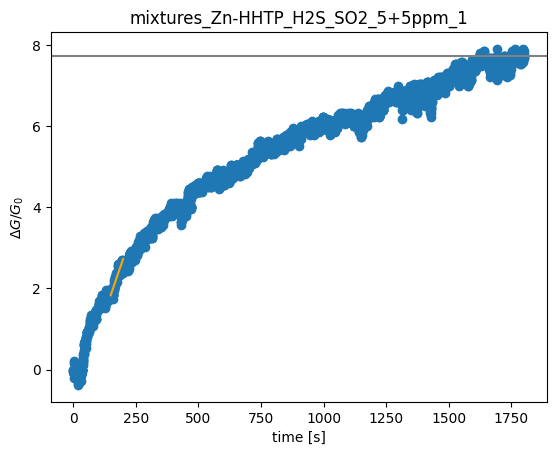

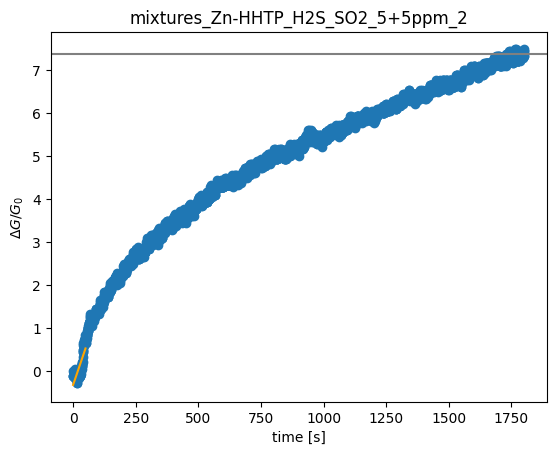

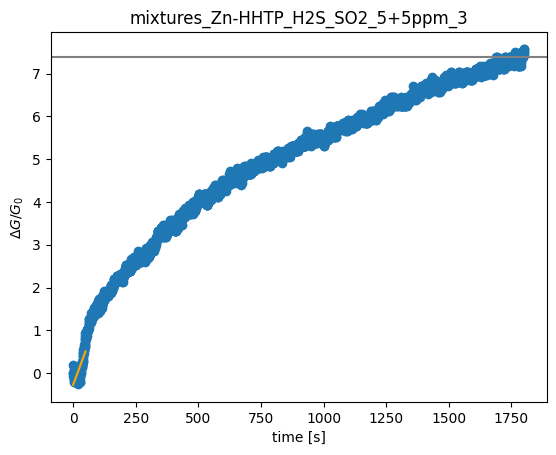

Error: replicate_id 4 does not exist for H2S_SO2  in Zn-HHTP at 5+5 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Zn-HHTP at 5+5 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Zn-HHTP at 5+5 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Zn-HHTP at 5+5 ppm.


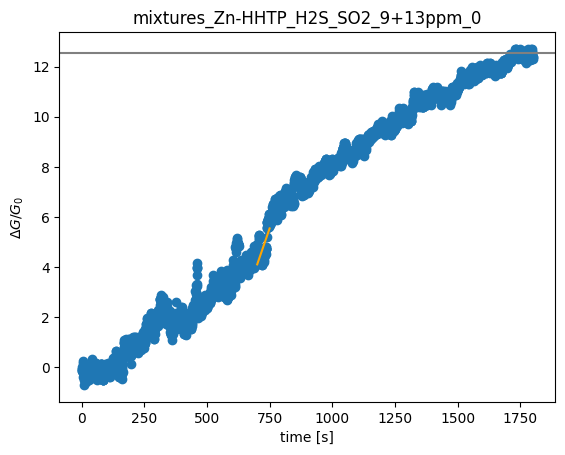

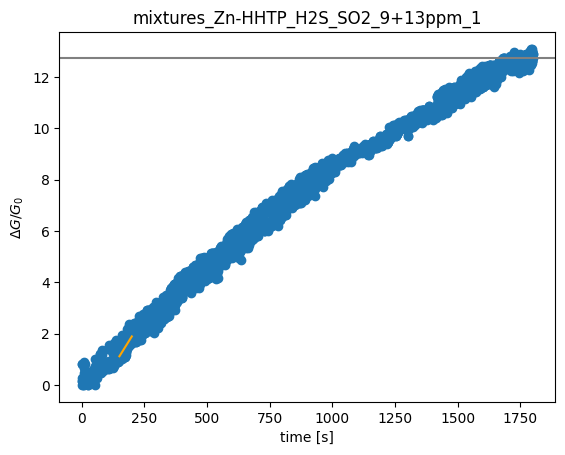

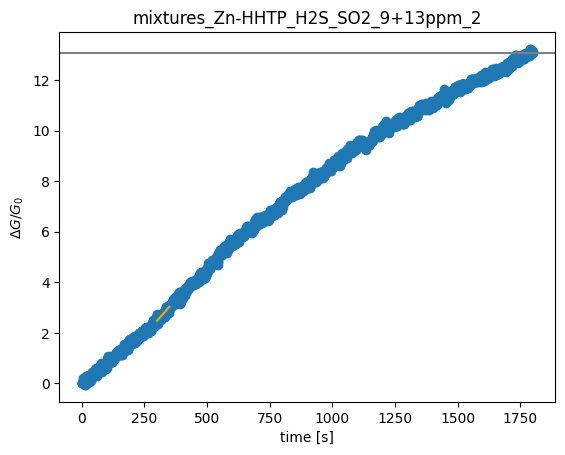

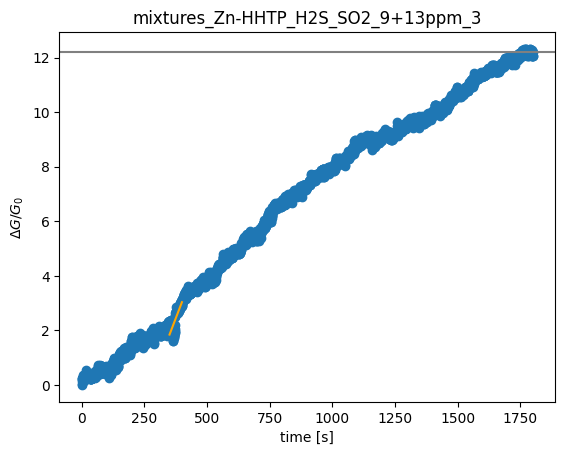

Error: replicate_id 4 does not exist for H2S_SO2  in Zn-HHTP at 9+13 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Zn-HHTP at 9+13 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Zn-HHTP at 9+13 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Zn-HHTP at 9+13 ppm.


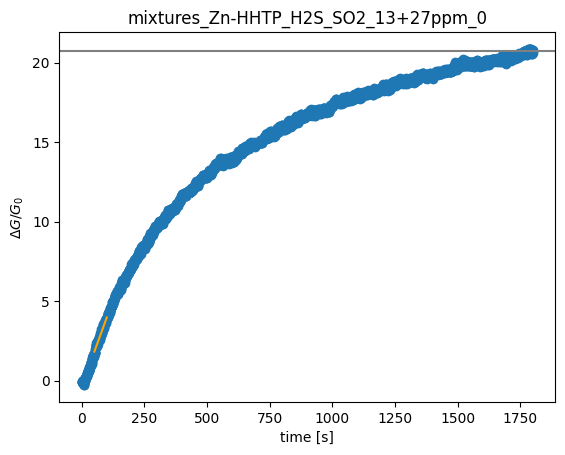

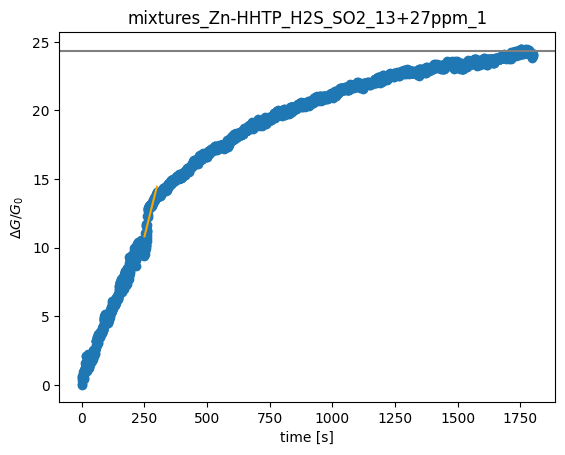

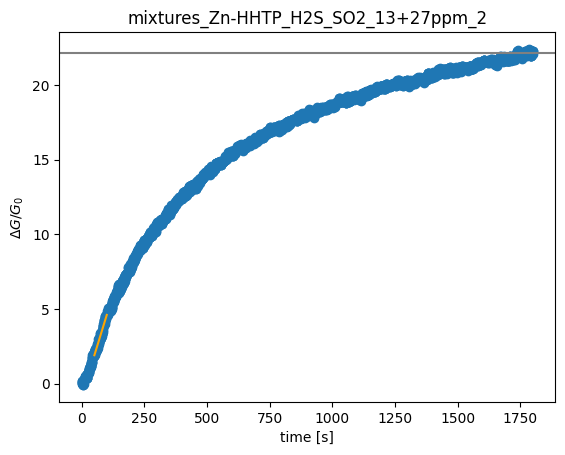

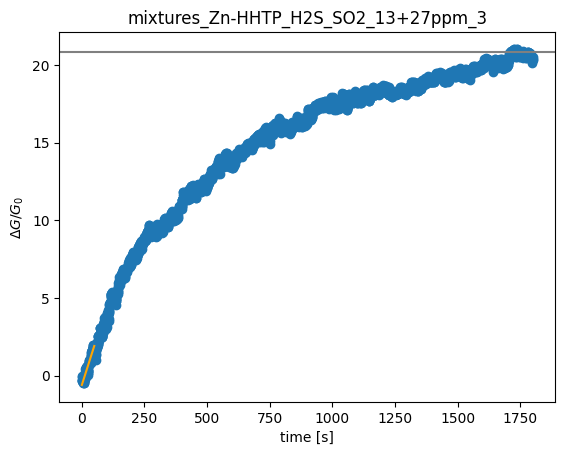

Error: replicate_id 4 does not exist for H2S_SO2  in Zn-HHTP at 13+27 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Zn-HHTP at 13+27 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Zn-HHTP at 13+27 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Zn-HHTP at 13+27 ppm.


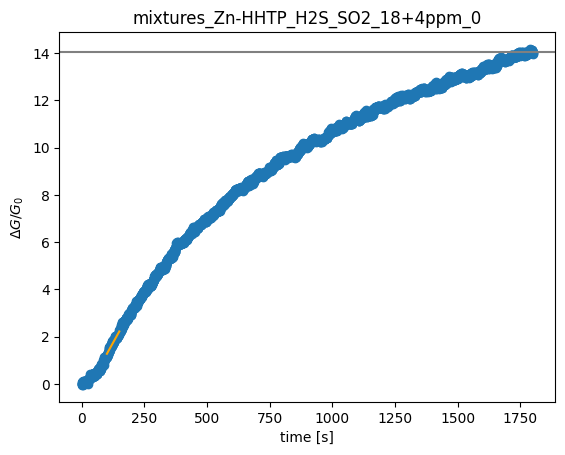

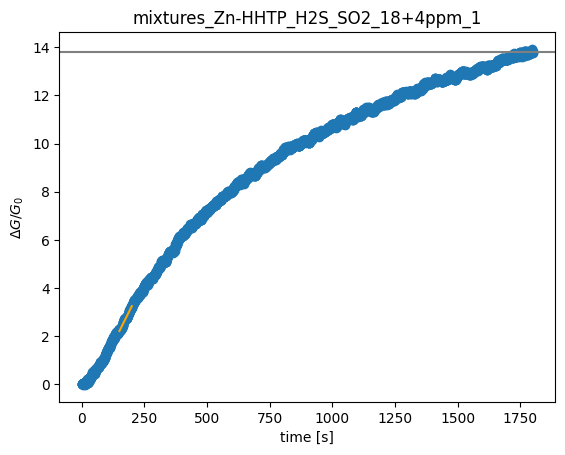

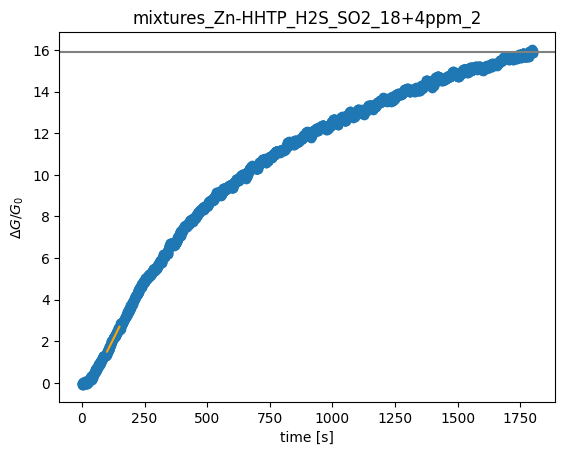

Error: replicate_id 3 does not exist for H2S_SO2  in Zn-HHTP at 18+4 ppm.
Error: replicate_id 4 does not exist for H2S_SO2  in Zn-HHTP at 18+4 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Zn-HHTP at 18+4 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Zn-HHTP at 18+4 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Zn-HHTP at 18+4 ppm.


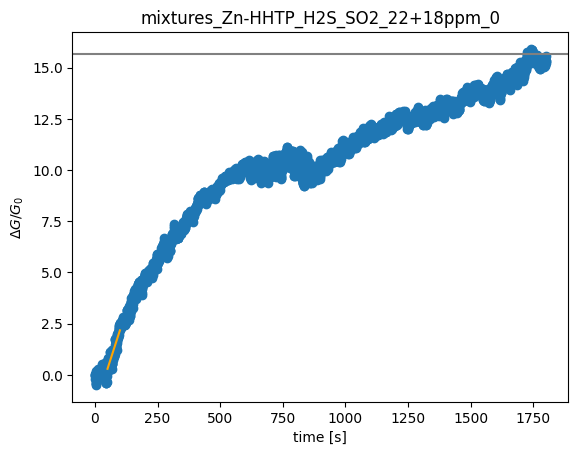

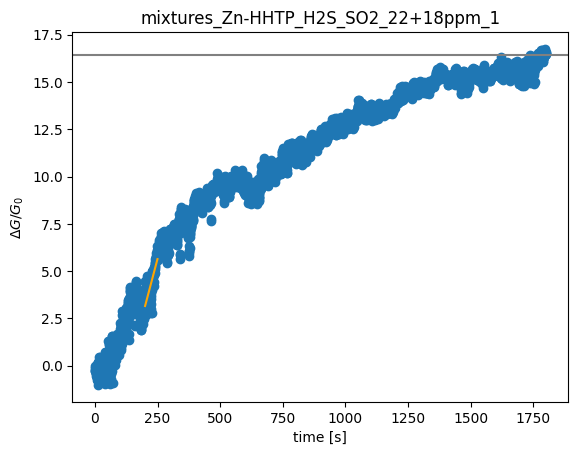

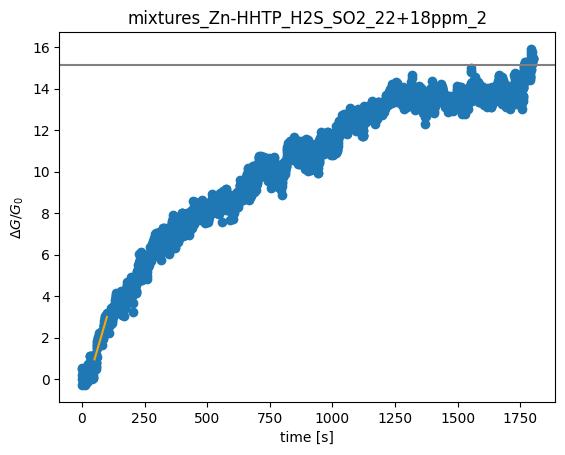

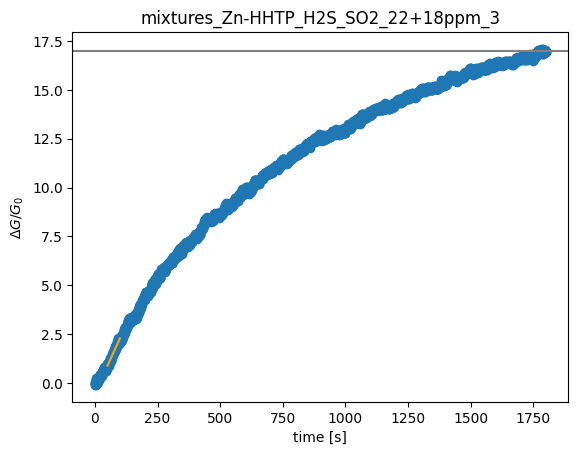

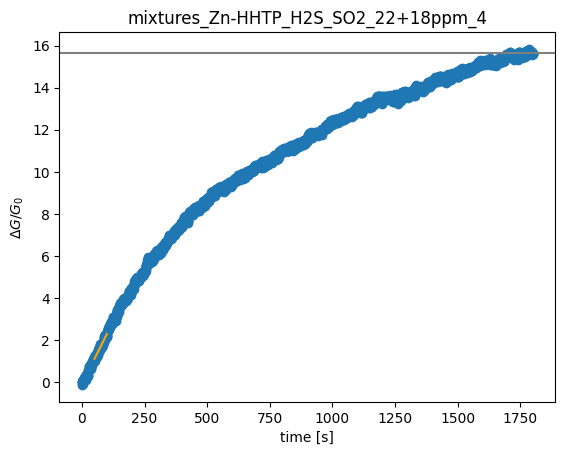

Error: replicate_id 5 does not exist for H2S_SO2  in Zn-HHTP at 22+18 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Zn-HHTP at 22+18 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Zn-HHTP at 22+18 ppm.


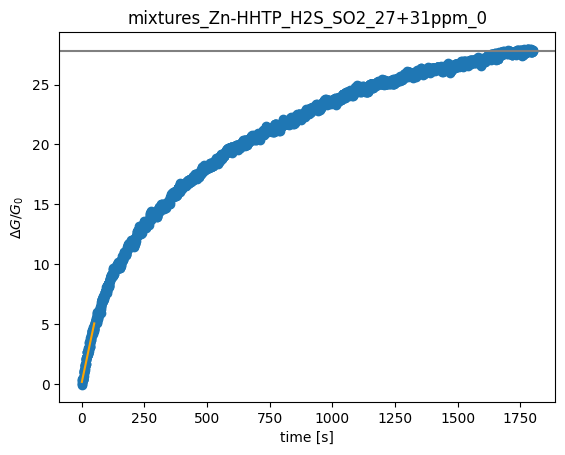

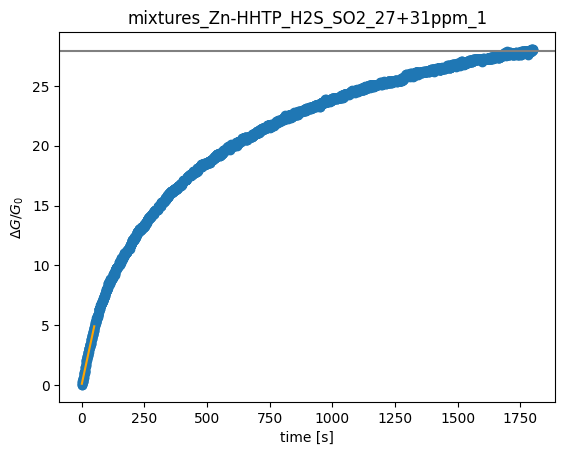

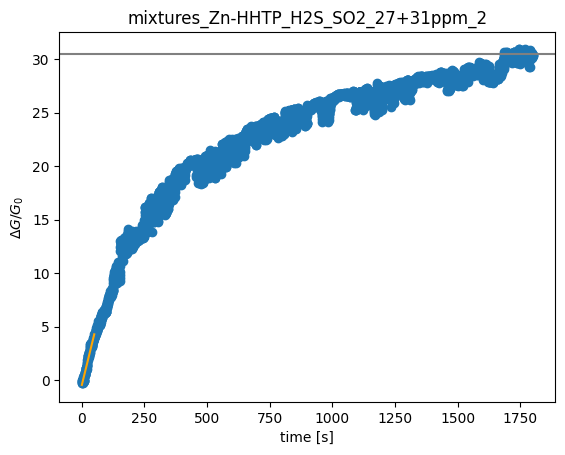

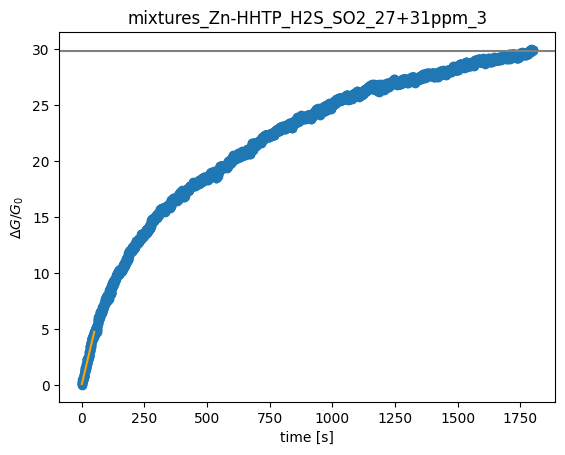

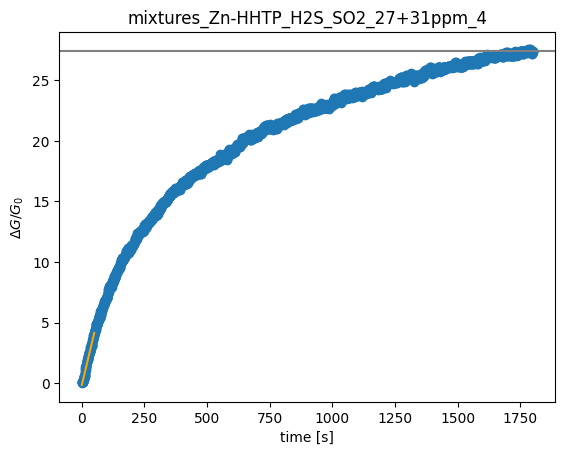

Error: replicate_id 5 does not exist for H2S_SO2  in Zn-HHTP at 27+31 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Zn-HHTP at 27+31 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Zn-HHTP at 27+31 ppm.


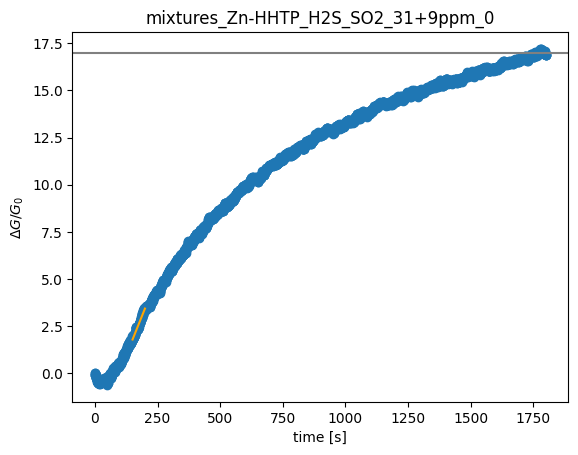

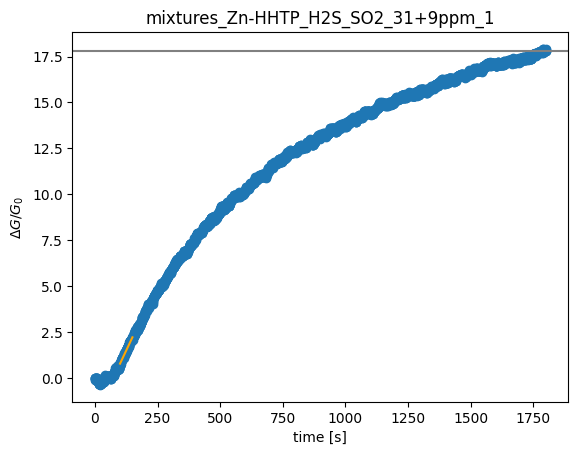

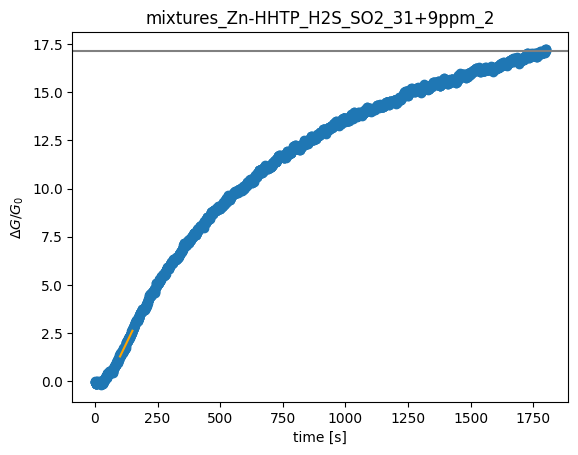

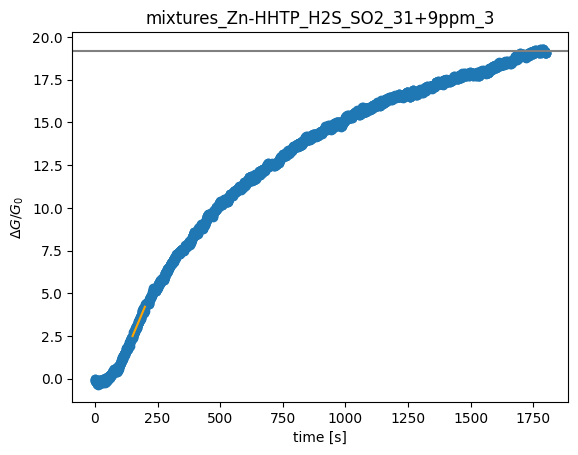

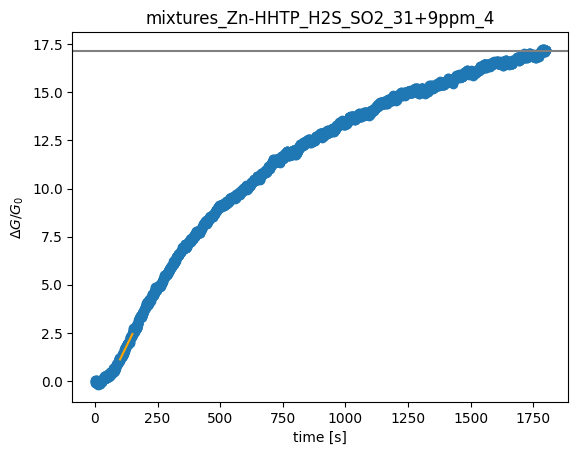

Error: replicate_id 5 does not exist for H2S_SO2  in Zn-HHTP at 31+9 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Zn-HHTP at 31+9 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Zn-HHTP at 31+9 ppm.


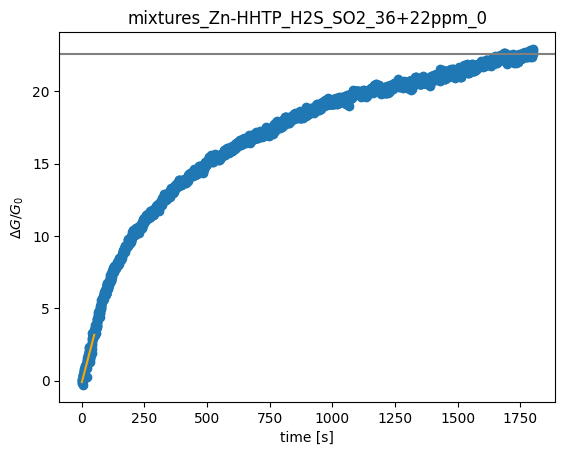

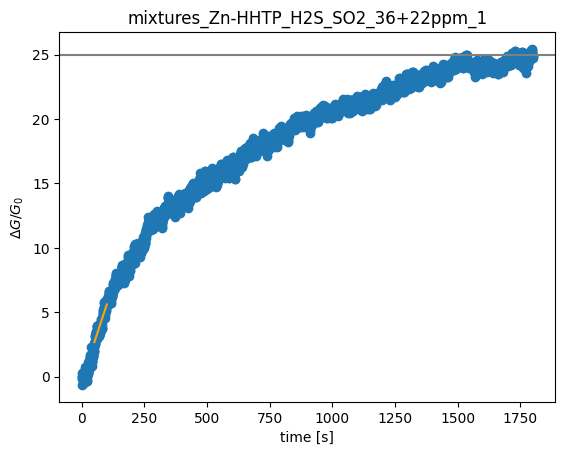

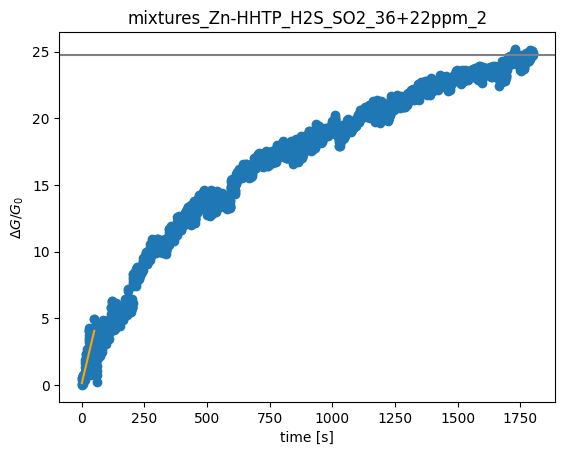

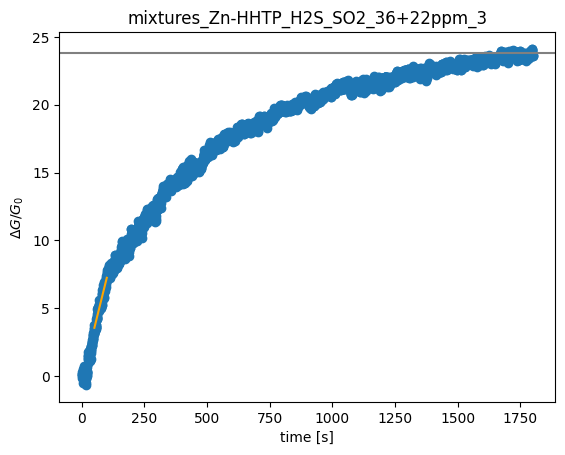

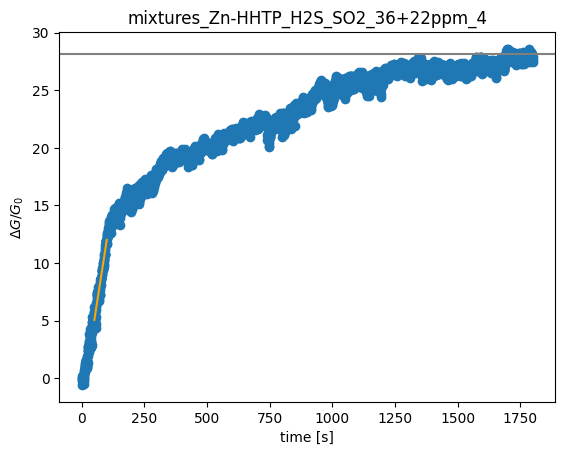

Error: replicate_id 5 does not exist for H2S_SO2  in Zn-HHTP at 36+22 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Zn-HHTP at 36+22 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Zn-HHTP at 36+22 ppm.


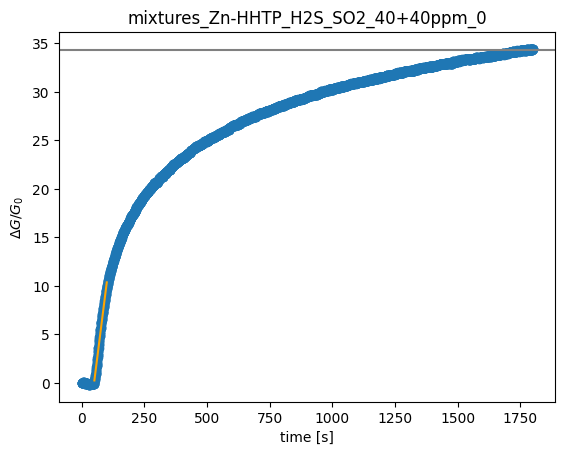

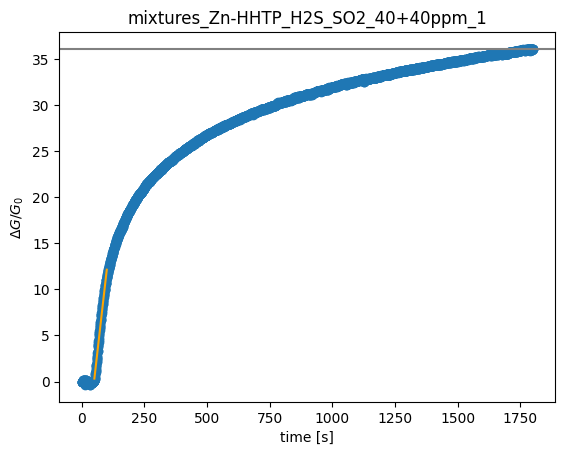

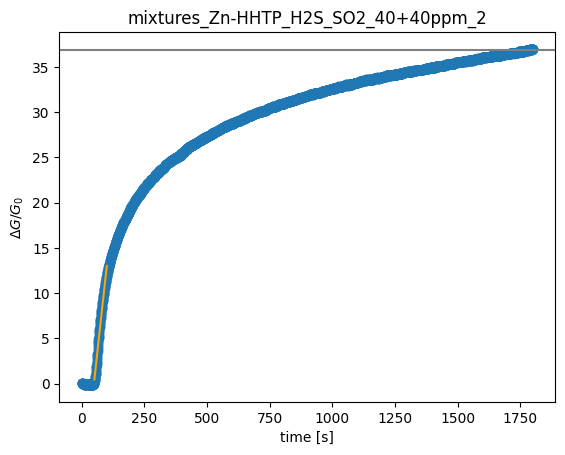

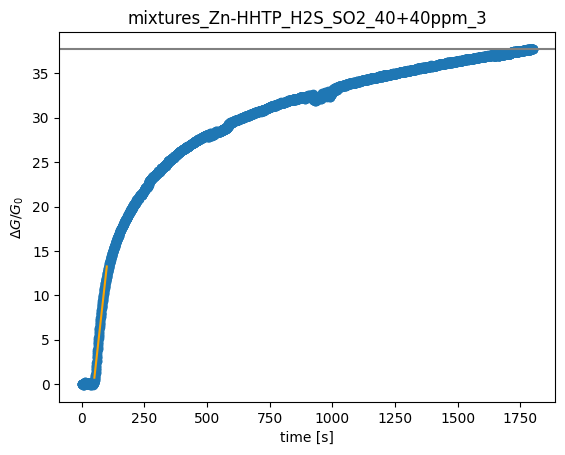

Error: replicate_id 4 does not exist for H2S_SO2  in Zn-HHTP at 40+40 ppm.
Error: replicate_id 5 does not exist for H2S_SO2  in Zn-HHTP at 40+40 ppm.
Error: replicate_id 6 does not exist for H2S_SO2  in Zn-HHTP at 40+40 ppm.
Error: replicate_id 7 does not exist for H2S_SO2  in Zn-HHTP at 40+40 ppm.


In [615]:
# list for data, will append cof, gas, carrier, and features of each sensor_response
data = []
for folder in folders:
    for gas in gases:
        for MOF in MOFs:
            for ppm in ppms:
                for rep_id in range(8):
                    if read_data_from_file:
                        continue

                    try:
                        sensor_response = SensorResponse(MOF, gas, ppm, folder, rep_id)
                        batch = retrieve_batch(folder, MOF, gas, ppm)
                        sensor_response.compute_features()
                        sensor_response.mean_response()
                        

                        sensor_response.viz(save=True)
                        data.append([MOF, gas, ppm, folder, rep_id, batch, sensor_response.slope_info['slope'],
                                    sensor_response.saturation, sensor_response.auc, sensor_response.mean_1, sensor_response.mean_2, sensor_response.mean_3,
                                    sensor_response.mean_4, sensor_response.mean_5, sensor_response.mean_6]) # be consistent with features above

                    except (AttributeError, Exception):
                        pass

In [616]:
data

[['Cu-HHTP',
  'H2S',
  0.5,
  'batch_2',
  0,
  'Cu-1',
  np.float64(0.08285906854858577),
  np.float64(71.64691800796682),
  np.float64(88532.72667207078),
  np.float64(11.54328650721784),
  np.float64(34.42223203126892),
  np.float64(50.786373287451916),
  np.float64(60.93856554162243),
  np.float64(66.9836201752789),
  np.float64(70.4326115620456)],
 ['Cu-HHTP',
  'H2S',
  0.5,
  'batch_2',
  1,
  'Cu-1',
  np.float64(0.08148735461996903),
  np.float64(75.85718343121584),
  np.float64(91710.45508510807),
  np.float64(10.7667870770645),
  np.float64(33.92022140486915),
  np.float64(52.05117497836341),
  np.float64(63.737166453920736),
  np.float64(70.66261774818976),
  np.float64(74.56145401783516)],
 ['Cu-HHTP',
  'H2S',
  0.5,
  'batch_2',
  2,
  'Cu-1',
  np.float64(0.08283453929531402),
  np.float64(72.60084791198578),
  np.float64(89045.11187648622),
  np.float64(11.339587129586965),
  np.float64(34.22774467844722),
  np.float64(50.85084419978803),
  np.float64(61.3771845777635

In [617]:
len(data)

258

In [619]:
# Put list of data into dataframe
if read_data_from_file:
    data_df = pd.read_csv("responses.csv")
    data_df.drop(columns=['Unnamed: 0'], inplace=True) # remove index column, artifact of reading in
else:
    data_df = pd.DataFrame(data, columns=['MOF', 'gas', 'ppm', "folder", 'rep_id', "batch", 'slope', 'saturation', 'auc', "mean_1", "mean_2", "mean_3", 
                                          "mean_4", "mean_5", "mean_6"])
    onc = OneHotEncoder(sparse_output=False)
    batch_onc = pd.DataFrame(onc.fit_transform(data_df["batch"].values.reshape(-1, 1)))
    batch_onc.columns = [batch for batch in onc.categories_[0]]
    data_df = data_df.join(batch_onc)
    

    # data_df["batch"] = onc.fit_transform(data_df["batch"].values.reshape(-1, 1))
    data_df.to_csv("responses.csv")
data_df

MOF      gas    ppm    folder  rep_id batch     slope  saturation  \
0    Cu-HHTP      H2S    0.5   batch_2       0  Cu-1  0.082859   71.646918   
1    Cu-HHTP      H2S    0.5   batch_2       1  Cu-1  0.081487   75.857183   
2    Cu-HHTP      H2S    0.5   batch_2       2  Cu-1  0.082835   72.600848   
3    Cu-HHTP      H2S    0.5   batch_2       3  Cu-1  0.075401   74.172221   
4    Cu-HHTP      H2S      5   batch_2       0  Cu-1  0.208299   93.948025   
..       ...      ...    ...       ...     ...   ...       ...         ...   
253  Zn-HHTP  H2S_SO2  36+22  mixtures       4  Zn-1  0.140214   28.138839   
254  Zn-HHTP  H2S_SO2  40+40  mixtures       0  Zn-1  0.204306   34.358037   
255  Zn-HHTP  H2S_SO2  40+40  mixtures       1  Zn-1  0.238722   36.029578   
256  Zn-HHTP  H2S_SO2  40+40  mixtures       2  Zn-1  0.253028   36.904915   
257  Zn-HHTP  H2S_SO2  40+40  mixtures       3  Zn-1  0.252932   37.686367   

               auc     mean_1  ...     mean_4     mean_5     mean_6  Cu-1  \
0     88532.726672  11.543287  ...  60.938566  66.983620  70.432612   1.0   
1     91710.455085  10.766787  ...  63.737166  70.662618  74.561454   1.0   
2     89045.111876  11.339587  ...  61.377185  67.695035  71.324317   1.0   
3     87970.577724   9.940622  ...  61.152509  68.512186  72.737813   1.0   
4    134957.215895  23.872341  ...  90.454925  92.691279  93.651651   1.0   
..             ...        ...  ...        ...        ...        ...   ...   
253   40040.881150  12.185949  ...  25.225564  26.769200  27.355944   0.0   
254   48224.836503  11.986551  ...  30.586550  32.374464  33.793526   0.0   
255   51155.279600  13.310922  ...  32.237975  34.019892  35.465791   0.0   
256   52285.602964  13.782368  ...  32.910662  34.684624  36.206331   0.0   
257   53446.531250  14.043520  ...  33.473316  35.535257  37.034425   0.0   

     Ni-1  Ni-2  Ni-3  Ni-4  Ni-5  Zn-1  
0     0.0   0.0   0.0   0.0   0.0   0.0  
1     0.0   0.0   0.0   0.0   0.0   0.0  
2     0.0   0.0   0.0   0.0   0.0   0.0  
3     0.0   0.0   0.0   0.0   0.0   0.0  
4     0.0   0.0   0.0   0.0   0.0   0.0  
..    ...   ...   ...   ...   ...   ...  
253   0.0   0.0   0.0   0.0   0.0   1.0  
254   0.0   0.0   0.0   0.0   0.0   1.0  
255   0.0   0.0   0.0   0.0   0.0   1.0  
256   0.0   0.0   0.0   0.0   0.0   1.0  
257   0.0   0.0   0.0   0.0   0.0   1.0  

[258 rows x 22 columns]

In [620]:
data_df[data_df["gas"]=="SO2"].ppm.unique()

array([5, 10, 20, 40, 80], dtype=object)

# Function to make feature response adjustments

In [621]:
# input data, experiment, and slope partition adjustment, output: dataframe and viz with adjusted slope feature
def make_adjustment(data_df, MOF, gas, ppm, folder, rep_ids, n_partitions_slope_adj=15, n_partitions_saturation_adj=100, time_adjust=0):
    for rep_id in rep_ids:
        try:
            sensor_response = SensorResponse(MOF, gas, ppm, folder, rep_id, time_adjust=time_adjust)
            sensor_response.compute_features(n_partitions_slope=n_partitions_slope_adj, n_partitions_saturation=n_partitions_saturation_adj)
            sensor_response.viz(save=True)
            data_df.loc[(data_df['MOF']==MOF)
                                & (data_df['gas']==gas)
                                & (data_df['ppm']==ppm)
                                & (data_df['folder']==folder)
                                & (data_df['rep_id']==rep_id), 'slope'] = sensor_response.slope_info['slope']
            data_df.loc[(data_df['MOF']==MOF)
                                & (data_df['gas']==gas)
                                & (data_df['ppm']==ppm)
                                & (data_df['folder']==folder)
                                & (data_df['rep_id']==rep_id), 'auc'] = sensor_response.auc
            data_df.loc[(data_df['MOF']==MOF)
                                & (data_df['gas']==gas)
                                & (data_df['ppm']==ppm)
                                & (data_df['folder']==folder)
                                & (data_df['rep_id']==rep_id), 'saturation'] = sensor_response.saturation
        except:
            pass
    return data_df

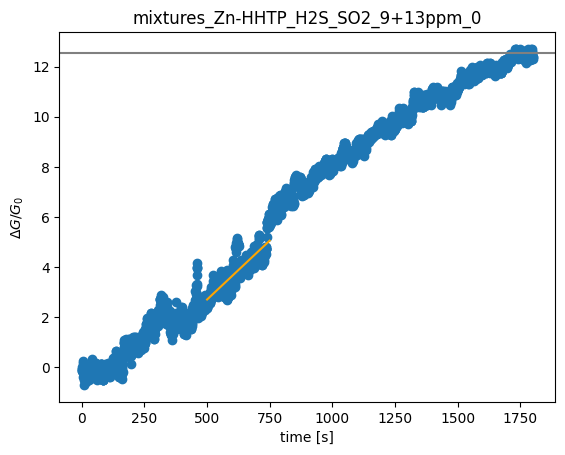

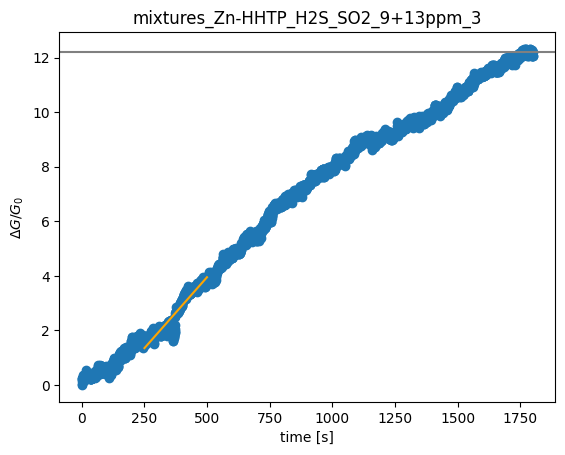

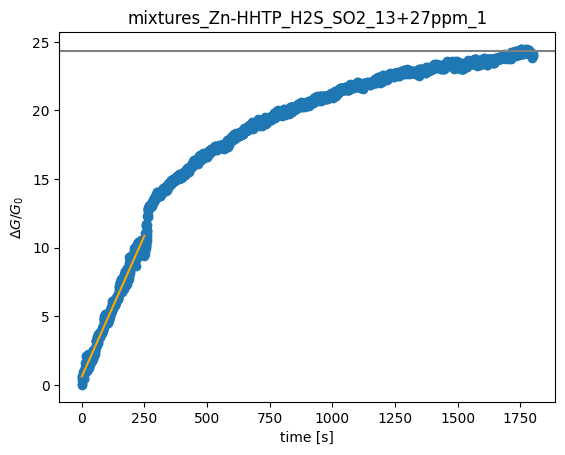

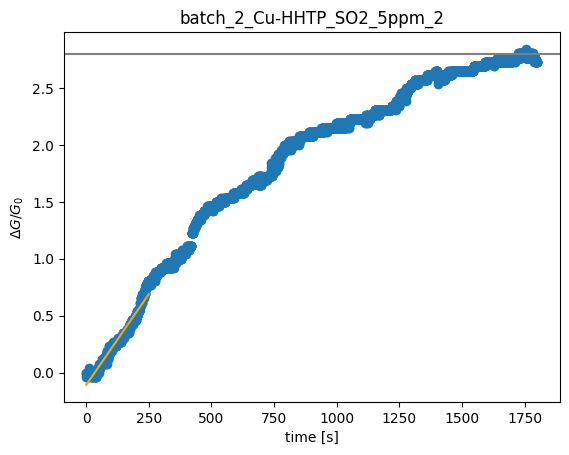

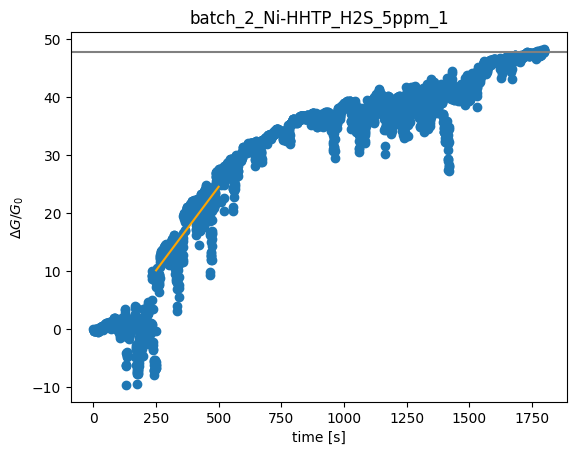

MOF      gas    ppm    folder  rep_id batch     slope  saturation  \
0    Cu-HHTP      H2S    0.5   batch_2       0  Cu-1  0.082859   71.646918   
1    Cu-HHTP      H2S    0.5   batch_2       1  Cu-1  0.081487   75.857183   
2    Cu-HHTP      H2S    0.5   batch_2       2  Cu-1  0.082835   72.600848   
3    Cu-HHTP      H2S    0.5   batch_2       3  Cu-1  0.075401   74.172221   
4    Cu-HHTP      H2S      5   batch_2       0  Cu-1  0.208299   93.948025   
..       ...      ...    ...       ...     ...   ...       ...         ...   
253  Zn-HHTP  H2S_SO2  36+22  mixtures       4  Zn-1  0.140214   28.138839   
254  Zn-HHTP  H2S_SO2  40+40  mixtures       0  Zn-1  0.204306   34.358037   
255  Zn-HHTP  H2S_SO2  40+40  mixtures       1  Zn-1  0.238722   36.029578   
256  Zn-HHTP  H2S_SO2  40+40  mixtures       2  Zn-1  0.253028   36.904915   
257  Zn-HHTP  H2S_SO2  40+40  mixtures       3  Zn-1  0.252932   37.686367   

               auc     mean_1  ...     mean_4     mean_5     mean_6  Cu-1  \
0     88532.726672  11.543287  ...  60.938566  66.983620  70.432612   1.0   
1     91710.455085  10.766787  ...  63.737166  70.662618  74.561454   1.0   
2     89045.111876  11.339587  ...  61.377185  67.695035  71.324317   1.0   
3     87970.577724   9.940622  ...  61.152509  68.512186  72.737813   1.0   
4    134957.215895  23.872341  ...  90.454925  92.691279  93.651651   1.0   
..             ...        ...  ...        ...        ...        ...   ...   
253   40040.881150  12.185949  ...  25.225564  26.769200  27.355944   0.0   
254   48224.836503  11.986551  ...  30.586550  32.374464  33.793526   0.0   
255   51155.279600  13.310922  ...  32.237975  34.019892  35.465791   0.0   
256   52285.602964  13.782368  ...  32.910662  34.684624  36.206331   0.0   
257   53446.531250  14.043520  ...  33.473316  35.535257  37.034425   0.0   

     Ni-1  Ni-2  Ni-3  Ni-4  Ni-5  Zn-1  
0     0.0   0.0   0.0   0.0   0.0   0.0  
1     0.0   0.0   0.0   0.0   0.0   0.0  
2     0.0   0.0   0.0   0.0   0.0   0.0  
3     0.0   0.0   0.0   0.0   0.0   0.0  
4     0.0   0.0   0.0   0.0   0.0   0.0  
..    ...   ...   ...   ...   ...   ...  
253   0.0   0.0   0.0   0.0   0.0   1.0  
254   0.0   0.0   0.0   0.0   0.0   1.0  
255   0.0   0.0   0.0   0.0   0.0   1.0  
256   0.0   0.0   0.0   0.0   0.0   1.0  
257   0.0   0.0   0.0   0.0   0.0   1.0  

[258 rows x 22 columns]

In [622]:
make_adjustment(data_df, MOF='Zn-HHTP', gas='H2S_SO2', ppm="9+13", folder="mixtures", rep_ids=[0, 3], n_partitions_slope_adj=3)
make_adjustment(data_df, MOF='Zn-HHTP', gas='H2S_SO2', ppm="13+27", folder="mixtures", rep_ids=[1], n_partitions_slope_adj=3)
make_adjustment(data_df, MOF='Cu-HHTP', gas='SO2', ppm=5, folder="batch_2", rep_ids=[2], n_partitions_slope_adj=3)
make_adjustment(data_df, MOF='Ni-HHTP', gas='H2S', ppm=5, folder="batch_2", rep_ids=[1], n_partitions_slope_adj=3)

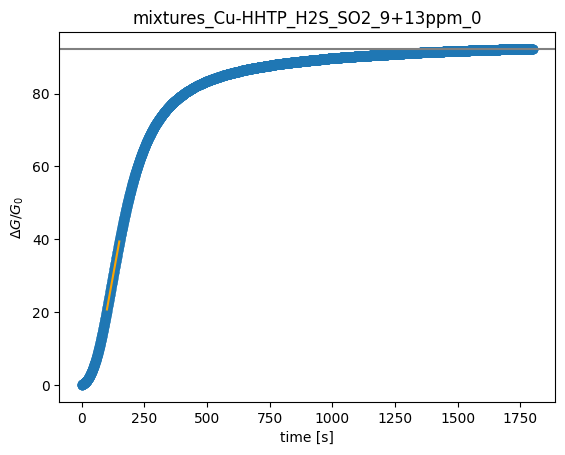

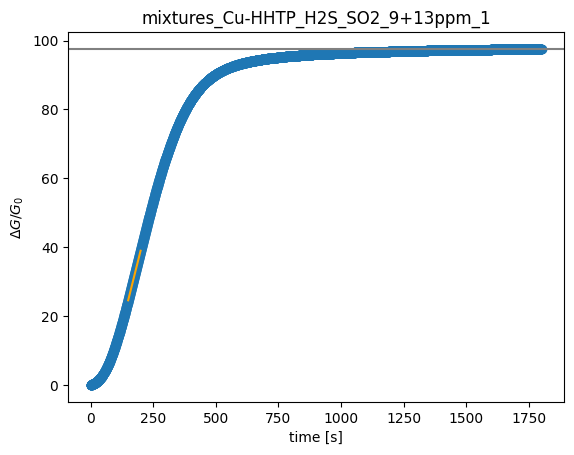

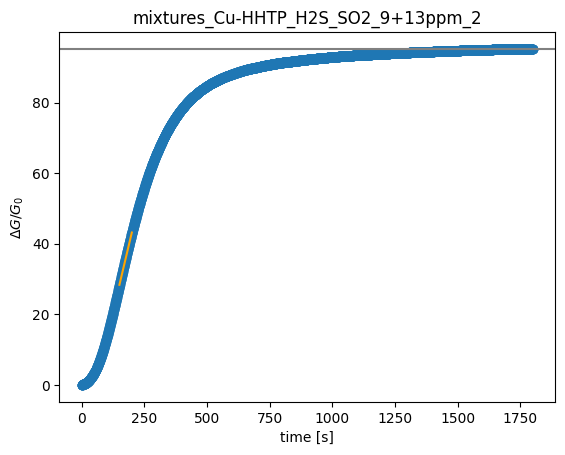

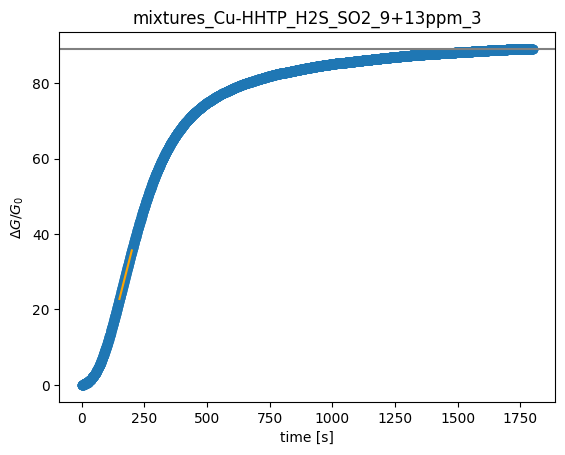

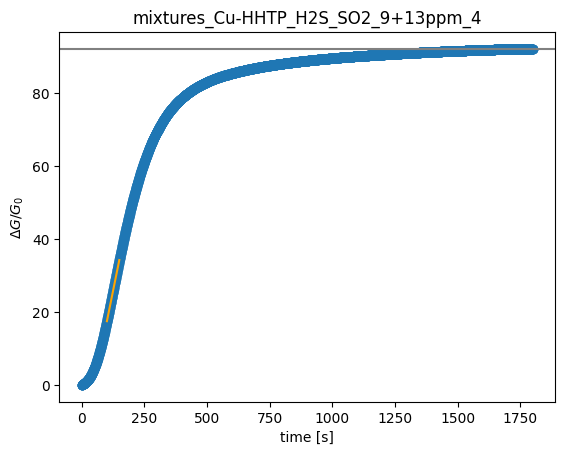

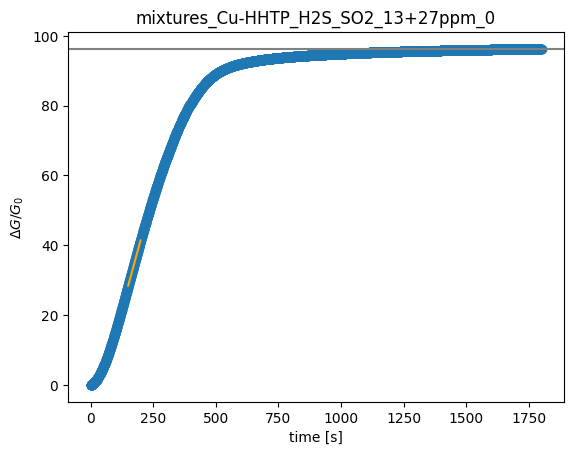

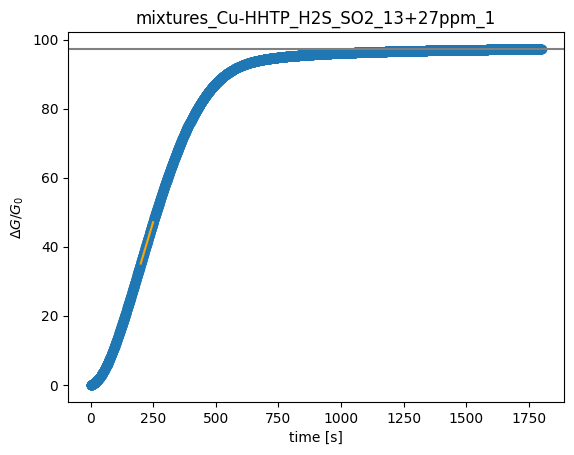

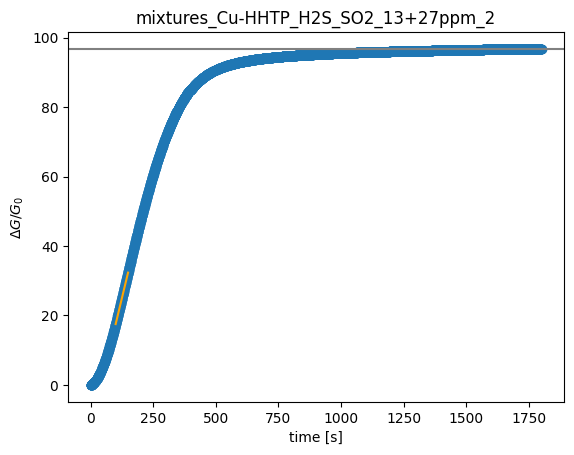

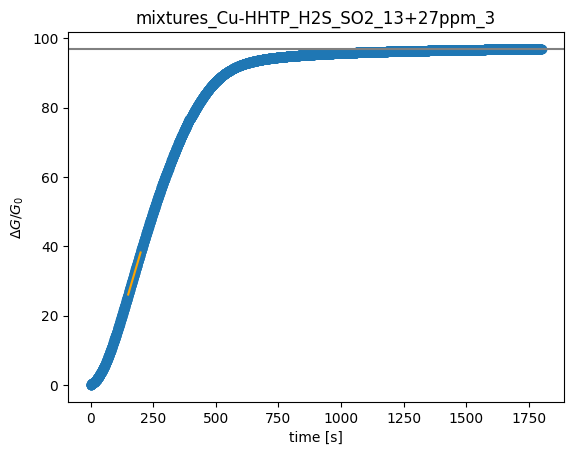

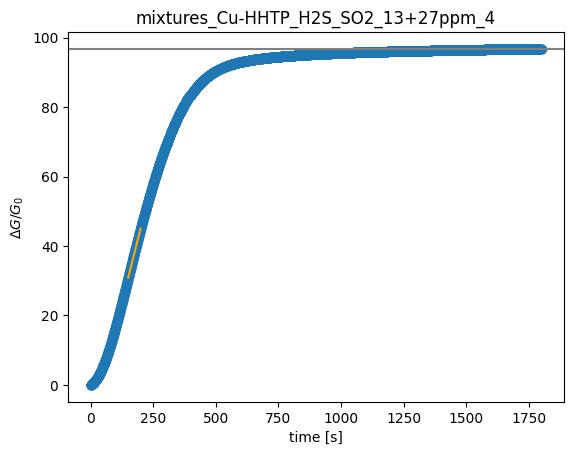

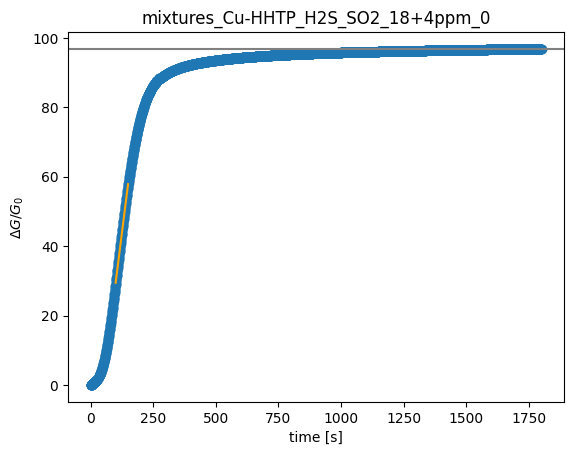

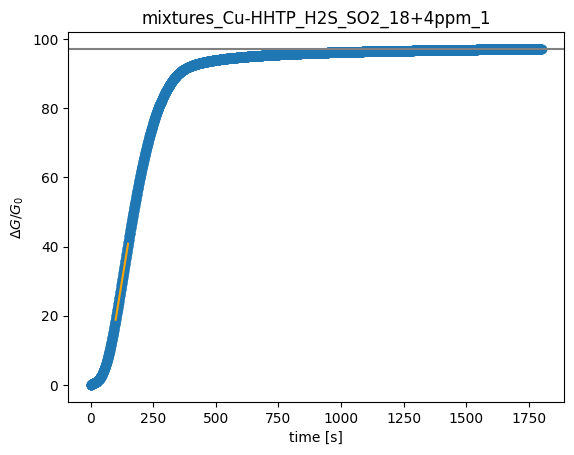

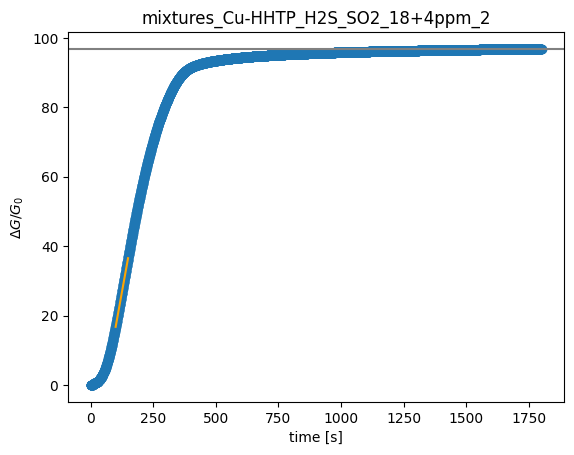

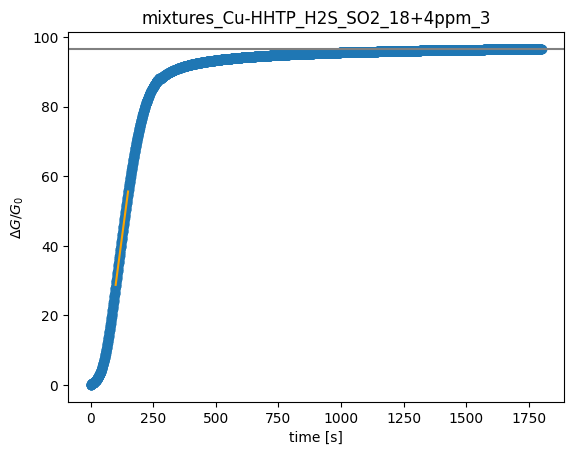

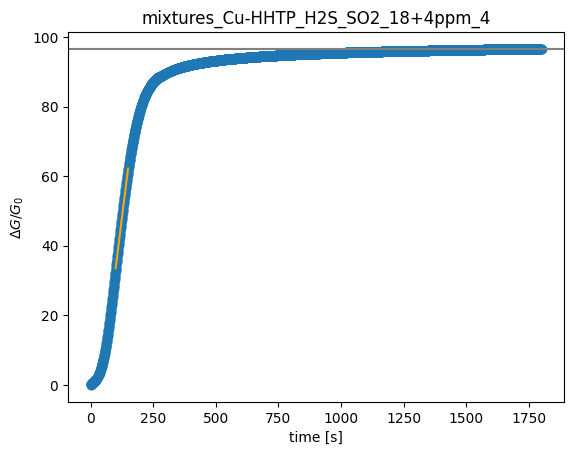

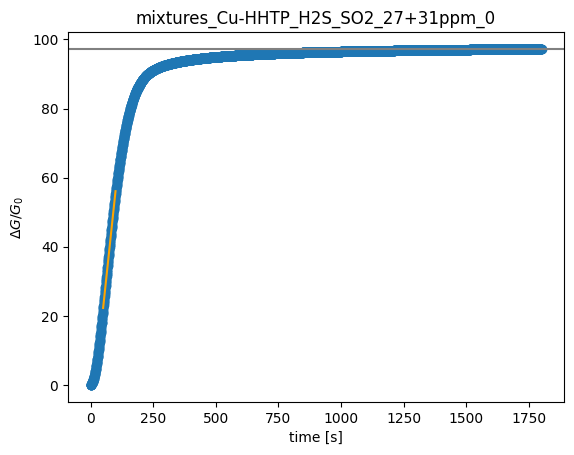

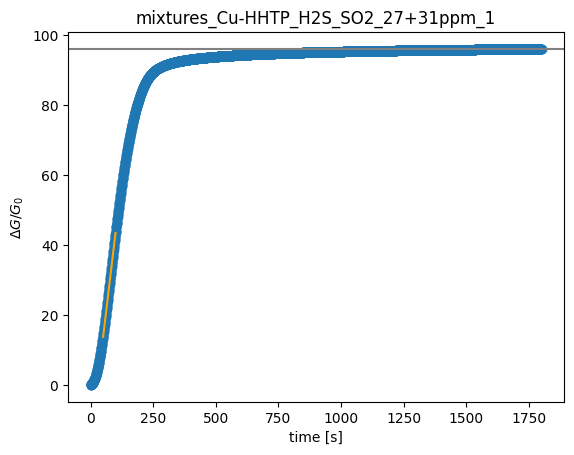

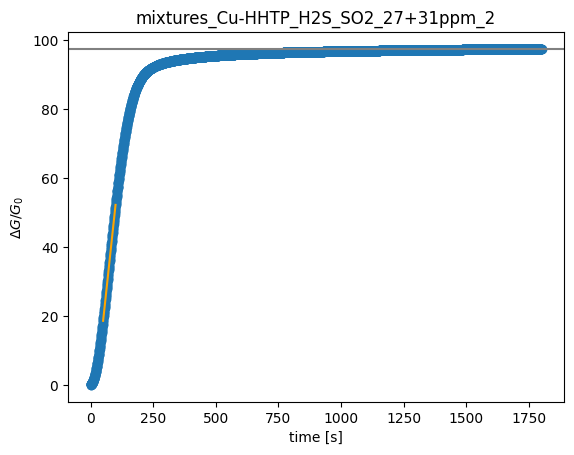

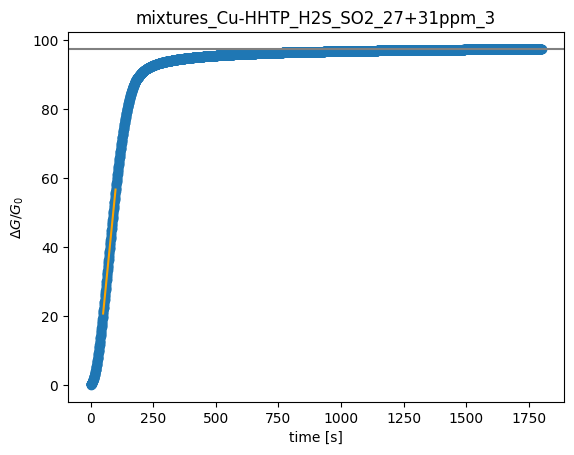

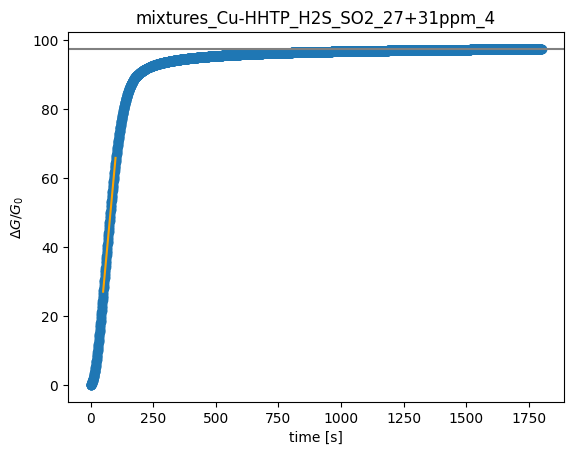

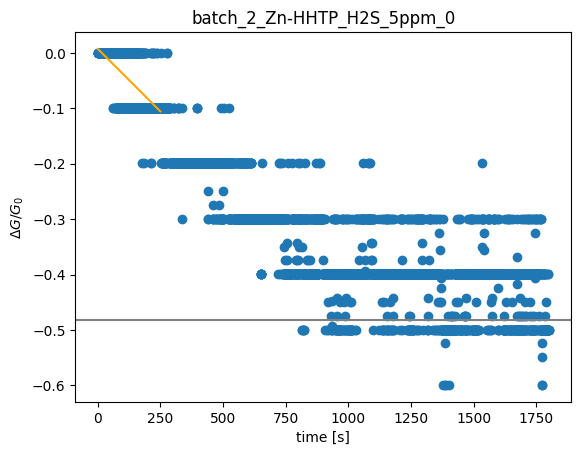

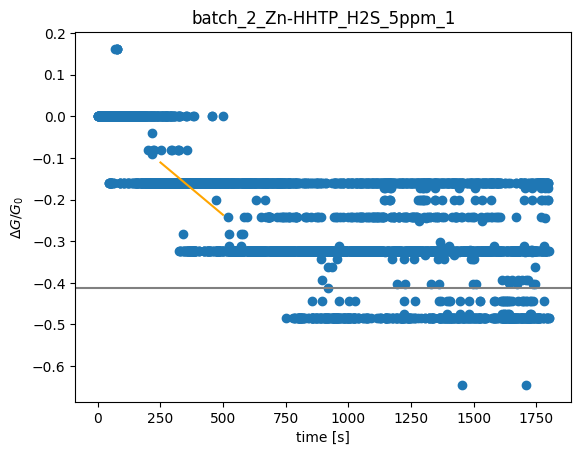

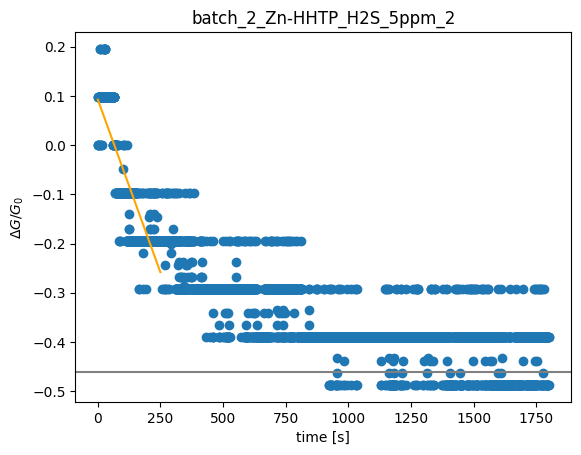

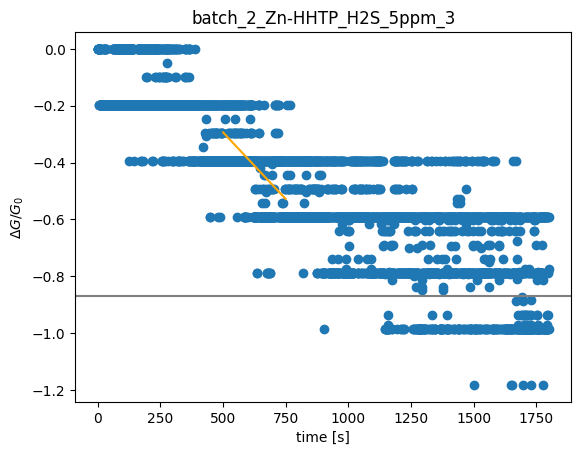

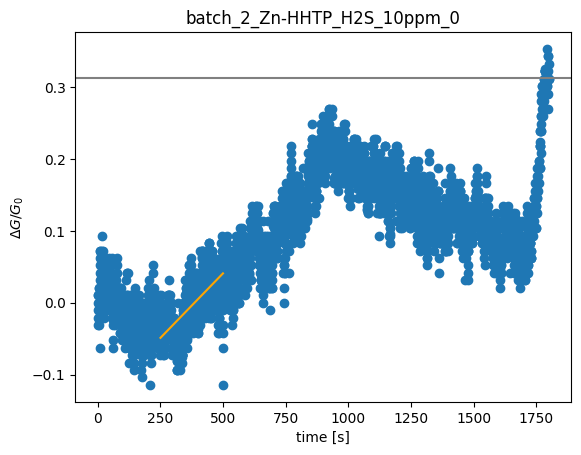

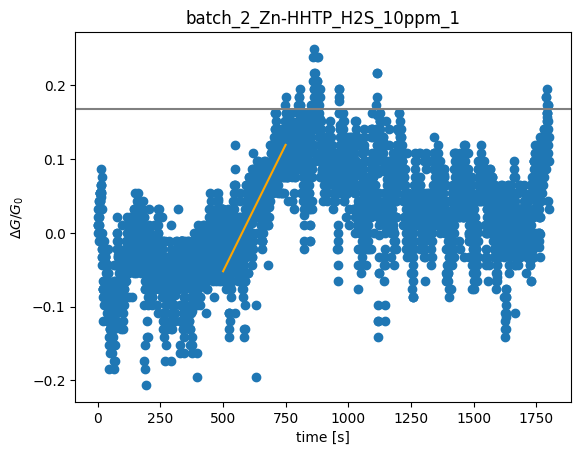

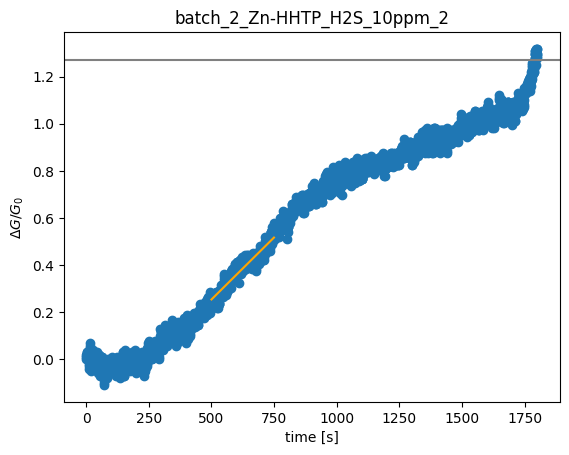

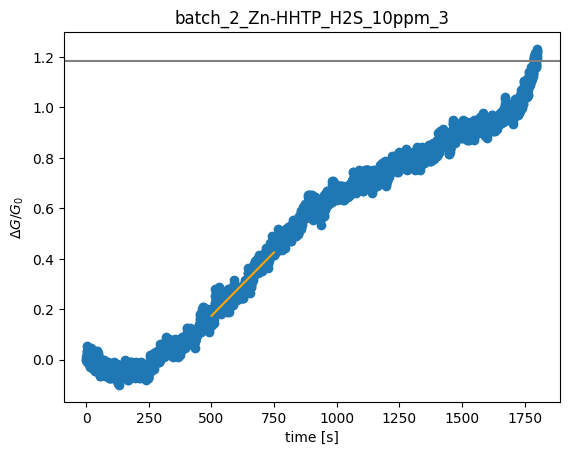

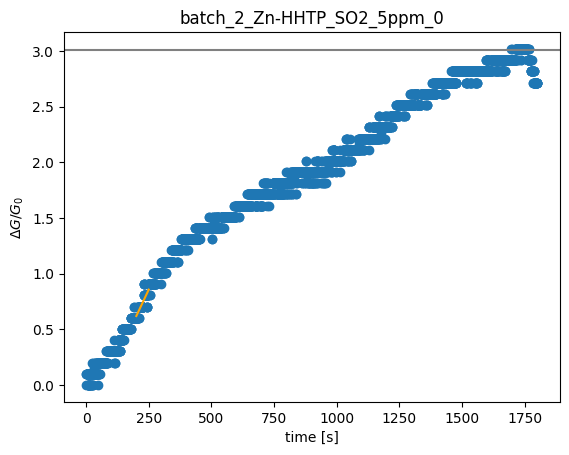

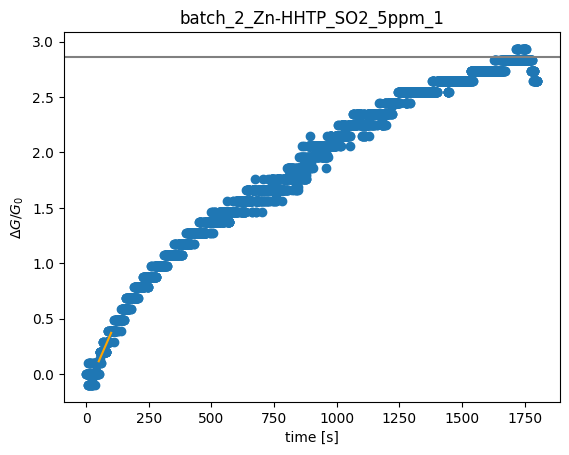

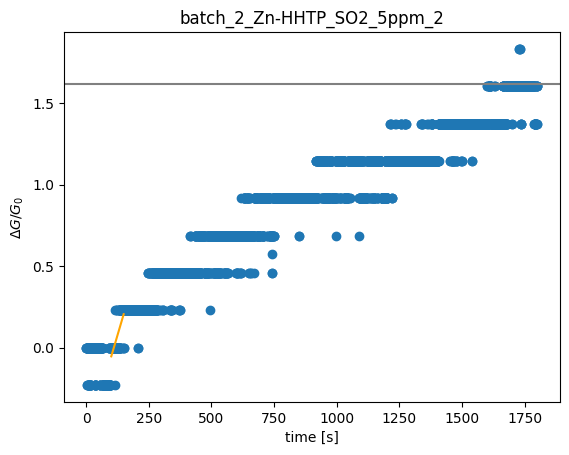

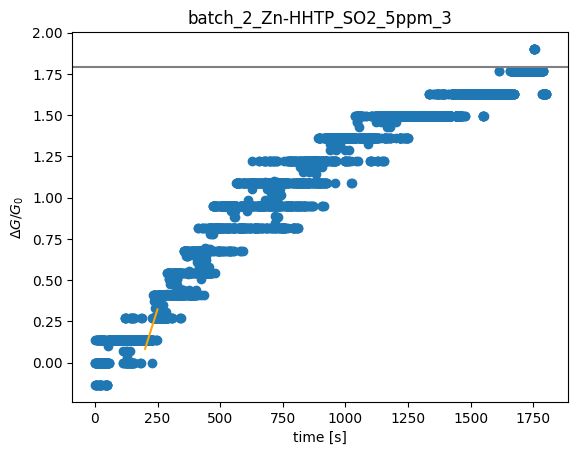

MOF      gas    ppm    folder  rep_id batch     slope  saturation  \
0    Cu-HHTP      H2S    0.5   batch_2       0  Cu-1  0.082859   71.646918   
1    Cu-HHTP      H2S    0.5   batch_2       1  Cu-1  0.081487   75.857183   
2    Cu-HHTP      H2S    0.5   batch_2       2  Cu-1  0.082835   72.600848   
3    Cu-HHTP      H2S    0.5   batch_2       3  Cu-1  0.075401   74.172221   
4    Cu-HHTP      H2S      5   batch_2       0  Cu-1  0.208299   93.948025   
..       ...      ...    ...       ...     ...   ...       ...         ...   
253  Zn-HHTP  H2S_SO2  36+22  mixtures       4  Zn-1  0.140214   28.138839   
254  Zn-HHTP  H2S_SO2  40+40  mixtures       0  Zn-1  0.204306   34.358037   
255  Zn-HHTP  H2S_SO2  40+40  mixtures       1  Zn-1  0.238722   36.029578   
256  Zn-HHTP  H2S_SO2  40+40  mixtures       2  Zn-1  0.253028   36.904915   
257  Zn-HHTP  H2S_SO2  40+40  mixtures       3  Zn-1  0.252932   37.686367   

               auc     mean_1  ...     mean_4     mean_5     mean_6  Cu-1  \
0     88532.726672  11.543287  ...  60.938566  66.983620  70.432612   1.0   
1     91710.455085  10.766787  ...  63.737166  70.662618  74.561454   1.0   
2     89045.111876  11.339587  ...  61.377185  67.695035  71.324317   1.0   
3     87970.577724   9.940622  ...  61.152509  68.512186  72.737813   1.0   
4    134957.215895  23.872341  ...  90.454925  92.691279  93.651651   1.0   
..             ...        ...  ...        ...        ...        ...   ...   
253   40040.881150  12.185949  ...  25.225564  26.769200  27.355944   0.0   
254   48224.836503  11.986551  ...  30.586550  32.374464  33.793526   0.0   
255   51155.279600  13.310922  ...  32.237975  34.019892  35.465791   0.0   
256   52285.602964  13.782368  ...  32.910662  34.684624  36.206331   0.0   
257   53446.531250  14.043520  ...  33.473316  35.535257  37.034425   0.0   

     Ni-1  Ni-2  Ni-3  Ni-4  Ni-5  Zn-1  
0     0.0   0.0   0.0   0.0   0.0   0.0  
1     0.0   0.0   0.0   0.0   0.0   0.0  
2     0.0   0.0   0.0   0.0   0.0   0.0  
3     0.0   0.0   0.0   0.0   0.0   0.0  
4     0.0   0.0   0.0   0.0   0.0   0.0  
..    ...   ...   ...   ...   ...   ...  
253   0.0   0.0   0.0   0.0   0.0   1.0  
254   0.0   0.0   0.0   0.0   0.0   1.0  
255   0.0   0.0   0.0   0.0   0.0   1.0  
256   0.0   0.0   0.0   0.0   0.0   1.0  
257   0.0   0.0   0.0   0.0   0.0   1.0  

[258 rows x 22 columns]

In [623]:
make_adjustment(data_df, MOF='Cu-HHTP', gas='H2S_SO2', ppm="9+13", folder="mixtures", rep_ids=[0, 1, 2, 3, 4], time_adjust=100)
make_adjustment(data_df, MOF='Cu-HHTP', gas='H2S_SO2', ppm="13+27", folder="mixtures", rep_ids=[0, 1, 2, 3, 4], time_adjust=100)
make_adjustment(data_df, MOF='Cu-HHTP', gas='H2S_SO2', ppm="18+4", folder="mixtures", rep_ids=[0, 1, 2, 3, 4], time_adjust=50)
make_adjustment(data_df, MOF='Cu-HHTP', gas='H2S_SO2', ppm="27+31", folder="mixtures", rep_ids=[0, 1, 2, 3, 4], time_adjust=50)
make_adjustment(data_df, MOF='Zn-HHTP', gas='H2S', ppm=5, folder="batch_2", rep_ids=[0, 1, 2, 3], n_partitions_slope_adj=3)
make_adjustment(data_df, MOF='Zn-HHTP', gas='H2S', ppm=10, folder="batch_2", rep_ids=[0, 1, 2, 3], n_partitions_slope_adj=3)
make_adjustment(data_df, MOF='Zn-HHTP', gas='SO2', ppm=5, folder="batch_2", rep_ids=[0, 1, 2, 3], time_adjust=150)

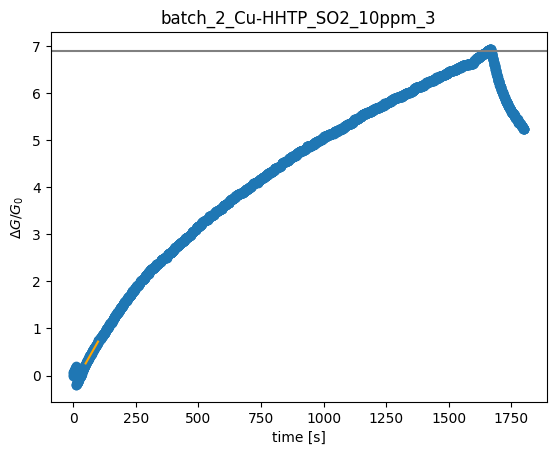

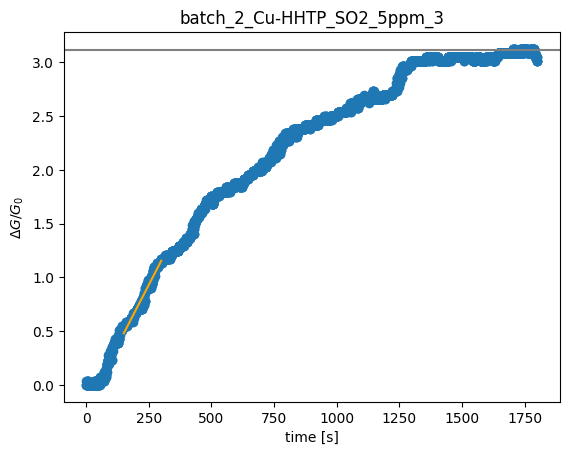

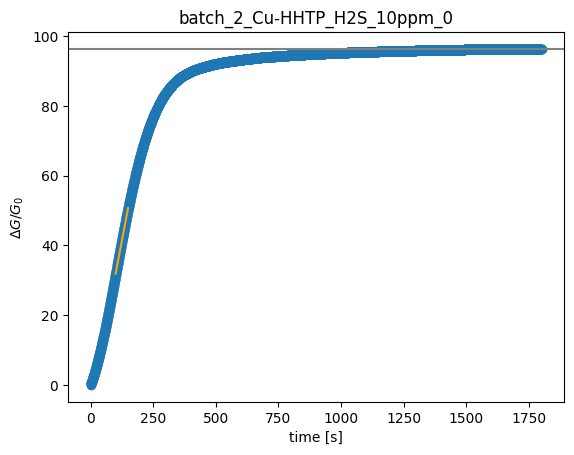

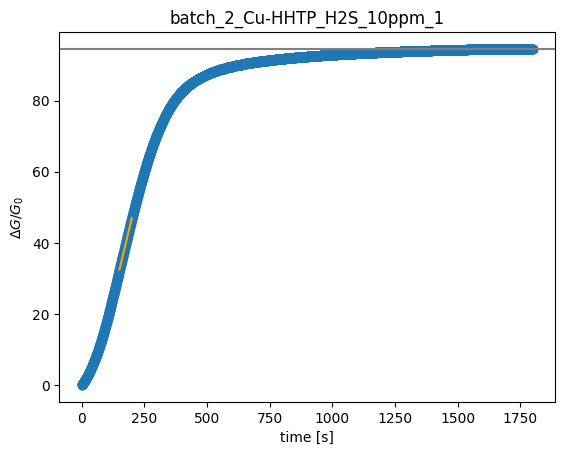

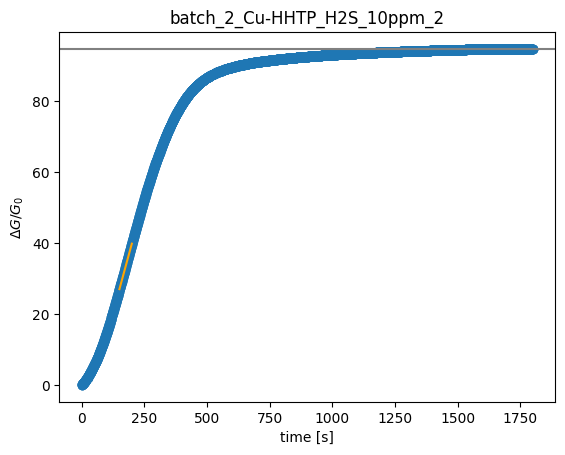

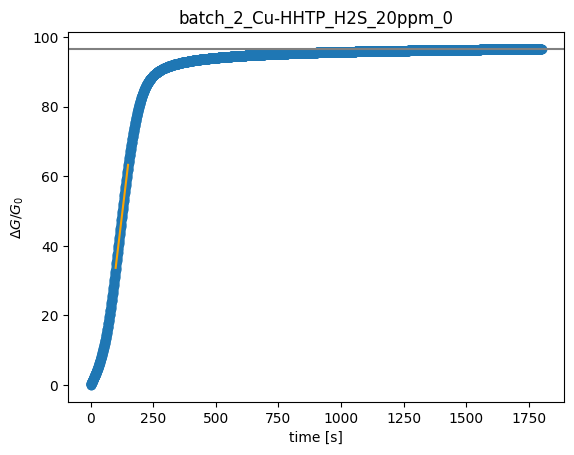

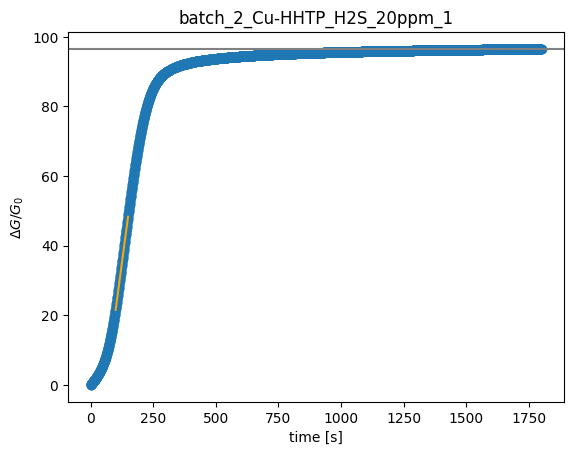

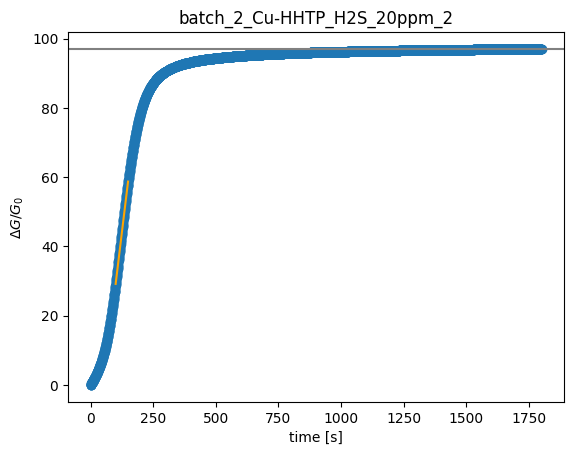

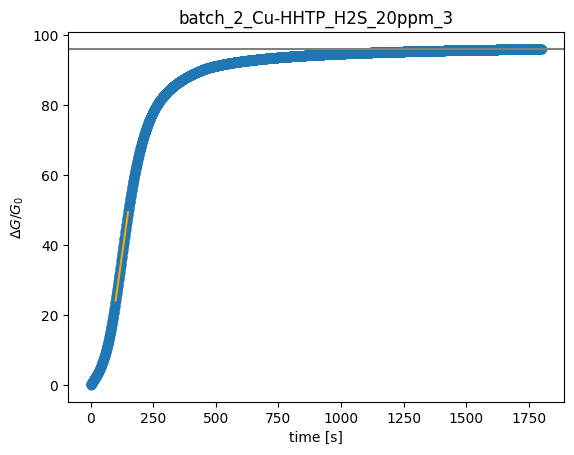

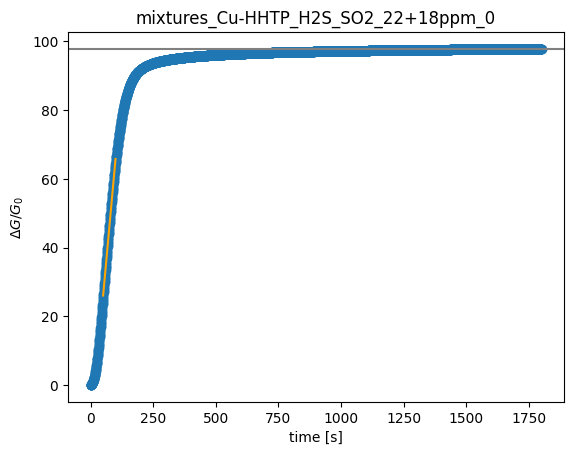

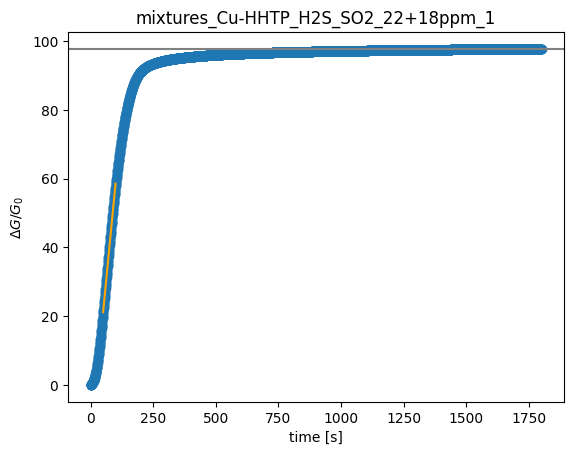

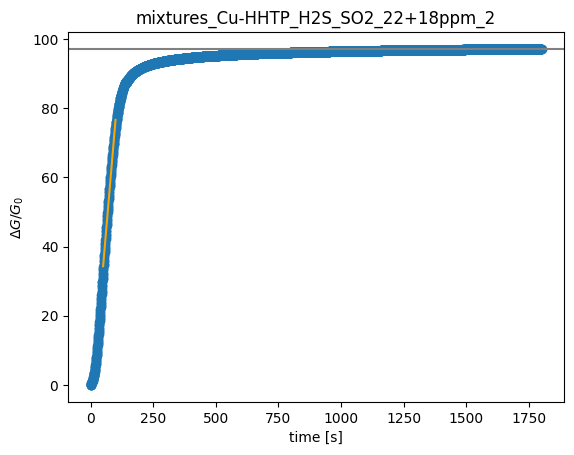

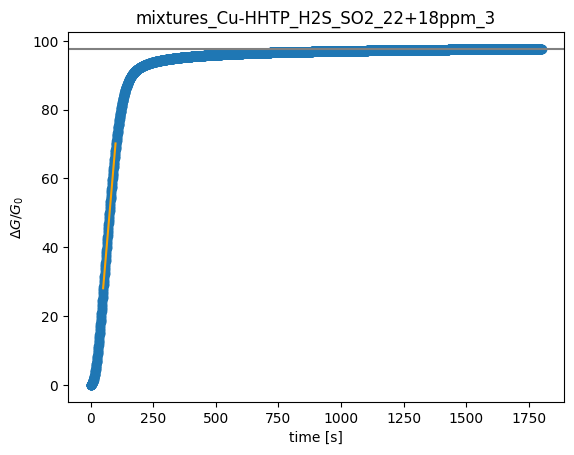

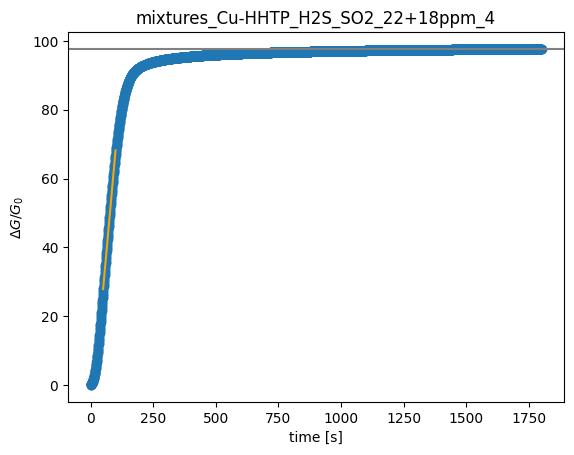

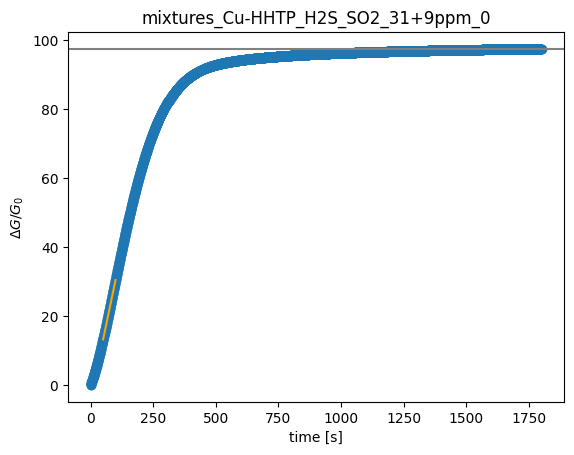

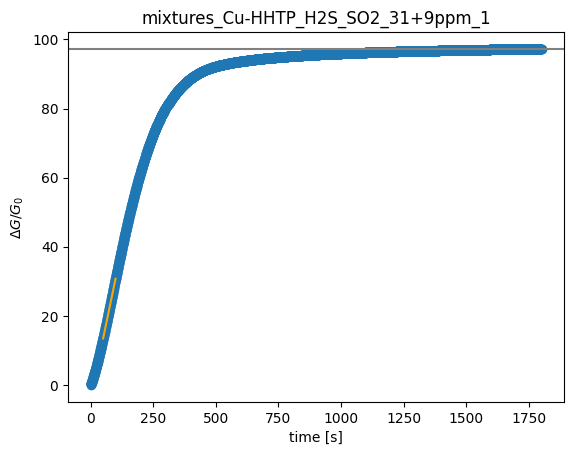

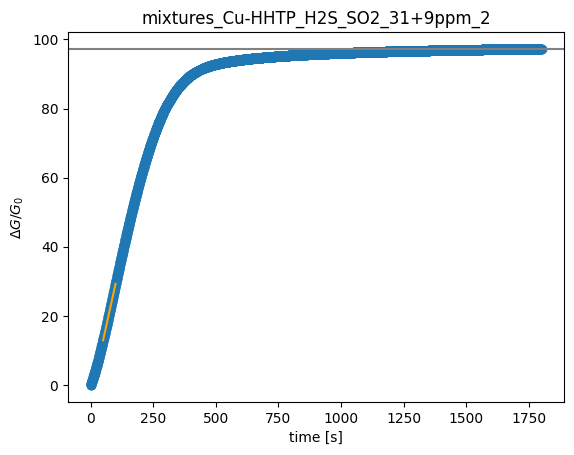

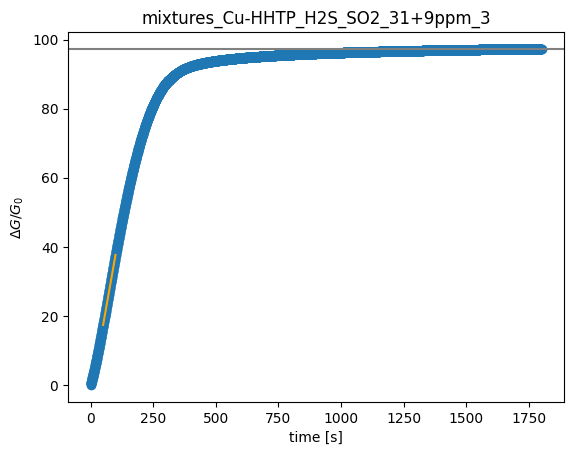

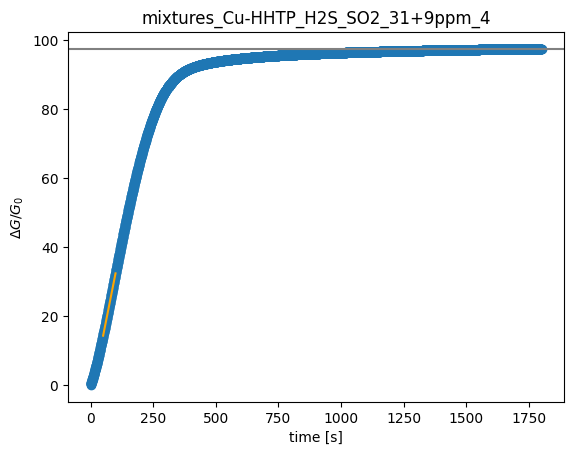

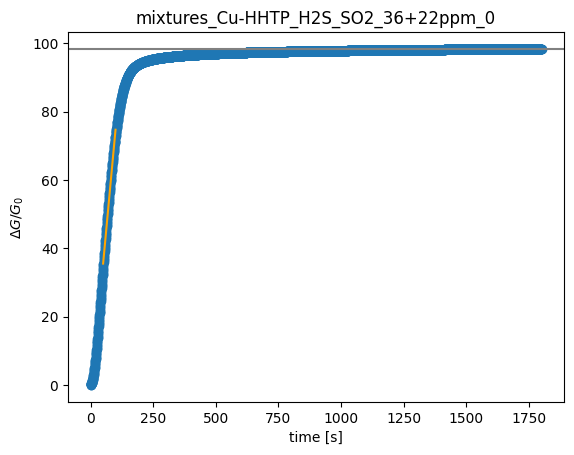

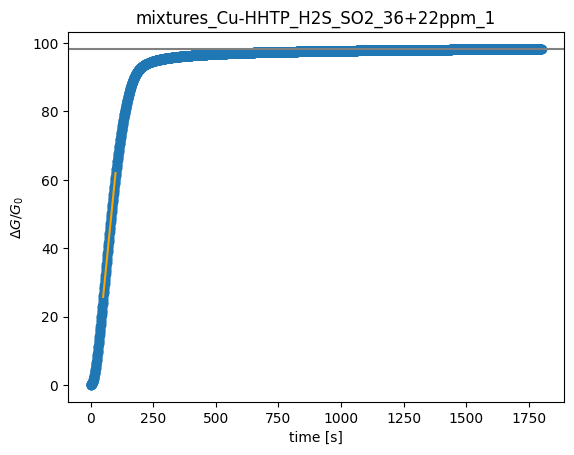

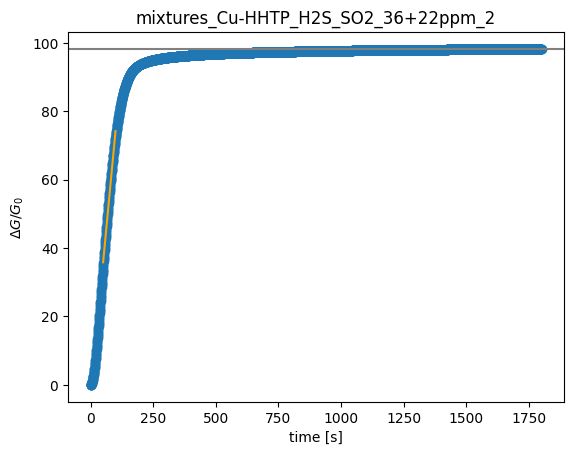

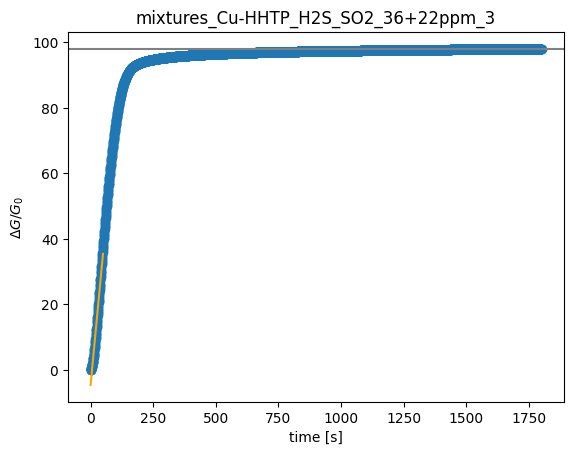

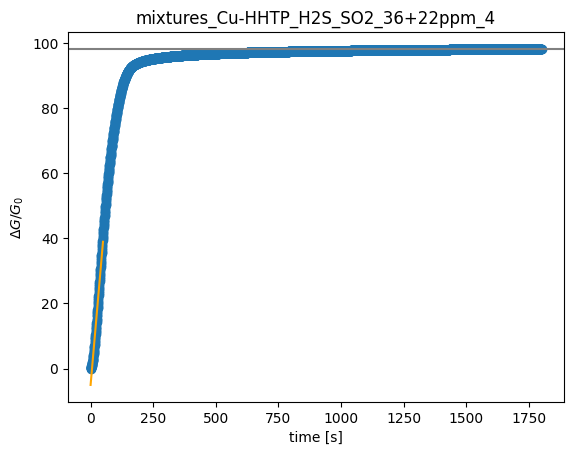

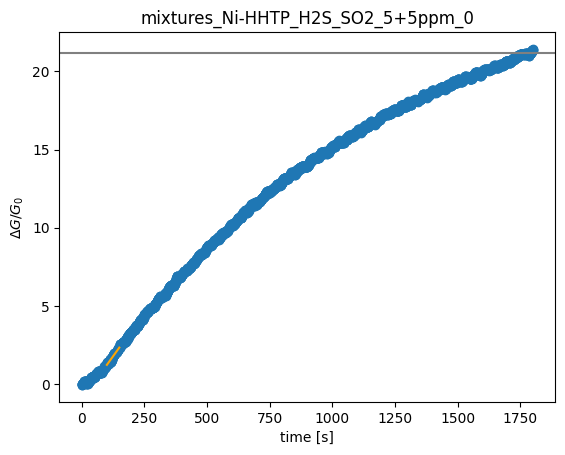

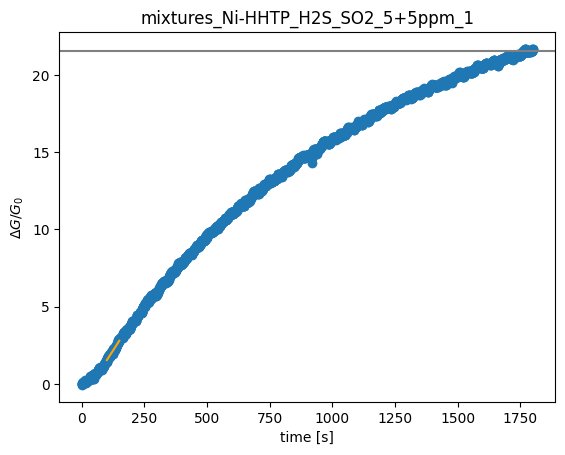

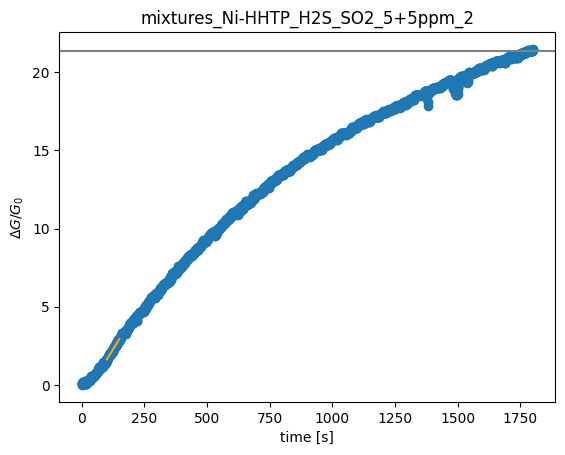

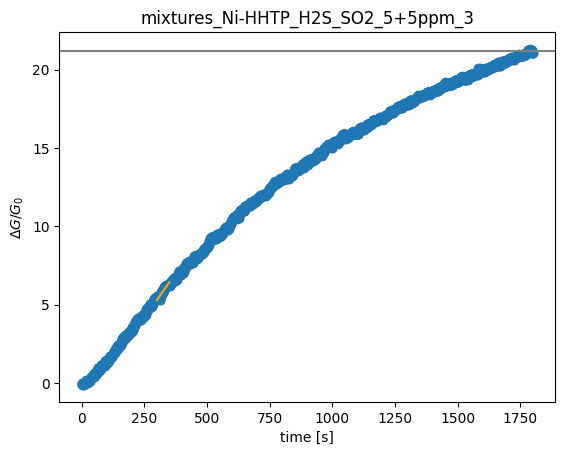

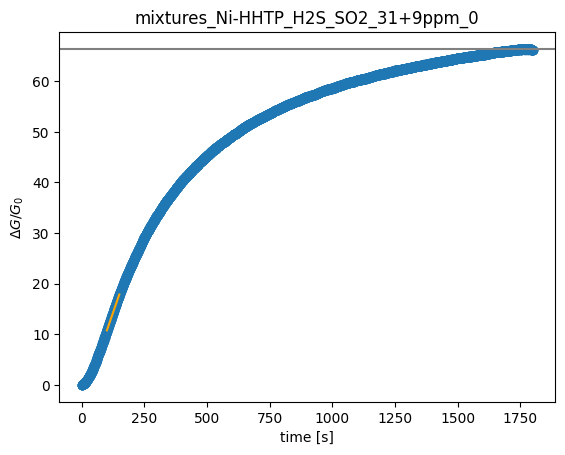

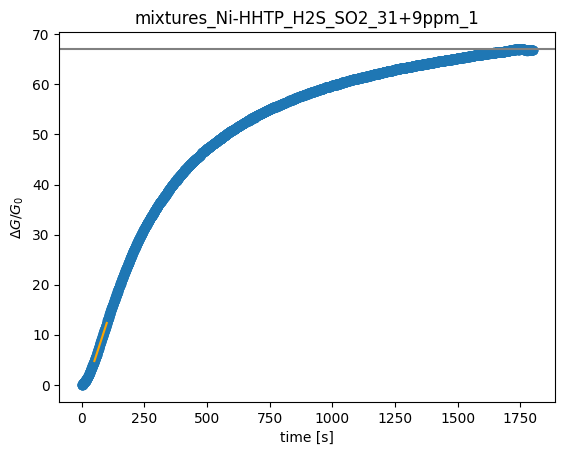

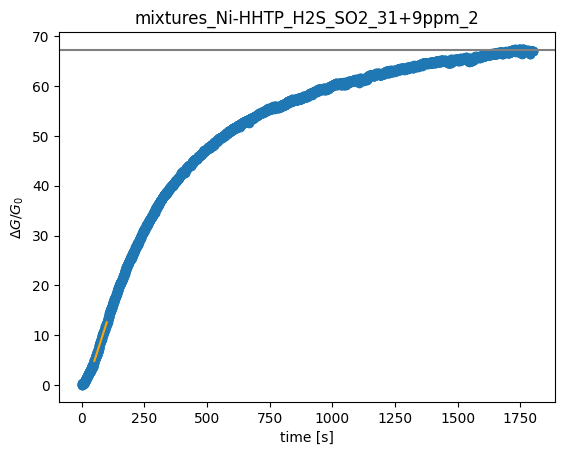

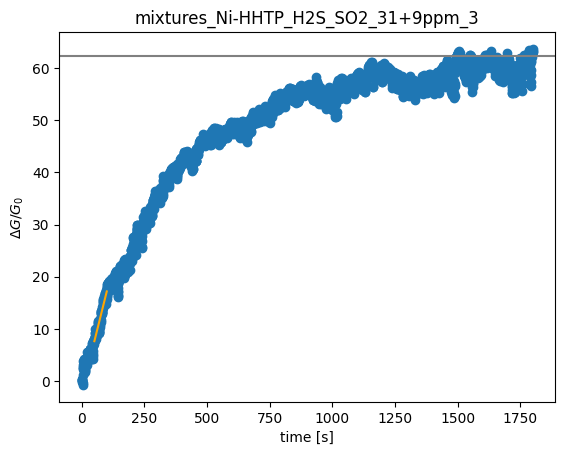

Error: replicate_id 4 does not exist for H2S_SO2  in Ni-HHTP at 31+9 ppm.


MOF      gas    ppm    folder  rep_id batch     slope  saturation  \
0    Cu-HHTP      H2S    0.5   batch_2       0  Cu-1  0.082859   71.646918   
1    Cu-HHTP      H2S    0.5   batch_2       1  Cu-1  0.081487   75.857183   
2    Cu-HHTP      H2S    0.5   batch_2       2  Cu-1  0.082835   72.600848   
3    Cu-HHTP      H2S    0.5   batch_2       3  Cu-1  0.075401   74.172221   
4    Cu-HHTP      H2S      5   batch_2       0  Cu-1  0.208299   93.948025   
..       ...      ...    ...       ...     ...   ...       ...         ...   
253  Zn-HHTP  H2S_SO2  36+22  mixtures       4  Zn-1  0.140214   28.138839   
254  Zn-HHTP  H2S_SO2  40+40  mixtures       0  Zn-1  0.204306   34.358037   
255  Zn-HHTP  H2S_SO2  40+40  mixtures       1  Zn-1  0.238722   36.029578   
256  Zn-HHTP  H2S_SO2  40+40  mixtures       2  Zn-1  0.253028   36.904915   
257  Zn-HHTP  H2S_SO2  40+40  mixtures       3  Zn-1  0.252932   37.686367   

               auc     mean_1  ...     mean_4     mean_5     mean_6  Cu-1  \
0     88532.726672  11.543287  ...  60.938566  66.983620  70.432612   1.0   
1     91710.455085  10.766787  ...  63.737166  70.662618  74.561454   1.0   
2     89045.111876  11.339587  ...  61.377185  67.695035  71.324317   1.0   
3     87970.577724   9.940622  ...  61.152509  68.512186  72.737813   1.0   
4    134957.215895  23.872341  ...  90.454925  92.691279  93.651651   1.0   
..             ...        ...  ...        ...        ...        ...   ...   
253   40040.881150  12.185949  ...  25.225564  26.769200  27.355944   0.0   
254   48224.836503  11.986551  ...  30.586550  32.374464  33.793526   0.0   
255   51155.279600  13.310922  ...  32.237975  34.019892  35.465791   0.0   
256   52285.602964  13.782368  ...  32.910662  34.684624  36.206331   0.0   
257   53446.531250  14.043520  ...  33.473316  35.535257  37.034425   0.0   

     Ni-1  Ni-2  Ni-3  Ni-4  Ni-5  Zn-1  
0     0.0   0.0   0.0   0.0   0.0   0.0  
1     0.0   0.0   0.0   0.0   0.0   0.0  
2     0.0   0.0   0.0   0.0   0.0   0.0  
3     0.0   0.0   0.0   0.0   0.0   0.0  
4     0.0   0.0   0.0   0.0   0.0   0.0  
..    ...   ...   ...   ...   ...   ...  
253   0.0   0.0   0.0   0.0   0.0   1.0  
254   0.0   0.0   0.0   0.0   0.0   1.0  
255   0.0   0.0   0.0   0.0   0.0   1.0  
256   0.0   0.0   0.0   0.0   0.0   1.0  
257   0.0   0.0   0.0   0.0   0.0   1.0  

[258 rows x 22 columns]

In [624]:
make_adjustment(data_df, MOF='Cu-HHTP', gas='SO2', ppm=10, folder="batch_2", rep_ids=[3], time_adjust=200)
make_adjustment(data_df, MOF='Cu-HHTP', gas='SO2', ppm=5, folder="batch_2", rep_ids=[3], n_partitions_slope_adj=5)
make_adjustment(data_df, MOF='Cu-HHTP', gas='H2S', ppm=10, folder="batch_2", rep_ids=[0, 1, 2], time_adjust=200)
make_adjustment(data_df, MOF='Cu-HHTP', gas='H2S', ppm=20, folder="batch_2", rep_ids=[0, 1, 2, 3], time_adjust=200)
make_adjustment(data_df, MOF='Cu-HHTP', gas='H2S_SO2', ppm="22+18", folder="mixtures", rep_ids=[0, 1, 2, 3, 4], time_adjust=100)
make_adjustment(data_df, MOF='Cu-HHTP', gas='H2S_SO2', ppm="31+9", folder="mixtures", rep_ids=[0, 1, 2, 3, 4],  time_adjust=100)
make_adjustment(data_df, MOF='Cu-HHTP', gas='H2S_SO2', ppm="36+22", folder="mixtures", rep_ids=[0, 1, 2, 3, 4],  time_adjust=50)
make_adjustment(data_df, MOF='Ni-HHTP', gas='H2S_SO2', ppm="5+5", folder="mixtures", rep_ids=[0, 1, 2, 3],  time_adjust=100)
make_adjustment(data_df, MOF='Ni-HHTP', gas='H2S_SO2', ppm="31+9", folder="mixtures", rep_ids=[0, 1, 2, 3, 4], time_adjust=50)

In [625]:
# update csv with adjusted responses
data_df.to_csv("responses.csv")

# Function to assemble and standardize complete array response vectors

In [626]:
def assemble_array_response(data_df, gases=gases,
                            ppms=ppms, MOFs=MOFs, folders=folders, n_replicates=7, features=features):
    #  matrix will store response features.
    #  col = sensor array response vector
    #  row = particular response feature for a particular MOF (9. 3 MOFs x 3 feature each)
    #  loop through data to build matrix column by column (technically row by row and then transpose)

    matrix = []
    experiments = [] # List which will store experiment setup for each array column


    for gas in gases:
        for ppm in ppms:
            for folder in folders:
                for rep in range(n_replicates):
                    col = []
                    batches = []
                    experiment = {'gas': gas,
                                'ppm': ppm,
                                "folder" : folder,
                                'rep_id': rep}
                    filtered_data = data_df.loc[(data_df['gas']==gas)
                                            & (data_df['ppm']==ppm)
                                            & (data_df['rep_id']==rep)
                                            & (data_df['folder']==folder)]
                    # batches = filtered_data[['Ni-2', 'Ni-3', 'Ni-4', 'Ni-5']].sum(axis=0) # Only Ni have multiple batches and batch 1 is removed
                    # , 


                    for MOF in MOFs:
                        for (i, feature) in enumerate(["mean_1", "mean_2", "mean_3", "mean_4", "mean_5", "mean_6"]):
                            # try to access matching data and append to column
                            try:
                                # print((gas, MOF, rep, folder, ppm))
                                val = data_df.loc[(data_df['gas']==gas)
                                            & (data_df['MOF']==MOF)
                                            & (data_df['ppm']==ppm)
                                            & (data_df['rep_id']==rep)
                                            & (data_df['folder']==folder)][feature].iloc[0]
                                col.append(val)
                            except (IndexError, KeyError):
                                pass
                        
                    # only append column if entire array response exists
                    if len(col) == len(MOFs) * len(["mean_1", "mean_2", "mean_3", "mean_4", "mean_5", "mean_6"]):
                        col.extend(batches)
                        matrix.append(col)
                        experiments.append(experiment)
                    else:
                        print("No complete array for experiment: ", experiment)

    matrix = np.array(matrix)

    response_array = pd.DataFrame(matrix)

    return experiments, response_array

In [627]:
experiments, response_array = assemble_array_response(data_df)
                                                    #   [~data_df["batch"].isin(["Ni-1", "Ni-3", "Ni-4", "Ni-5"])])
                                                    #   , MOFs=["Cu-HHTP", "Zn-HHTP"],)
                                                    #   features=["slope", "saturation"] )
                                                    #   MOFs=["Cu-HHTP", "Zn-HHTP"])
                                                    #    features=["saturation", "slope"])
                                                    #   MOFs=["Cu-HHTP", "Zn-HHTP"])
                                                    #   )["saturation", "auc"]
                                                        #   ["saturation", "slope"])
                                                        # ["saturation", "slope"]

No complete array for experiment:  {'gas': 'H2S', 'ppm': 0.5, 'folder': 'batch_2', 'rep_id': 0}
No complete array for experiment:  {'gas': 'H2S', 'ppm': 0.5, 'folder': 'batch_2', 'rep_id': 1}
No complete array for experiment:  {'gas': 'H2S', 'ppm': 0.5, 'folder': 'batch_2', 'rep_id': 2}
No complete array for experiment:  {'gas': 'H2S', 'ppm': 0.5, 'folder': 'batch_2', 'rep_id': 3}
No complete array for experiment:  {'gas': 'H2S', 'ppm': 0.5, 'folder': 'batch_2', 'rep_id': 4}
No complete array for experiment:  {'gas': 'H2S', 'ppm': 0.5, 'folder': 'batch_2', 'rep_id': 5}
No complete array for experiment:  {'gas': 'H2S', 'ppm': 0.5, 'folder': 'batch_2', 'rep_id': 6}
No complete array for experiment:  {'gas': 'H2S', 'ppm': 0.5, 'folder': 'mixtures', 'rep_id': 0}
No complete array for experiment:  {'gas': 'H2S', 'ppm': 0.5, 'folder': 'mixtures', 'rep_id': 1}
No complete array for experiment:  {'gas': 'H2S', 'ppm': 0.5, 'folder': 'mixtures', 'rep_id': 2}
No complete array for experiment:  {'

In [628]:
experiments_df = pd.DataFrame(experiments)

In [629]:
combo_df = experiments_df.join(response_array)

In [630]:
# split ppm column to individual H2S and SO2 concentrations
gas_conc = []
gas_pos = {"H2S" : 0, "SO2" : 1}
for exp in experiments:
    conc = exp["ppm"]
    y = np.zeros(2)
    if isinstance(conc, int) or isinstance(conc, float):
        y[gas_pos[exp["gas"]]] = conc
        gas_conc.append(y)
    else: 
        for (i, c) in enumerate(conc.split("+")):
            y[i] = int(c)
        gas_conc.append(y)
gas_conc = np.vstack(gas_conc)
combo_df["H2S"] = gas_conc[:, 0]
combo_df["SO2"] = gas_conc[:, 1]

# Create heatmap of 3-mof array feature values

In [631]:
# transpose to get complete arrays as columns for heatmap
heatmatrixdf = combo_df.sort_values(by=["H2S", "SO2"], ascending=False) # sort by H2S and SO2 concentrations


In [632]:
def gas_to_subscript(gas):
    sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    return gas.translate(sub)

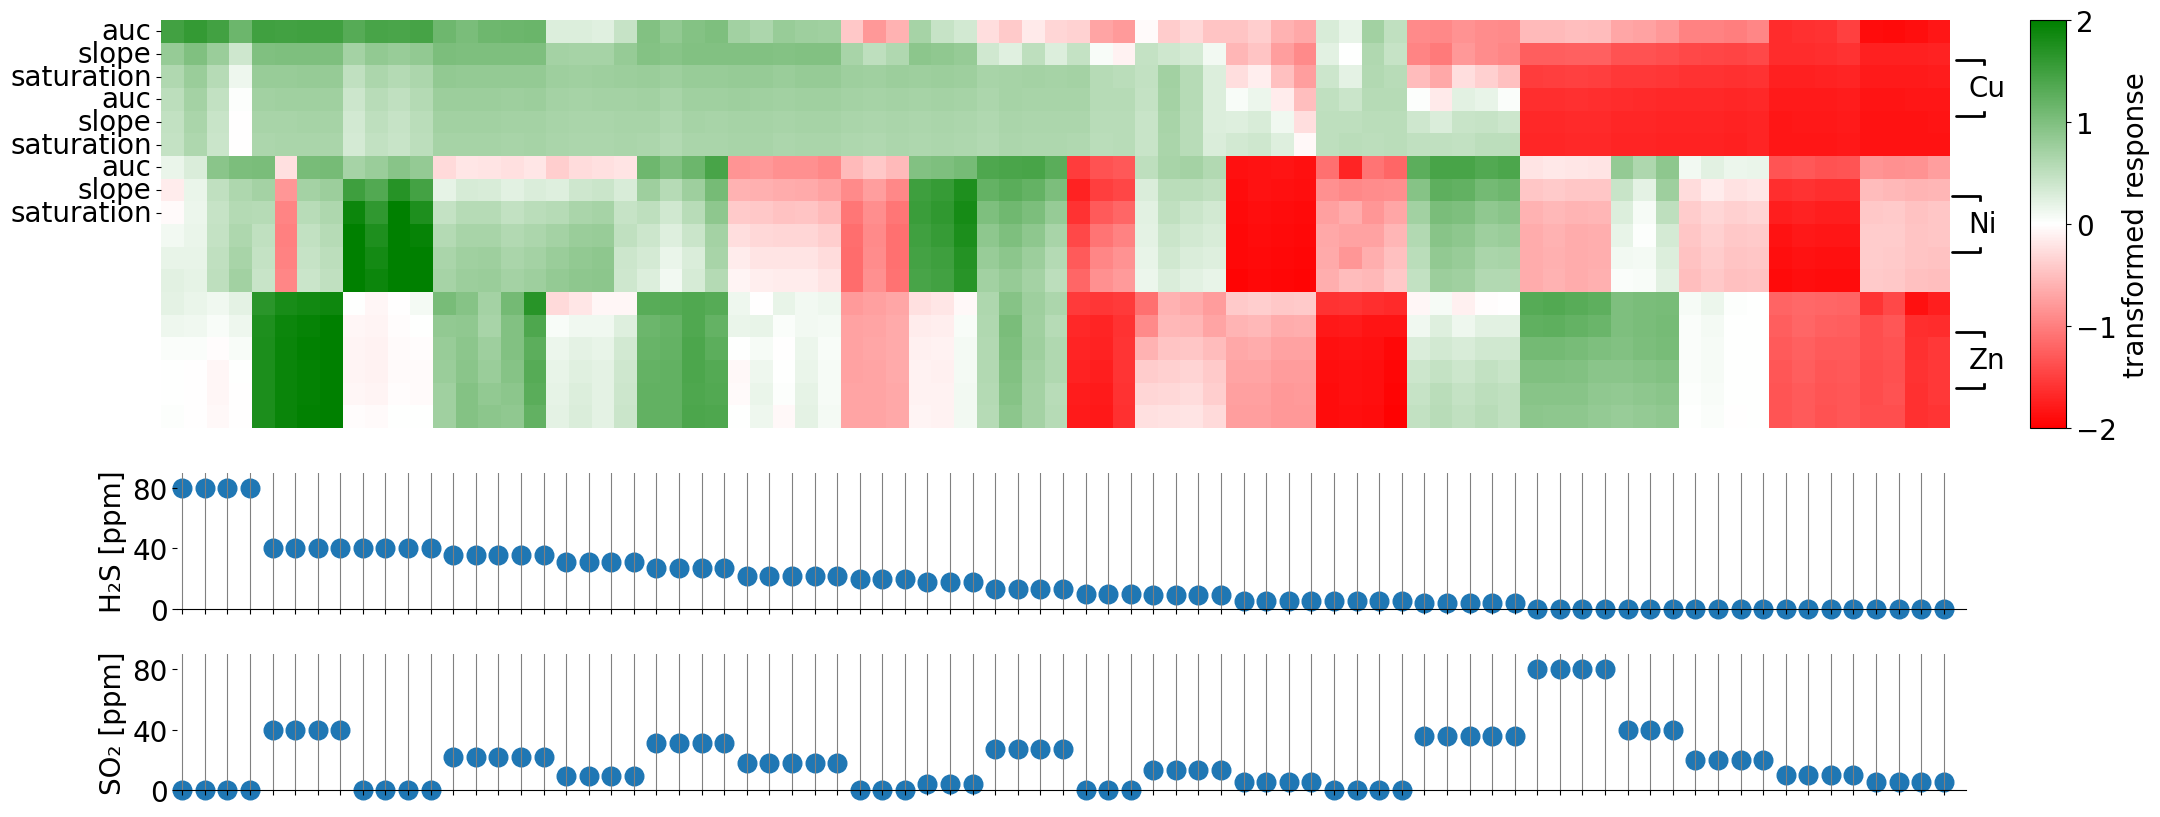

In [633]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


RdGn = cmap = LinearSegmentedColormap.from_list("mycmap", ["red", "white", "green"])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(28, 10), gridspec_kw={'height_ratios':[3, 1, 1]})

# font size
fs = 20

# tick labels for features (A: area under curve, E: initial slope, S: saturation)
yticklabels = ['auc', 'slope', 'saturation'] * 3

# count number of experiments for each type of gas
gas_counts = {gas: sum(exp.get('gas') == gas for exp in experiments) for gas in gases}

# create heatmap
heat_matrix_plot = PowerTransformer().fit_transform(heatmatrixdf[response_array.columns]).T
heat = sns.heatmap(heat_matrix_plot, cmap=RdGn, center=0, yticklabels=yticklabels, vmin=-2, vmax=2,
                 square=True, ax=ax1, cbar=False)

# create a new axes for the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.8)  # increase pad to move colorbar further right

# add colorbar to the new axes
cbar = fig.colorbar(heat.collections[0], cax=cax)

# adjust colorbar ticks
cbar.ax.tick_params(labelsize=fs)
cbar.set_ticks([-2, -1, 0, 1, 2])

# add colorbar label
cbar.set_label(label='transformed response', size=fs)

# label the cofs:
ax1.annotate('Cu', xy=(1.01, 7.5/9), xycoords='axes fraction',
            fontsize=fs, ha='left', va='center',
            bbox=dict(boxstyle='square', ec='white', fc='white', color='k'),
            arrowprops=dict(arrowstyle=']- ,widthA=1., lengthA=1, angleA=180', lw=2, color='k'))

ax1.annotate('Ni', xy=(1.01, 4.5/9), xycoords='axes fraction',
            fontsize=fs, ha='left', va='center',
            bbox=dict(boxstyle='square', ec='white', fc='white', color='k'),
            arrowprops=dict(arrowstyle=']- ,widthA=1., lengthA=1, angleA=180', lw=2, color='k'))

ax1.annotate('Zn', xy=(1.01, 1.5/9), xycoords='axes fraction',
            fontsize=fs, ha='left', va='center',
            bbox=dict(boxstyle='square', ec='white', fc='white', color='k'),
            arrowprops=dict(arrowstyle=']- ,widthA=1., lengthA=1, angleA=180', lw=2, color='k'))

ax1.set_xticks([])
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=fs)

# create scatter ppm plot
exps = pd.DataFrame(experiments)
for (ax, gas) in zip((ax2, ax3), ("H2S", "SO2")):
    ax.scatter(x=np.arange(0, len(heatmatrixdf)), y=heatmatrixdf[gas], s=180, clip_on=False)
    ax.set_xlim(ax1.get_xlim())
    ax.set_ylabel(f"{gas_to_subscript(gas)} [ppm]", fontsize=fs)
    ax.tick_params(axis='both', which='both', labelsize=fs)
    ax.set_xticks(ticks=np.arange(0, len(heatmatrixdf)), labels=[])

    # adjust the position of ax2 to align with ax1
    pos1 = ax1.get_position()
    pos2 = ax.get_position()
    ax.set_position([pos1.x0-0.015, pos2.y0, pos1.width, pos2.height])


    # make ppm plot nice
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlim(left=-0.22)
    ax.set_ylim(top=90, bottom=-0.1)

    ax.grid(axis='x', color='grey')
    ax.set_yticks(ticks=[80,40,0])
plt.savefig("heatmap.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

# Supervised learning predict gas concentration

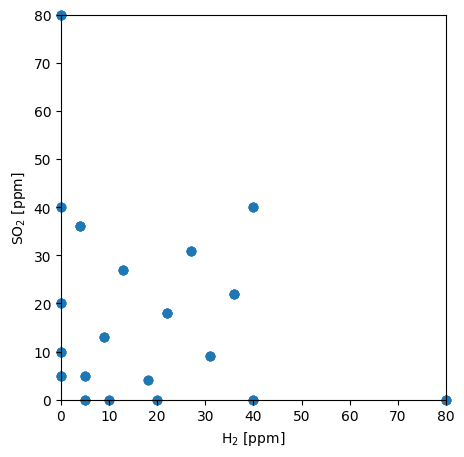

In [634]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(x=heatmatrixdf["H2S"], y=heatmatrixdf["SO2"], clip_on=False)
ax.set_xlabel("H$_2$ [ppm]")
ax.set_ylabel("SO$_2$ [ppm]")
ax.set_xlim(0, 80)
ax.set_ylim(0, 80)
ax.set_aspect('equal', "box")
plt.show();

In [635]:
combo_df.head()

gas ppm   folder  rep_id          0          1          2          3  \
0  H2S   5  batch_2       0  23.872341  65.426037  83.757133  90.454925   
1  H2S   5  batch_2       1  20.501634  57.583685  77.826124  88.418097   
2  H2S   5  batch_2       2  37.445084  80.535494  89.922661  92.394515   
3  H2S   5  batch_2       3  29.012289  74.117984  88.471409  92.261909   
4  H2S  10  batch_2       0  10.666552  74.440319  93.300445  95.267111   

           4          5  ...         10         11        12        13  \
0  92.691279  93.651651  ...  41.313505  44.452801 -0.065754 -0.217181   
1  92.846884  94.298005  ...  38.858602  46.014823 -0.053363 -0.206594   
2  93.499019  94.136518  ...  41.739412  45.578793 -0.100877 -0.279331   
3  93.605873  94.320622  ...  44.174222  47.679176 -0.133774 -0.285262   
4  96.066930  96.525425  ...  30.676365  34.956878 -0.015925  0.016199   

         14        15        16        17   H2S  SO2  
0 -0.328165 -0.397030 -0.418517 -0.420828   5.0  0.0  
1 -0.282946 -0.313535 -0.307512 -0.335463   5.0  0.0  
2 -0.343263 -0.395843 -0.401742 -0.424809   5.0  0.0  
3 -0.488713 -0.618875 -0.708719 -0.772448   5.0  0.0  
4  0.121402  0.184627  0.125287  0.121914  10.0  0.0  

[5 rows x 24 columns]

In [636]:
_combo_df = combo_df[(combo_df["H2S"]!=80) & (combo_df["SO2"]!=80)]

In [637]:
conc_pred_df = {"H2S" : {"true" :np.array([]), "pred" : np.array([])},
                "SO2" : {"true" :np.array([]), "pred" : np.array([])}}
for gas in ["H2S", "SO2"]:
    set_ppm = set(_combo_df[gas])
    for ppm in set_ppm:
        if ppm in [min(set_ppm), max(set_ppm)]:
            continue
        else:
            try:
                test_ids = _combo_df[gas] == ppm
                train_ids = ~test_ids
                model = ExtraTreesRegressor(random_state=0, n_estimators=500)
                print("Fitting model for ", gas, f"at {ppm} ppm")

                X_train = _combo_df.loc[train_ids, response_array.columns]
                X_test = _combo_df.loc[test_ids, response_array.columns]
                y_train = _combo_df.loc[train_ids, [gas]]

                model.fit(X_train, np.ravel(y_train))
                pred = model.predict(X_test)
                conc_pred_df[gas]["pred"] = np.append(conc_pred_df[gas]["pred"], pred)
                conc_pred_df[gas]["true"] = np.append(conc_pred_df[gas]["true"], _combo_df.loc[test_ids, [gas]])
            except:
                print("No data for ", gas, ppm)
# conc_pred_df = pd.DataFrame(conc_pred_df)

Fitting model for  H2S at 4.0 ppm
Fitting model for  H2S at 5.0 ppm
Fitting model for  H2S at 36.0 ppm
Fitting model for  H2S at 9.0 ppm
Fitting model for  H2S at 10.0 ppm
Fitting model for  H2S at 13.0 ppm
Fitting model for  H2S at 18.0 ppm
Fitting model for  H2S at 20.0 ppm
Fitting model for  H2S at 22.0 ppm
Fitting model for  H2S at 27.0 ppm
Fitting model for  H2S at 31.0 ppm
Fitting model for  SO2 at 36.0 ppm
Fitting model for  SO2 at 5.0 ppm
Fitting model for  SO2 at 4.0 ppm
Fitting model for  SO2 at 9.0 ppm
Fitting model for  SO2 at 10.0 ppm
Fitting model for  SO2 at 13.0 ppm
Fitting model for  SO2 at 18.0 ppm
Fitting model for  SO2 at 20.0 ppm
Fitting model for  SO2 at 22.0 ppm
Fitting model for  SO2 at 27.0 ppm
Fitting model for  SO2 at 31.0 ppm


In [589]:
# conc_pred_df = {"H2S" : np.zeros(len(combo_df)), "SO2" : np.zeros(len(combo_df))}
# for (H2S_ppm, SO2_ppm) in np.unique(combo_df[['H2S', 'SO2']].values, axis=0):
#         try:
#            test_ids = (combo_df["H2S"] == H2S_ppm) & (combo_df["SO2"] == SO2_ppm)
#            train_ids = ~test_ids
#            model = ExtraTreesRegressor(n_estimators=500, random_state=0)
#          #   RandomForestRegressor(random_state=0, n_estimators=500)
#            print("Fitting model for ", H2S_ppm, "ppm H2S and", SO2_ppm, "ppm SO2")

#            X_train = combo_df.loc[train_ids, response_array.columns]
#            X_test = combo_df.loc[test_ids, response_array.columns]
#            y_train = combo_df.loc[train_ids, ["H2S", "SO2"]]
           
#            model.fit(X_train, y_train)
#            pred = model.predict(X_test)
#            conc_pred_df["H2S"][test_ids] = pred[:, 0]
#            conc_pred_df["SO2"][test_ids] = pred[:, 1] 
#         except:
#             print("No data for ", gas, ppm)
# conc_pred_df = pd.DataFrame(conc_pred_df)

In [638]:
def NRMSE(true_ppm, pred_ppm):

    # diff = (true_ppm - pred_ppm) ** 2 
    # NRMSE = np.sqrt(np.mean(diff) / np.var(true_ppm))
    return np.mean(abs(true_ppm - pred_ppm) )
 

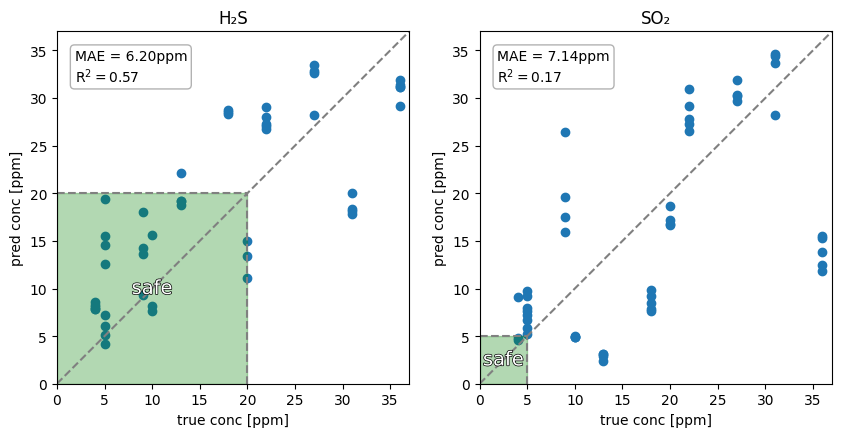

In [639]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
per_limit = {"H2S" : 20, "SO2" : 5}
for i, gas in enumerate(["H2S", "SO2"]):
    true, pred = conc_pred_df[gas]["true"], conc_pred_df[gas]["pred"]
    clip = max(max(true), max(pred))
    txt = axs[i].text(per_limit[gas] / 2, per_limit[gas] / 2, "safe", ha="center", va="center", fontsize=14, color="white")
    txt.set_path_effects([path_effects.Stroke(linewidth=1, foreground="black"),
                                  path_effects.Normal()])
    axs[i].plot([0.0, clip + 1], [0.0, clip + 1], linestyle="dashed", color="grey")
    axs[i].scatter(true, pred, clip_on=False)
    axs[i].vlines(per_limit[gas], ymin=0, ymax=per_limit[gas], linestyle="--", color="grey")
    axs[i].hlines(per_limit[gas], xmin=0, xmax=per_limit[gas], linestyle="--", color="grey")
    axs[i].fill_between([0, per_limit[gas]], 0, y2=per_limit[gas], color=('green', 0.3))
    axs[i].set_xlabel("true conc [ppm]")
    axs[i].set_ylabel("pred conc [ppm]")
    axs[i].set_title(gas_to_subscript(gas))
    axs[i].set_xlim(0, clip + 1), 
    axs[i].set_ylim(0, clip + 1)
    axs[i].set_aspect('equal', "box")

    textstr = "\n".join(
                (  
                    "MAE = %.2fppm" % NRMSE(true, pred),
                    r"R$^2=%.2f$" % r2_score(true, pred),
                )
            )

    props = dict(boxstyle="round", facecolor="white", alpha=0.3)

    axs[i].text(
                0.05,
                0.95,
                textstr,
                transform=axs[i].transAxes,
                fontsize=10,
                verticalalignment="top",
                bbox=props,
            )
# plt.savefig("concentration_predictions.png")

# Treat problem as a classification problem

In [227]:
combo_df.head()

gas ppm   folder  rep_id              0         1          2             3  \
0  H2S   5  batch_2       0  134957.215895  0.208299  93.948025  55375.195182   
1  H2S   5  batch_2       1  129443.366554  0.178652  94.656795  53860.621704   
2  H2S   5  batch_2       2  146382.872948  0.355665  94.356884  55161.685615   
3  H2S   5  batch_2       3  141538.387823  0.289133  94.558510  57692.559525   
4  H2S  10  batch_2       0  155648.580185  0.379269  96.304885  36036.367742   

          4          5           6         7         8   H2S  SO2  
0  0.072054  45.523891 -554.192493 -0.000452 -0.482718   5.0  0.0  
1  0.057725  47.727005 -449.847977 -0.000504 -0.412495   5.0  0.0  
2  0.076683  46.874288 -583.782018 -0.001404 -0.460220   5.0  0.0  
3  0.086964  49.119797 -902.412514 -0.000938 -0.869400   5.0  0.0  
4  0.032593  36.624555  165.979509  0.000360  0.312927  10.0  0.0

In [272]:
target_to_string = {0 : "safe", 1 : "high H$_2$S", 2 : "high SO$_2$", 3 : "high H$_2$S and SO$_2$"}
target_column = np.zeros(len(combo_df))
groups = np.unique(combo_df[["H2S", "SO2"]].values, axis=0)
group_id = []
for i in range(len(combo_df)):
    if combo_df.loc[i, "H2S"] <= 20 and combo_df.loc[i, "SO2"] <= 5: #OSHA permissible limits
        target_column[i] = 0
    elif combo_df.loc[i, "H2S"] > 20 and combo_df.loc[i, "SO2"] <= 5:
        target_column[i] = 1
    elif combo_df.loc[i, "H2S"] <= 20 and combo_df.loc[i, "SO2"] > 5:
        target_column[i] = 2
    else:  
        target_column[i] = 3
    group = [k for k in range(len(groups)) if np.array_equal(groups[k], combo_df.loc[i, ["H2S", "SO2"]])][0]
    group_id.append(group)
    

In [322]:
border_region = combo_df.loc[(combo_df["H2S"]==20) & (combo_df["SO2"]==5)].index # falls on the border of limit
valid_region = combo_df.loc[(combo_df["H2S"]!=20) & (combo_df["SO2"]!=5)].index

In [286]:
target_column

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 2., 2., 2., 2., 2.,
       2., 2., 2., 0., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [346]:
sgkf = StratifiedGroupKFold(n_splits=3, random_state=0, shuffle=True)

In [347]:
train_ids, test_ids = next(sgkf.split(valid_region, np.array(target_column)[valid_region], groups=np.array(group_id)[valid_region]))

In [348]:
target_column[test_ids]

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 2., 2., 2., 2., 2.,
       2., 2., 2.])

In [349]:
X_train = combo_df.loc[train_ids, response_array.columns]
X_test = combo_df.loc[test_ids, response_array.columns]
y_train = target_column[train_ids]
y_test = target_column[test_ids]

In [350]:
test_ids

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 25, 30, 31,
       32, 33, 34])

In [351]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

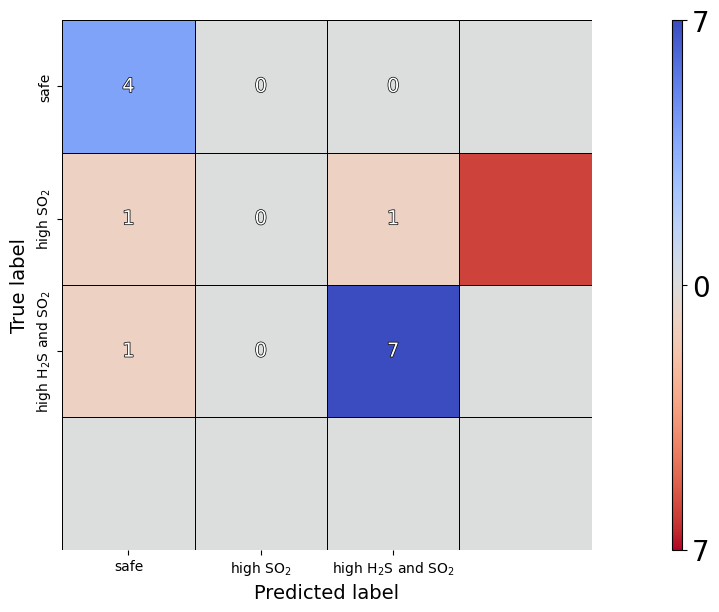

In [352]:
def viz_confusion_matrix(cm, classes):
    # Transpose the matrix and work on a copy to avoid modifying the original.
    cm = cm.copy()
    n_class = len(classes)
    classes = [target_to_string[c] for c in classes]
    
    # Determine the color scale bound.
    bound = np.max(np.abs(cm))
    
    # Negate off-diagonal elements.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j:
                cm[i, j] = -cm[i, j]
    
    # Create the figure and axis.
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Plot the heatmap.
    hm = sns.heatmap(cm, ax=ax, cmap="coolwarm_r", vmin=-bound, vmax=bound,
                square=True, linewidths=0.5, linecolor='black',
                xticklabels=classes, yticklabels=classes, cbar=False)
    ax.set_xlabel("Predicted label", fontsize=14)
    ax.set_ylabel("True label", fontsize=14)

    # create a new axes for the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.8)  # increase pad to move colorbar further right

    # add colorbar to the new axes
    cbar = fig.colorbar(hm.collections[0], cax=cax)

    # adjust colorbar ticks
    cbar.ax.tick_params(labelsize=fs)
    cbar.set_ticks([bound, 0, -bound], labels=[bound, 0, bound])
    
    # Annotate each cell with its integer value.
    for i in range(n_class):
        for j in range(n_class):
            txt = ax.text(j + 0.5, i + 0.5, f"{abs(int(cm[i, j]))}",
                          ha="center", va="center", fontsize=14, color="white")
            # Apply stroke for better readability.
            txt.set_path_effects([path_effects.Stroke(linewidth=1, foreground="black"),
                                  path_effects.Normal()])
    
    # Save the figure to a file.
    fig.savefig("cm.png", bbox_inches='tight', pad_inches=0.5)
    return 

y_pred = clf.predict(X_test)
viz_confusion_matrix(confusion_matrix(y_test, y_pred), np.unique(y_pred))



In [354]:
confusion_matrix(y_test, y_pred)

array([[4, 0, 0, 0],
       [1, 0, 1, 6],
       [1, 0, 7, 0],
       [0, 0, 0, 0]])

In [355]:
test_ids[y_pred==1]

array([], dtype=int64)

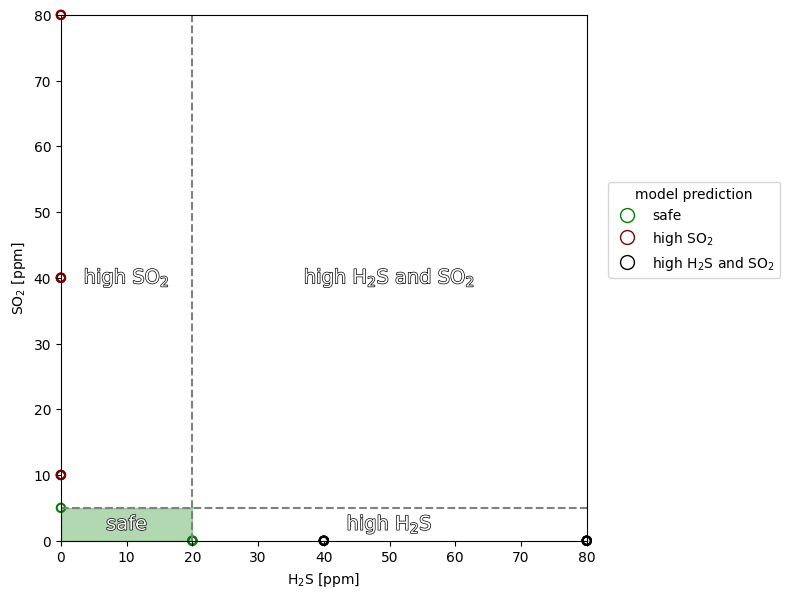

In [356]:
target_to_color = {0 : "green", 1 : "red", 2 : "maroon", 3 : "black"}
target_color = [target_to_color[pred] for pred in y_pred]
def add_text(text, pos):
    txt = ax.text(pos[0], pos[1], text, ha="center", va="center", fontsize=14, color="white")
    txt.set_path_effects([path_effects.Stroke(linewidth=1, foreground="black"),
                                  path_effects.Normal()])
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.vlines(20, ymin=0, ymax=80, color="grey", linestyle="dashed")
ax.hlines(5, xmin=0, xmax=80, color="grey", linestyle="dashed")
ax.fill_between([0, 20], 0, y2=5, color=('green', 0.3))

add_text("safe", [10, 2.5])
add_text("high H$_2$S and SO$_2$", [50, 40])
add_text("high SO$_2$", [10, 40])
add_text("high H$_2$S", [50, 2.5])

# create the bubble plot and legend handles
gas_legend_elements = []
for id, label in [(0, target_to_string[0]), (1, target_to_string[1]), (2, target_to_string[2]), (3, target_to_string[3])] :
    id_mask = (y_pred == id)
    if sum(id_mask) == 0:
        continue
    plot_id = test_ids[id_mask]
    scatter = ax.scatter(combo_df.loc[plot_id, "H2S"], combo_df.loc[plot_id, "SO2"],
                        edgecolors=target_to_color[id], linewidths=1.5, facecolors='none', clip_on=False)
    gas_legend_elements.append(Line2D([0], [0], marker='o', color='w', label=label,
                                    markeredgecolor=target_to_color[id], markerfacecolor='none', markersize=10))


# create the legends
gas_legend = ax.legend(handles=gas_legend_elements, title="model prediction", loc=(1.04,.5), frameon=True)
# ax.add_artist(gas_legend)



ax.set_xlim(0, 80)
ax.set_ylim(0, 80)
ax.set_aspect('equal', "box")
ax.set_xlabel("H$_2$S [ppm]")
ax.set_ylabel("SO$_2$ [ppm]")
plt.tight_layout()
plt.savefig("pred_plot.pdf", bbox_inches='tight')
plt.show();